# Modelo Riesgo de Mora

Importando librerias

In [249]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import math
from sklearn.metrics import make_scorer,roc_auc_score,confusion_matrix,mean_squared_error,classification_report,recall_score,f1_score,precision_score
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Cargar los datos

In [250]:
# Cargando las var.exp. del entrenamiento desde el localhost y reasignando indices
features_train = pd.read_csv('train.csv',index_col=0)
features_train.index=range(0,2189)
features_train

v0           v1     v2    v3    v4           v5          v6  \
0         0.00    143270.10  100.0   0.0   0.0  63090564.44  4199850.00   
1         0.00   1403461.97   90.0  10.0  29.0   8013913.78  8177030.69   
2     19800.24     63401.41  100.0   0.0   0.0    323384.60    67610.22   
3         0.00  10585032.22  100.0   0.0   5.0  29596681.95   186964.54   
4         0.00  11259663.09   78.0  22.0   0.0  33626595.71        0.00   
...        ...          ...    ...   ...   ...          ...         ...   
2184      0.00         0.00  100.0   0.0   0.0  17321789.44  6502334.11   
2185      0.00    148821.45  100.0   0.0   5.0  17874738.23   805330.00   
2186      0.00      6438.10    0.0   0.0   0.0         0.00        0.00   
2187      0.00   1309077.66   91.0   9.0  12.0   7757433.99  9312203.53   
2188      0.00   5525987.68  100.0   0.0   5.0  26044955.88        0.00   

            v7         v8    v9  ...  ae61  ae62  ae63  ae64  ae65  ae66  \
0         0.00  6240000.0  17.0  ...     0     0     0     0     0     0   
1     44951.90        0.0  12.0  ...     0     0     0     0     0     0   
2         0.00        0.0   4.0  ...     1     0     0     0     0     0   
3         0.00  4500000.0  11.0  ...     0     0     0     0     0     0   
4         0.00  3972827.7  24.0  ...     0     1     0     0     0     0   
...        ...        ...   ...  ...   ...   ...   ...   ...   ...   ...   
2184      0.00  4800000.0  23.0  ...     0     0     0     0     0     0   
2185      0.00  4279059.0  14.0  ...     0     0     0     0     0     0   
2186      0.00        0.0   9.0  ...     1     0     0     0     0     0   
2187  19156.47        0.0  12.0  ...     0     0     0     0     0     0   
2188      0.00        0.0  24.0  ...     0     1     0     0     0     0   

      ae67  ae68  d69  d70  
0        0     0    0    0  
1        0     0    0    0  
2        0     0    1    0  
3        0     0    0    0  
4        0     0    0    0  
...    ...   ...  ...  ...  
2184     0     1    0    0  
2185     0     1    0    0  
2186     0     0    1    0  
2187     0     0    0    0  
2188     0     0    0    0  

[2189 rows x 71 columns]

In [251]:
# Cargando la var.ind. del entrenamiento desde el localhost asignando nombre de columna
label_train = pd.read_csv('train_label.csv',names=['Moroso'])
label_train

Moroso
0        0.0
1        1.0
2        1.0
3        0.0
4        1.0
...      ...
2184     0.0
2185     0.0
2186     0.0
2187     1.0
2188     0.0

[2189 rows x 1 columns]

In [252]:
# Concatenando datas 'features_train'  y 'label_train' para armar el data_train
data_train = pd.concat([features_train,label_train],axis=1)
data_train

v0           v1     v2    v3    v4           v5          v6  \
0         0.00    143270.10  100.0   0.0   0.0  63090564.44  4199850.00   
1         0.00   1403461.97   90.0  10.0  29.0   8013913.78  8177030.69   
2     19800.24     63401.41  100.0   0.0   0.0    323384.60    67610.22   
3         0.00  10585032.22  100.0   0.0   5.0  29596681.95   186964.54   
4         0.00  11259663.09   78.0  22.0   0.0  33626595.71        0.00   
...        ...          ...    ...   ...   ...          ...         ...   
2184      0.00         0.00  100.0   0.0   0.0  17321789.44  6502334.11   
2185      0.00    148821.45  100.0   0.0   5.0  17874738.23   805330.00   
2186      0.00      6438.10    0.0   0.0   0.0         0.00        0.00   
2187      0.00   1309077.66   91.0   9.0  12.0   7757433.99  9312203.53   
2188      0.00   5525987.68  100.0   0.0   5.0  26044955.88        0.00   

            v7         v8    v9  ...  ae62  ae63  ae64  ae65  ae66  ae67  \
0         0.00  6240000.0  17.0  ...     0     0     0     0     0     0   
1     44951.90        0.0  12.0  ...     0     0     0     0     0     0   
2         0.00        0.0   4.0  ...     0     0     0     0     0     0   
3         0.00  4500000.0  11.0  ...     0     0     0     0     0     0   
4         0.00  3972827.7  24.0  ...     1     0     0     0     0     0   
...        ...        ...   ...  ...   ...   ...   ...   ...   ...   ...   
2184      0.00  4800000.0  23.0  ...     0     0     0     0     0     0   
2185      0.00  4279059.0  14.0  ...     0     0     0     0     0     0   
2186      0.00        0.0   9.0  ...     0     0     0     0     0     0   
2187  19156.47        0.0  12.0  ...     0     0     0     0     0     0   
2188      0.00        0.0  24.0  ...     1     0     0     0     0     0   

      ae68  d69  d70  Moroso  
0        0    0    0     0.0  
1        0    0    0     1.0  
2        0    1    0     1.0  
3        0    0    0     0.0  
4        0    0    0     1.0  
...    ...  ...  ...     ...  
2184     1    0    0     0.0  
2185     1    0    0     0.0  
2186     0    1    0     0.0  
2187     0    0    0     1.0  
2188     0    0    0     0.0  

[2189 rows x 72 columns]

In [253]:
data_train.isnull()

v0     v1     v2     v3     v4     v5     v6     v7     v8     v9  \
0     False  False  False  False  False  False  False  False  False  False   
1     False  False  False  False  False  False  False  False  False  False   
2     False  False  False  False  False  False  False  False  False  False   
3     False  False  False  False  False  False  False  False  False  False   
4     False  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2184  False  False  False  False  False  False  False  False  False  False   
2185  False  False  False  False  False  False  False  False  False  False   
2186  False  False  False  False  False  False  False  False  False  False   
2187  False  False  False  False  False  False  False  False  False  False   
2188  False  False  False  False  False  False  False  False  False  False   

      ...   ae62   ae63   ae64   ae65   ae66   ae67   ae68    d69    d70  \
0     ...  False  False  False  False  False  False  False  False  False   
1     ...  False  False  False  False  False  False  False  False  False   
2     ...  False  False  False  False  False  False  False  False  False   
3     ...  False  False  False  False  False  False  False  False  False   
4     ...  False  False  False  False  False  False  False  False  False   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2184  ...  False  False  False  False  False  False  False  False  False   
2185  ...  False  False  False  False  False  False  False  False  False   
2186  ...  False  False  False  False  False  False  False  False  False   
2187  ...  False  False  False  False  False  False  False  False  False   
2188  ...  False  False  False  False  False  False  False  False  False   

      Moroso  
0      False  
1      False  
2      False  
3      False  
4      False  
...      ...  
2184   False  
2185   False  
2186   False  
2187   False  
2188   False  

[2189 rows x 72 columns]

In [254]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   v0      2189 non-null   float64
 1   v1      2189 non-null   float64
 2   v2      2189 non-null   float64
 3   v3      2189 non-null   float64
 4   v4      2189 non-null   float64
 5   v5      2189 non-null   float64
 6   v6      2189 non-null   float64
 7   v7      2189 non-null   float64
 8   v8      2189 non-null   float64
 9   v9      2189 non-null   float64
 10  v10     2189 non-null   float64
 11  v11     2189 non-null   float64
 12  v12     2189 non-null   float64
 13  v13     2189 non-null   float64
 14  v14     2189 non-null   float64
 15  v15     2189 non-null   float64
 16  v16     2189 non-null   float64
 17  v17     2189 non-null   float64
 18  v18     2189 non-null   float64
 19  v19     2189 non-null   float64
 20  v20     2189 non-null   float64
 21  v21     2189 non-null   float64
 22  

Análisis de nulos en la data

In [255]:
(data_train.isnull().sum()/data_train.shape[0])*100 

v0        0.0
v1        0.0
v2        0.0
v3        0.0
v4        0.0
         ... 
ae67      0.0
ae68      0.0
d69       0.0
d70       0.0
Moroso    0.0
Length: 72, dtype: float64

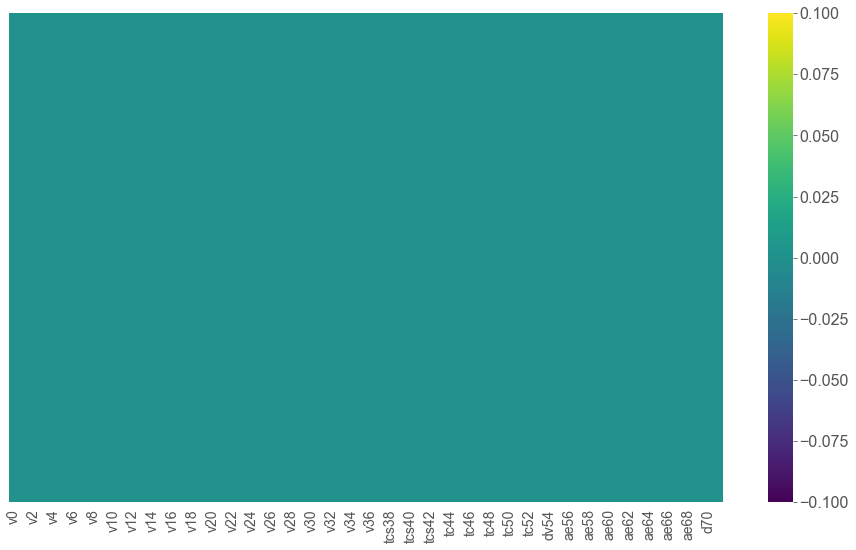

In [256]:
sns.heatmap(data_train.isnull(),yticklabels=False,cbar=True,cmap='viridis')

Análisis de Target

Text(0.5, 1.0, 'Frecuencia por número de observacion')

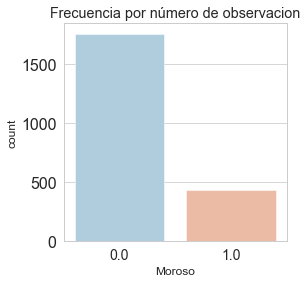

In [257]:
sns.set_style('whitegrid')
plt.figure(figsize=(4,4))
sns.countplot(x='Moroso',data=data_train,palette='RdBu_r')
plt.title("Frecuencia por número de observacion")

In [258]:
count_no_sub = len (data_train [data_train ['Moroso'] == 0]) 
count_sub = len (data_train [data_train ['Moroso'] == 1]) 
pct_of_no_sub = count_no_sub / (count_no_sub + count_sub) 
print ("Porcentaje de no Morosos:", round(pct_of_no_sub * 100,1),'%') 
pct_of_sub = count_sub / (count_no_sub + count_sub) 
print ("Porcentaje de Morosos:", round(pct_of_sub * 100,1),'%')

Porcentaje de no Morosos: 80.4 %
Porcentaje de Morosos: 19.6 %


### Observación

- Vemos que la data está 'desbalanceada', ya que se tiene una menor proporción en la clase morosos, la cual es de mayor interés. Esto podría afectar a los modelos en su proceso de generalización de la información y perjudicaría a la clase minoritaria, para solucionar ello 'balancearemos' los datos de dos formas. 

### Forma 1:  
Con classweight, en los modelos que tengan esa opción.

### Forma 2: 
Con oversampling.

# Visualizamos los datos

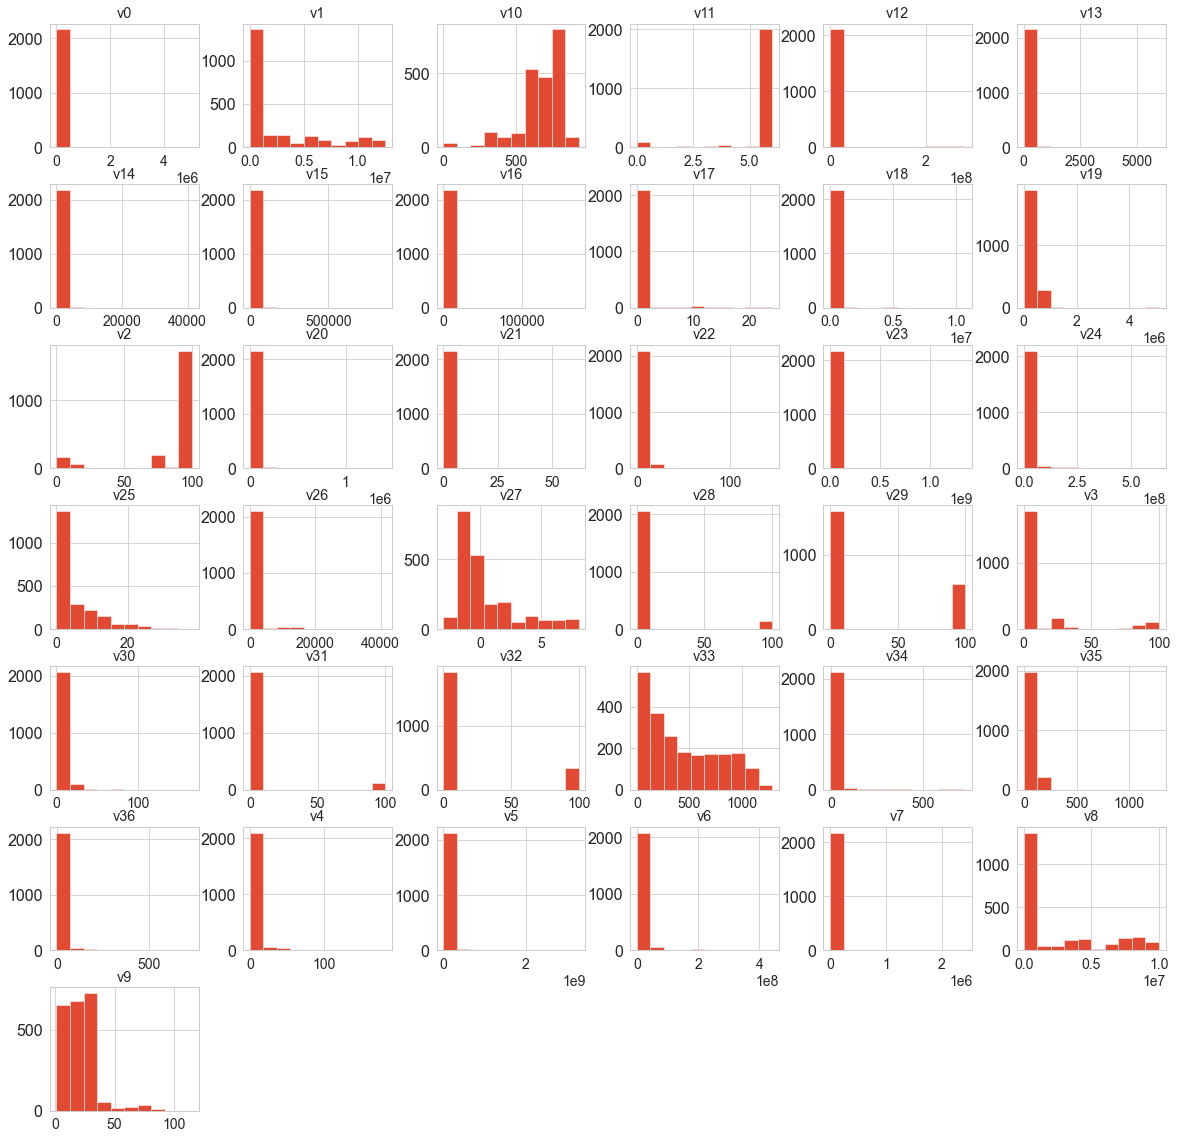

In [259]:
### Histograma de variables cuantitativas

fig = plt.figure(figsize = (20,20))
ax = fig.gca()
vc = list()
for i in range(0,37):
    vc.append('v'+str(i))
vc 
var_cont = features_train[vc]
var_cont.hist(ax=ax)
plt.show()

In [260]:
### Principales stadísticos de cada variable numérica
var_cont.describe().T

count          mean           std  min           25%           50%  \
v0   2189.0  2.789336e+04  2.770920e+05  0.0  0.000000e+00  0.000000e+00   
v1   2189.0  2.498074e+06  3.713769e+06  0.0  1.411988e+04  1.781006e+05   
v2   2189.0  8.709868e+01  2.954893e+01  0.0  1.000000e+02  1.000000e+02   
v3   2189.0  1.031795e+01  2.592240e+01  0.0  0.000000e+00  0.000000e+00   
v4   2189.0  3.608040e+00  8.477891e+00  0.0  0.000000e+00  0.000000e+00   
v5   2189.0  7.332287e+07  3.009257e+08  0.0  2.898817e+06  1.623024e+07   
v6   2189.0  1.011043e+07  4.209394e+07  0.0  0.000000e+00  1.970460e+04   
v7   2189.0  1.126268e+04  1.540442e+05  0.0  0.000000e+00  0.000000e+00   
v8   2189.0  2.283687e+06  3.283374e+06  0.0  0.000000e+00  0.000000e+00   
v9   2189.0  2.092051e+01  1.311969e+01  1.0  1.100000e+01  2.200000e+01   
v10  2189.0  6.721270e+02  1.539253e+02  0.0  6.100000e+02  6.990000e+02   
v11  2189.0  5.630425e+00  1.321668e+00  0.0  6.000000e+00  6.000000e+00   
v12  2189.0  8.800052e+06  4.259808e+07  0.0  0.000000e+00  0.000000e+00   
v13  2189.0  5.005071e+01  3.886288e+02  0.0  0.000000e+00  0.000000e+00   
v14  2189.0  8.241480e+01  1.058498e+03  0.0  0.000000e+00  0.000000e+00   
v15  2189.0  3.090847e+03  3.452511e+04  0.0  0.000000e+00  0.000000e+00   
v16  2189.0  7.136743e+02  6.590563e+03  0.0  0.000000e+00  0.000000e+00   
v17  2189.0  5.906807e-01  2.589111e+00  0.0  0.000000e+00  0.000000e+00   
v18  2189.0  5.224041e+04  4.826651e+05  0.0  0.000000e+00  0.000000e+00   
v19  2189.0  1.502924e+05  4.498976e+05  0.0  0.000000e+00  0.000000e+00   
v20  2189.0  1.001479e+04  7.167207e+04  0.0  0.000000e+00  0.000000e+00   
v21  2189.0  4.604842e-01  2.738098e+00  0.0  0.000000e+00  0.000000e+00   
v22  2189.0  1.577889e+00  7.471945e+00  0.0  0.000000e+00  0.000000e+00   
v23  2189.0  1.183165e+07  6.341034e+07  0.0  1.629258e+04  8.223397e+04   
v24  2189.0  1.344988e+07  4.133237e+07  0.0  0.000000e+00  6.466171e+05   
v25  2189.0  4.413888e+00  6.546592e+00  0.0  0.000000e+00  0.000000e+00   
v26  2189.0  1.003878e+03  2.893458e+03  0.0  3.500000e+01  3.250000e+02   
v27  2189.0  4.180838e-01  2.443169e+00 -3.0 -1.288042e+00 -6.247637e-01   
v28  2189.0  6.167200e+00  2.406138e+01  0.0  0.000000e+00  0.000000e+00   
v29  2189.0  2.777524e+01  4.479930e+01  0.0  0.000000e+00  0.000000e+00   
v30  2189.0  2.038374e+00  8.404936e+00  0.0  0.000000e+00  0.000000e+00   
v31  2189.0  5.573321e+00  2.294582e+01  0.0  0.000000e+00  0.000000e+00   
v32  2189.0  1.566926e+01  3.635937e+01  0.0  0.000000e+00  0.000000e+00   
v33  2189.0  4.219365e+02  3.450955e+02  0.0  1.210000e+02  3.230000e+02   
v34  2189.0  3.464824e+01  3.706751e+01 -3.0  3.000000e+01  3.100000e+01   
v35  2189.0  3.571128e+01  5.969703e+01 -3.0  1.000000e+00  1.000000e+00   
v36  2189.0  3.411878e+01  3.323056e+01 -3.0  3.000000e+01  3.100000e+01   

              75%           max  
v0   0.000000e+00  5.030246e+06  
v1   3.958601e+06  1.257078e+07  
v2   1.000000e+02  1.000000e+02  
v3   0.000000e+00  1.000000e+02  
v4   5.000000e+00  1.830000e+02  
v5   3.308427e+07  3.283312e+09  
v6   2.560791e+06  4.415314e+08  
v7   0.000000e+00  2.427617e+06  
v8   4.355600e+06  1.000000e+07  
v9   2.400000e+01  1.150000e+02  
v10  7.910000e+02  9.360000e+02  
v11  6.000000e+00  6.000000e+00  
v12  5.269417e+05  2.834844e+08  
v13  0.000000e+00  5.991000e+03  
v14  0.000000e+00  4.127400e+04  
v15  0.000000e+00  8.612790e+05  
v16  8.500000e+01  1.730620e+05  
v17  0.000000e+00  2.400000e+01  
v18  0.000000e+00  1.076363e+07  
v19  1.050000e+05  5.117872e+06  
v20  0.000000e+00  1.413962e+06  
v21  0.000000e+00  6.200000e+01  
v22  0.000000e+00  1.450000e+02  
v23  2.867601e+06  1.357272e+09  
v24  1.321816e+07  6.301953e+08  
v25  7.000000e+00  3.800000e+01  
v26  6.750000e+02  4.138200e+04  
v27  1.389325e+00  8.083333e+00  
v28  0.000000e+00  1.000000e+02  
v29  1.000000e+02  1.000000e+02  
v30  0.000000e+00  1.650000e+02  
v31  0.000000e+00  1.000000e+

In [261]:
# Analizamos las variables categóricas
var_cat=features_train.drop(vc,axis=1)
pd.DataFrame([var_cat.sum(),2189-var_cat.sum()],index=['1','0']).T

1     0
tcs37   336  1853
tcs38  1389   800
tcs39   297  1892
tcs40    71  2118
tcs41     8  2181
tcs42    46  2143
tc43     10  2179
tc44      6  2183
tc45     21  2168
tc46      1  2188
tc47      1  2188
tc48     24  2165
tc49    626  1563
tc50     36  2153
tc51   1431   758
tc52      1  2188
tc53     28  2161
dv54    601  1588
ae55    452  1737
ae56    247  1942
ae57    287  1902
ae58     76  2113
ae59      9  2180
ae60     14  2175
ae61     76  2113
ae62    814  1375
ae63      9  2180
ae64     48  2141
ae65     10  2179
ae66     32  2157
ae67     17  2172
ae68     97  2092
d69     268  1921
d70       0  2189

In [262]:
# Hacemos la operación inversa de get_dummies para hacer descriptivos sobre las variables categóricas
tsc = var_cat.iloc[:,range(0,6)]
tc = var_cat.iloc[:,range(6,17)]
dv = var_cat.iloc[:,range(17,18)]
ae = var_cat.iloc[:,range(18,32)]
d = var_cat.iloc[:,range(32,34)]
new_tsc = tsc.idxmax(axis=1)
new_tc = tc.idxmax(axis=1)
new_dv = dv.idxmax(axis=1)
new_ae = ae.idxmax(axis=1)
new_d = d.idxmax(axis=1)
new_var_cat = pd.DataFrame([new_tsc,new_tc,new_dv,new_ae,new_d]).T
new_var_cat.columns = ['tcs','tc','dv','ae','d']
new_var_cat

tcs    tc    dv    ae    d
0     tcs38  tc51  dv54  ae56  d69
1     tcs38  tc51  dv54  ae55  d69
2     tcs42  tc51  dv54  ae61  d69
3     tcs38  tc51  dv54  ae55  d69
4     tcs38  tc51  dv54  ae62  d69
...     ...   ...   ...   ...  ...
2184  tcs38  tc51  dv54  ae68  d69
2185  tcs39  tc51  dv54  ae68  d69
2186  tcs37  tc51  dv54  ae61  d69
2187  tcs38  tc51  dv54  ae55  d69
2188  tcs38  tc51  dv54  ae62  d69

[2189 rows x 5 columns]

In [263]:
# Construimos una data que contenga las var. categóricas y la clase Morosa y no Morosa
# para posteiormente hacer el gráfico de barras comparativo por clase
new_data_train_cat = pd.concat([new_var_cat,label_train],axis=1)

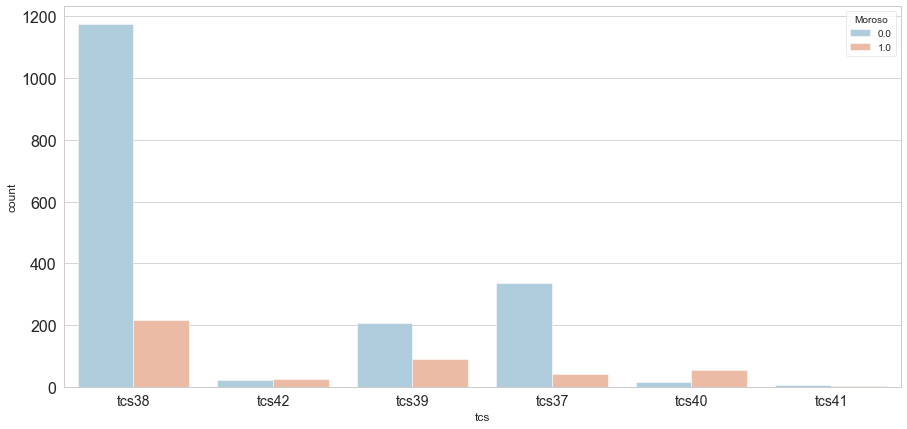

In [264]:
plt.figure(figsize=(15,7))
sns.set_style('whitegrid')
sns.countplot(x='tcs',hue='Moroso',data=new_data_train_cat,palette='RdBu_r')

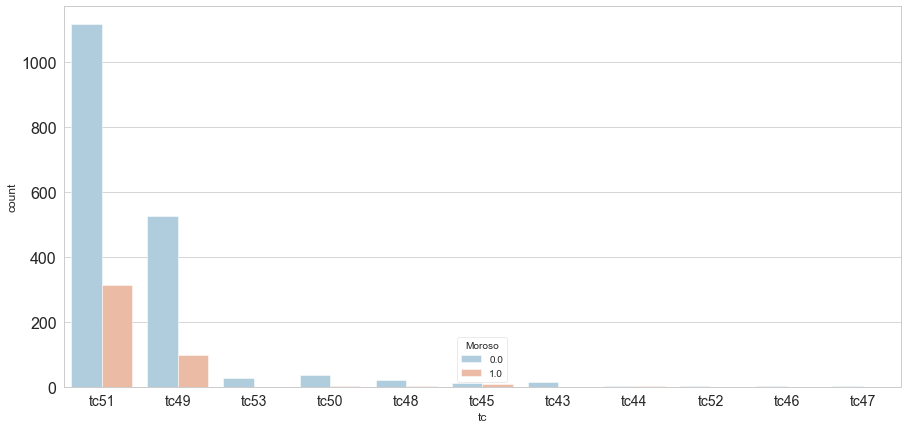

In [265]:
plt.figure(figsize=(15,7))
sns.set_style('whitegrid')
sns.countplot(x='tc',hue='Moroso',data=new_data_train_cat,palette='RdBu_r')

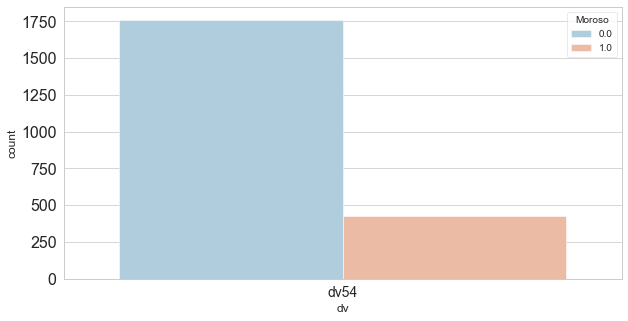

In [266]:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.countplot(x='dv',hue='Moroso',data=new_data_train_cat,palette='RdBu_r')

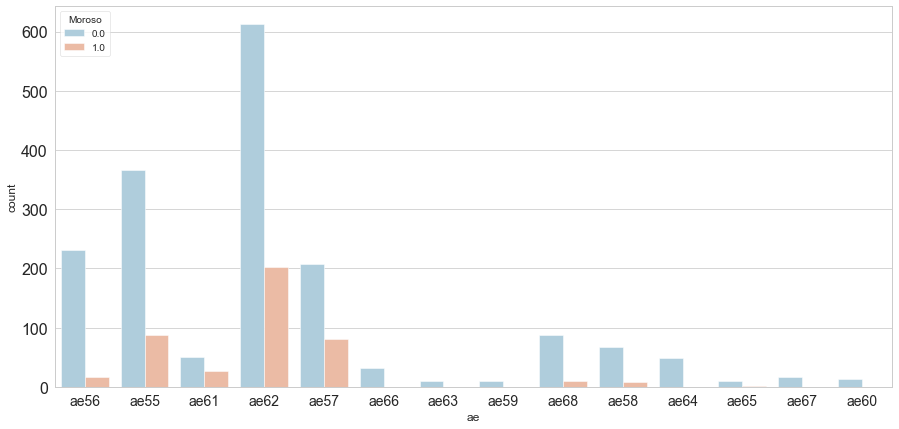

In [267]:
plt.figure(figsize=(15,7))
sns.set_style('whitegrid')
sns.countplot(x='ae',hue='Moroso',data=new_data_train_cat,palette='RdBu_r')

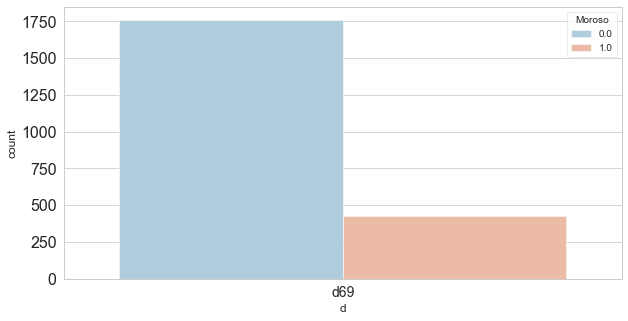

In [268]:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.countplot(x='d',hue='Moroso',data=new_data_train_cat,palette='RdBu_r')

### Observaciones:

- La variable tcs presenta la mayor cantidad de morosos en la clase tcs 38, esto se al gran número de créditos que poseen estas características, sin embargo, los créditos pertenecientes a las clases tcs40 y tcs42 evidencian mayor probabilidad de caer en mora.
- Los créditos no presentan características d70, es decir solo hay valores 0 en la columna d70, por lo que es necesario excluirla del modelo sobre todo si es que se piensa usar un modelo de regresión logística sin penalizaciones, ya que además de ser una variable sin importancia para el modelo, generaría que la matriz de datos sea de rango incompleto y por tanto haría que la convergencia de la estimación de los parámetros no se dé.

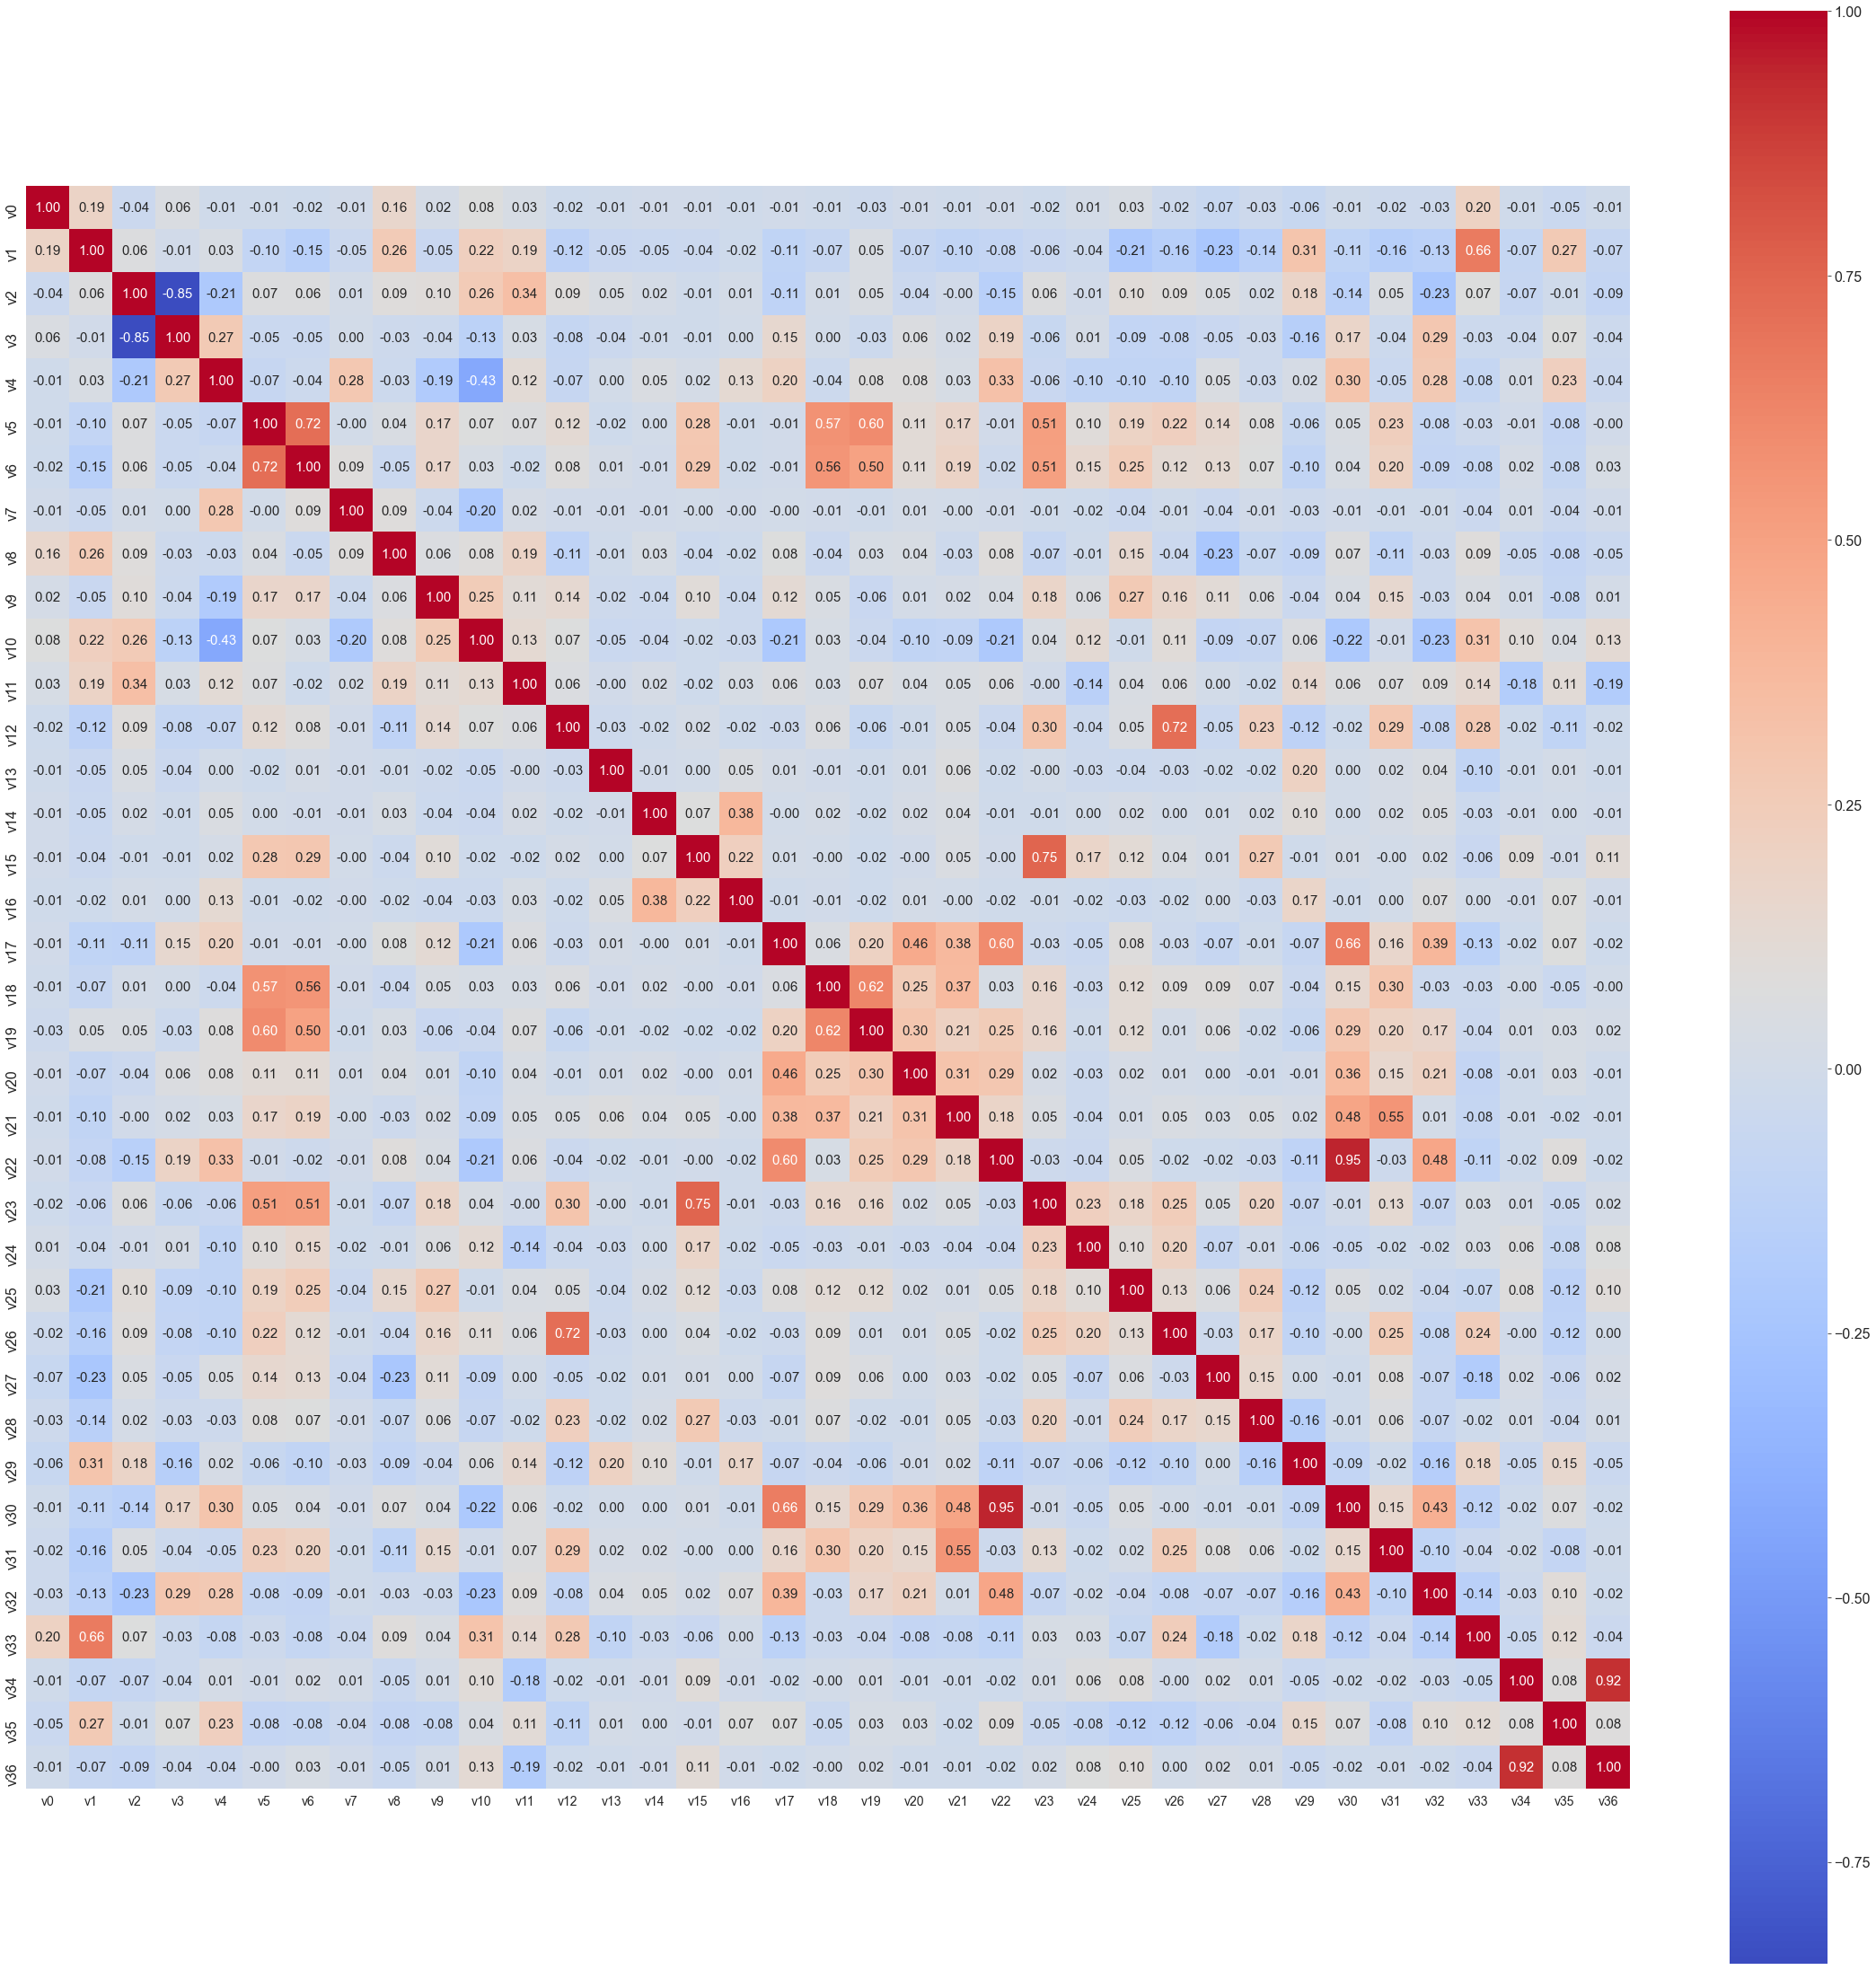

In [269]:
### correlacion entre variables numéricas
corr_cont = var_cont.corr(method='pearson')
plt.figure(figsize=(40,40))
sns.heatmap(corr_cont,cbar  =  True ,   square  =  True, annot=True,  fmt =  '.2f' , annot_kws = { 'size' :  15 },cmap =  'coolwarm')
plt.show()

Existe una alta correlación negativa entre las variables v2 y v3, mientras que entre las variables v5 y v6, v12 y v26, v15 y v23, v22 y v30, v34 y v36 existe una alta correlación positiva, sobre todo en las últimas dos parejas (r>0.9), esto sería un problema si es que usaramos el modelo de regresión logística ya que se ve afectado por la multicolinealidad. Podríamos solucionar esto eliminando alguna de las variables de estas dos parejas o en todo caso aprovechar la poca información diferencial que ofrece cada una de ellas mediante el procedimiento WoE and binning para finalmente introducirlos al modelo de regresión.

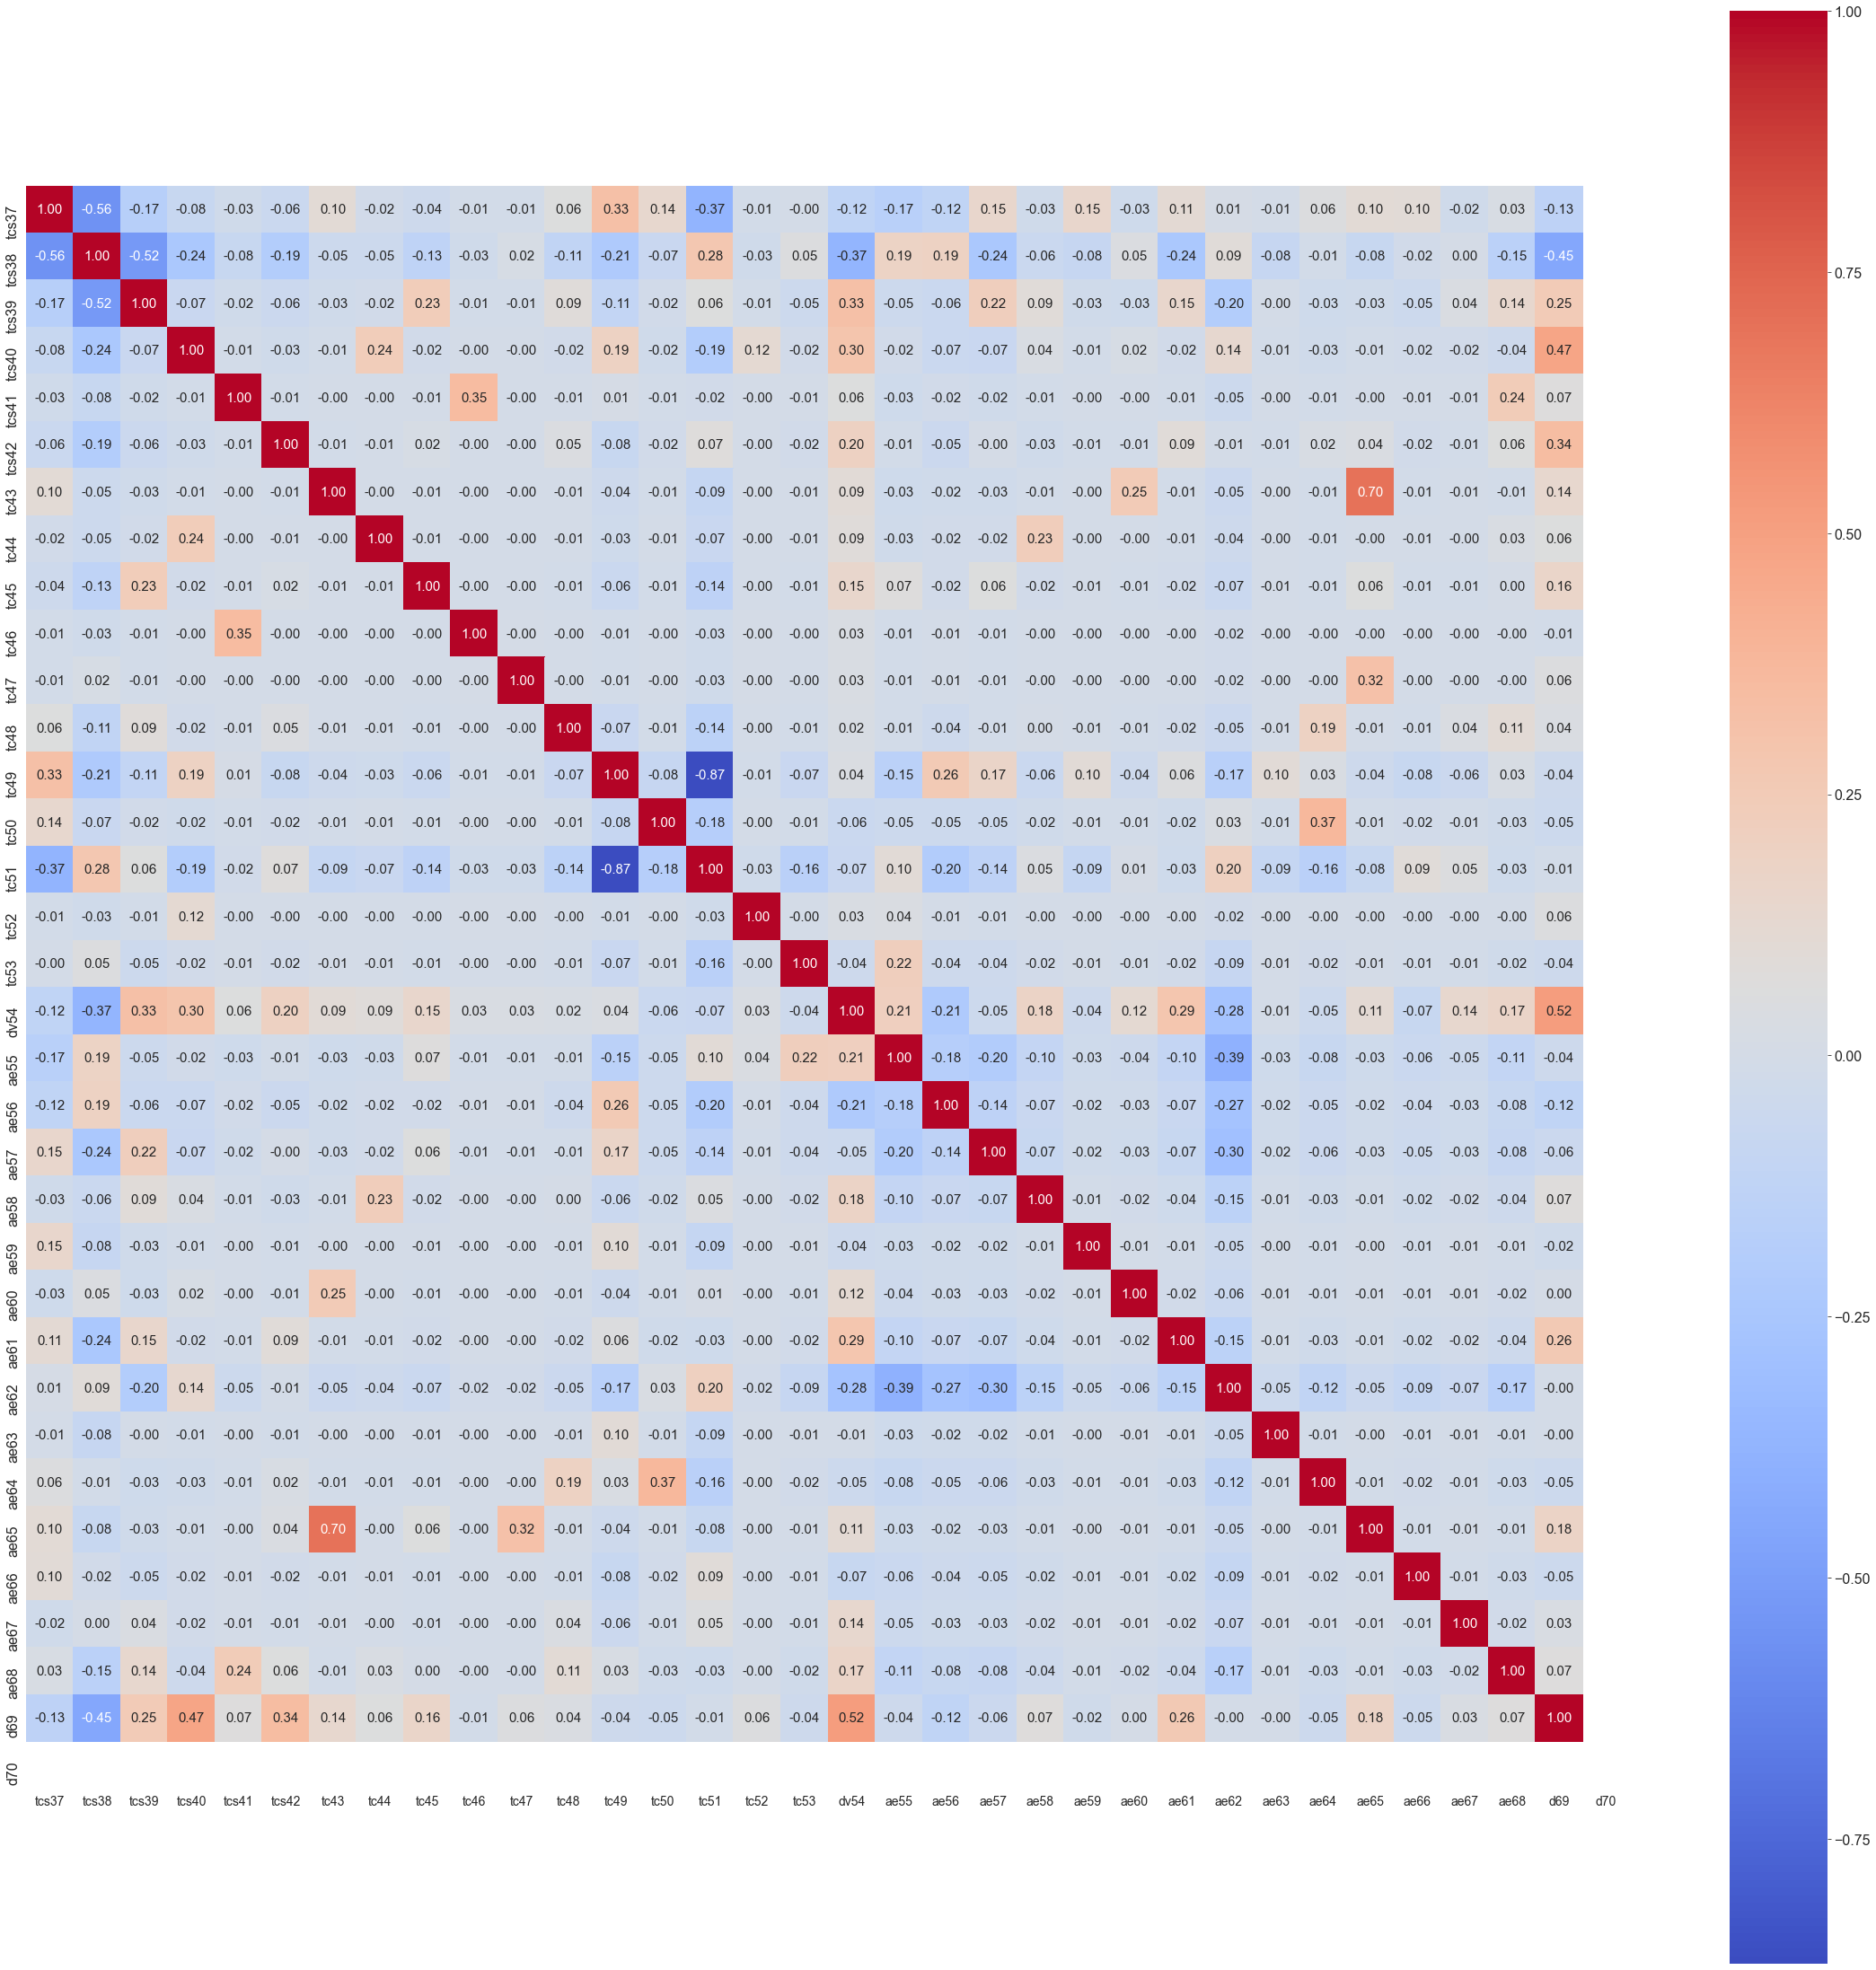

In [270]:
### correlacion entre variables dummies
corr_cat = var_cat.corr(method='spearman')
plt.figure(figsize=(40,40))
sns.heatmap(corr_cat,cbar  =  True ,   square  =  True, annot=True,  fmt =  '.2f' , annot_kws = { 'size' :  15 },cmap =  'coolwarm')
plt.show()

Existe una alta correlación negativa entre las variables tc49 y tc51, mientras que entre las variables tc43 y ae65 existe una alta correlación positiva. Al igual que con las variables numéricas podríamos eliminar alguna variables de estas parejas o en todo caso aprovechar la información diferencial mediante el mismo procedimiento WoE.

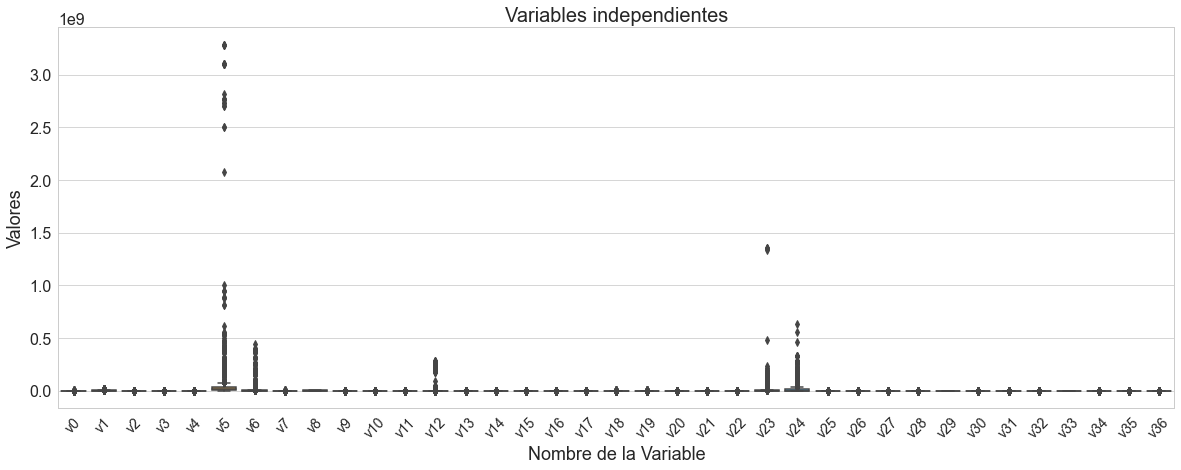

In [271]:
# Boxplots de cada variable numérica
plt.figure(figsize=(20,7))
ax = sns.boxplot(data=var_cont)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.title('Variables independientes', fontsize=20)
plt.ylabel('Valores', fontsize=18)
_ = plt.xlabel('Nombre de la Variable', fontsize=18)

Al no poder observar bien los gráficos de caja de cada variable numérica, se decide aplicar una estandarización de puntuación z a cada una de ellas para poder tener un mejor panorama de todas las variables y poder compararlas.

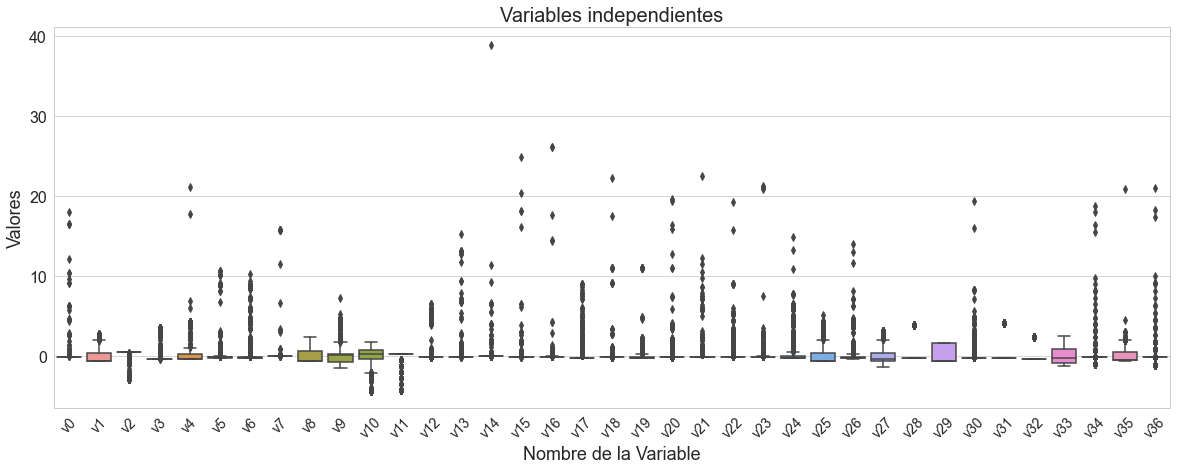

In [272]:
# Boxplots de cada variable numérica estandarizada
plt.figure(figsize=(20,7))
var_cont_std=(var_cont-var_cont.mean())/var_cont.std()
ax = sns.boxplot(data=var_cont_std)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.title('Variables independientes', fontsize=20)
plt.ylabel('Valores', fontsize=18)
_ = plt.xlabel('Nombre de la Variable', fontsize=18)

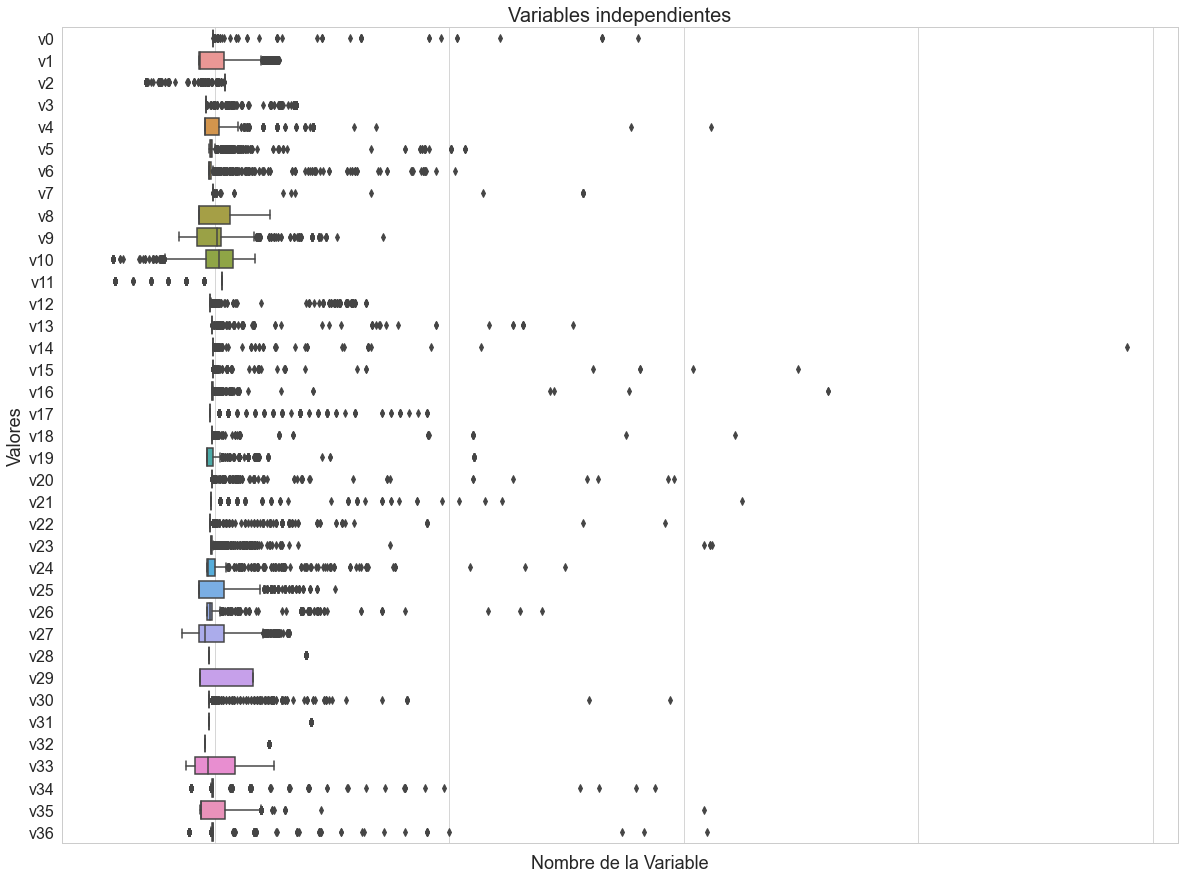

In [273]:
# Boxplots de cada variable numérica estandarizada
plt.figure(figsize=(20,15))
var_cont_std=(var_cont-var_cont.mean())/var_cont.std()
ax = sns.boxplot(data=var_cont_std,orient='h')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.title('Variables independientes', fontsize=20)
plt.ylabel('Valores', fontsize=18)
_ = plt.xlabel('Nombre de la Variable', fontsize=18)

Con estos dos gráficos podemos observar a mayor detalle el gráfico de caja de cada una de estas variables, esto con el fin de detectar outliers, los cuales están presentes en todas las variables numéricas a excepción de v33. El problema de los outliers afecta mucho en la clasificación del modelo de regresión logística, es por ello que posteriormente se hará un tratamiento de outliers haciendo transformaciones de las variables originales y de darse el caso de aún tener valores atípicos, generar un bucle para eliminarlos y reemplzarlos por los percentiles 25 o 75 según sea el caso.

# Procesamiento de Datos

Armando el data test

In [274]:
# Cargando las var.exp. del entrenamiento desde el localhost y reasignando indices
features_test = pd.read_csv('test.csv',index_col=0)
features_test.index=range(0,548)
features_test

v0           v1     v2    v3    v4            v5           v6   v7  \
0        0.00         0.10   29.0  71.0   0.0  4.206076e+07   2445379.88  0.0   
1        0.00         0.00  100.0   0.0   3.0  6.356591e+06   1151315.35  0.0   
2        0.00         0.00  100.0   0.0   0.0  1.834357e+08   8136692.18  0.0   
3        0.00    104207.83  100.0   0.0   0.0  7.515544e+07   4211350.00  0.0   
4    87791.71    460376.03   94.0   6.0  26.0  8.624776e+07  39737205.73  0.0   
..        ...          ...    ...   ...   ...           ...          ...  ...   
543      0.00    813216.41  100.0   0.0   0.0  1.642559e+07         0.00  0.0   
544      0.00     39690.33  100.0   0.0   0.0  7.174000e+07         0.00  0.0   
545      0.00     43754.09  100.0   0.0   0.0  9.366955e+07         0.00  0.0   
546      0.00  10484136.23  100.0   0.0   4.0  2.858129e+07    423747.53  0.0   
547      0.00   6324660.10  100.0   0.0   5.0  3.308427e+07         0.00  0.0   

             v8    v9  ...  ae61  ae62  ae63  ae64  ae65  ae66  ae67  ae68  \
0     8000000.0  40.0  ...     0     0     0     0     0     0     0     1   
1     3798381.6  24.0  ...     0     0     0     0     0     0     0     1   
2     8000000.0   8.0  ...     0     0     0     0     0     0     0     0   
3     6240000.0  17.0  ...     0     0     0     0     0     0     0     0   
4     8000000.0  15.0  ...     0     0     0     0     0     0     0     0   
..          ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
543   3071719.0  23.0  ...     0     0     0     0     0     0     0     0   
544  10000000.0   9.0  ...     0     1     0     0     0     0     0     0   
545         0.0  45.0  ...     1     0     0     0     0     0     0     0   
546   4500000.0  11.0  ...     0     0     0     0     0     0     0     0   
547         0.0  24.0  ...     0     1     0     0     0     0     0     0   

     d69  d70  
0      0    0  
1      0    0  
2      0    0  
3      0    0  
4      0    0  
..   ...  ...  
543    0    0  
544    0    0  
545    0    0  
546    0    0  
547    0    0  

[548 rows x 71 columns]

In [275]:
# Cargando la var.ind. del test desde el localhost asignando nombre de columna
label_test = pd.read_csv('test_label.csv',names=['Moroso'])
label_test

Moroso
0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
..      ...
543     0.0
544     0.0
545     0.0
546     0.0
547     0.0

[548 rows x 1 columns]

In [276]:
# Concatenando datas 'features_test'  y 'label_test' para armar el data_test
data_test = pd.concat([features_test,label_test],axis=1)
data_test

v0           v1     v2    v3    v4            v5           v6   v7  \
0        0.00         0.10   29.0  71.0   0.0  4.206076e+07   2445379.88  0.0   
1        0.00         0.00  100.0   0.0   3.0  6.356591e+06   1151315.35  0.0   
2        0.00         0.00  100.0   0.0   0.0  1.834357e+08   8136692.18  0.0   
3        0.00    104207.83  100.0   0.0   0.0  7.515544e+07   4211350.00  0.0   
4    87791.71    460376.03   94.0   6.0  26.0  8.624776e+07  39737205.73  0.0   
..        ...          ...    ...   ...   ...           ...          ...  ...   
543      0.00    813216.41  100.0   0.0   0.0  1.642559e+07         0.00  0.0   
544      0.00     39690.33  100.0   0.0   0.0  7.174000e+07         0.00  0.0   
545      0.00     43754.09  100.0   0.0   0.0  9.366955e+07         0.00  0.0   
546      0.00  10484136.23  100.0   0.0   4.0  2.858129e+07    423747.53  0.0   
547      0.00   6324660.10  100.0   0.0   5.0  3.308427e+07         0.00  0.0   

             v8    v9  ...  ae62  ae63  ae64  ae65  ae66  ae67  ae68  d69  \
0     8000000.0  40.0  ...     0     0     0     0     0     0     1    0   
1     3798381.6  24.0  ...     0     0     0     0     0     0     1    0   
2     8000000.0   8.0  ...     0     0     0     0     0     0     0    0   
3     6240000.0  17.0  ...     0     0     0     0     0     0     0    0   
4     8000000.0  15.0  ...     0     0     0     0     0     0     0    0   
..          ...   ...  ...   ...   ...   ...   ...   ...   ...   ...  ...   
543   3071719.0  23.0  ...     0     0     0     0     0     0     0    0   
544  10000000.0   9.0  ...     1     0     0     0     0     0     0    0   
545         0.0  45.0  ...     0     0     0     0     0     0     0    0   
546   4500000.0  11.0  ...     0     0     0     0     0     0     0    0   
547         0.0  24.0  ...     1     0     0     0     0     0     0    0   

     d70  Moroso  
0      0     0.0  
1      0     0.0  
2      0     0.0  
3      0     0.0  
4      0     1.0  
..   ...     ...  
543    0     0.0  
544    0     0.0  
545    0     0.0  
546    0     0.0  
547    0     0.0  

[548 rows x 72 columns]

In [277]:
y_train = data_train['Moroso']
X_train = data_train.drop('Moroso',axis=1)
y_test = data_test['Moroso']
X_test = data_test.drop('Moroso',axis=1)

# Modelos sin tratamiento QuantTrans ni selección de mejores variables

In [278]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

### Data sin Balancear

## LGBM

In [279]:
from time import time
# construimos un lightgbm
best_model_LGBM1 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8)
best_model_LGBM1.fit(X_train, y_train)

# predecimos el train y test con la probabilidad para validar 
predict_train_lg1 = best_model_LGBM1.predict_proba(X_train)[:,1]
predict_test_lg1 = best_model_LGBM1.predict_proba(X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg1)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg1)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.973
auc o Roc on testing in LGBMClassifier data : 0.961


In [280]:
predictions_train_LGBM1 = best_model_LGBM1.predict(X_train)
predictions_test_LGBM1 = best_model_LGBM1.predict(X_test)
print(roc_auc_score(y_train, predictions_train_LGBM1))
print(roc_auc_score(y_test, predictions_test_LGBM1))
print(confusion_matrix(y_test, predictions_test_LGBM1))

0.8697843822843822
0.869570707070707
[[423  17]
 [ 24  84]]


In [282]:
print("Accuracy of LGBM:",roc_auc_score(y_test,predictions_test_LGBM1)*100,'\n')
print(classification_report(y_test,predictions_test_LGBM1))

Accuracy of LGBM: 86.9570707070707 

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       440
         1.0       0.83      0.78      0.80       108

    accuracy                           0.93       548
   macro avg       0.89      0.87      0.88       548
weighted avg       0.92      0.93      0.92       548



## XGBOOST

In [283]:
from time import time
# construimos un xgb
best_model_XGB1 = XGBClassifier(learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB1.fit(X_train, y_train)

# predecimos el train y test con la probabilidad para validar 
predict_train_xg1 = best_model_XGB1.predict_proba(X_train)[:,1]
predict_test_xg1 = best_model_XGB1.predict_proba(X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_xg1)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_xg1)))

[10:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.973
auc o Roc on testing in LGBMClassifier data : 0.961


In [284]:
predictions_train_XGB1 = best_model_XGB1.predict(X_train)
predictions_test_XGB1 = best_model_XGB1.predict(X_test)
print(roc_auc_score(y_train, predictions_train_XGB1))
print(roc_auc_score(y_test, predictions_test_XGB1))
print(confusion_matrix(y_test, predictions_test_XGB1))

0.8771197552447554
0.869570707070707
[[423  17]
 [ 24  84]]


In [286]:
print("Accuracy of XGB:",roc_auc_score(y_test,predictions_test_XGB1)*100,'\n')
print(classification_report(y_test,predictions_test_XGB1))

Accuracy of XGB: 86.9570707070707 

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       440
         1.0       0.83      0.78      0.80       108

    accuracy                           0.93       548
   macro avg       0.89      0.87      0.88       548
weighted avg       0.92      0.93      0.92       548



## Regresión Logística 

- Introduciremos todas las variables para el entrenamiento del modelo de regresión logística, sin embargo personalizaremos algunos de sus parámetros para mejorar este proceso, dentro de ellos están las penalizaciones Lasso, Ridge y ElasticNet:

### Penalización Lasso (l1):

Lasso nos va a servir de ayuda cuando sospechemos que varios de los atributos de entrada (features) sean irrelevantes. Al usar Lasso, estamos fomentando que la solución sea poco densa. Es decir, favorecemos que algunos de los coeficientes acaben valiendo 0. Esto puede ser útil para descubrir cuáles de los atributos de entrada son relevantes y, en general, para obtener un modelo que generalice mejor. Lasso nos puede ayudar, en este sentido, a hacer la selección de atributos de entrada. Lasso funciona mejor cuando los atributos no están muy correlados entre ellos.

### Penalización Ridge (l2):

Ridge nos va a servir de ayuda cuando sospechemos que varios de los atributos de entrada (features) estén correlados entre ellos. Ridge hace que los coeficientes acaben siendo más pequeños. Esta disminución de los coeficientes minimiza el efecto de la correlación entre los atributos de entrada y hace que el modelo generalice mejor. Ridge funciona mejor cuando la mayoría de los atributos son relevantes.

### Penalización ElasticNet (l2):
Usaremos ElasticNet cuando tengamos un gran número de atributos. Algunos de ellos serán irrelevantes y otros estarán correlados entre ellos.

- En este caso, por lo visto en las gráficas de correlación, es muy probable que se presenten problemas de multicolinealidad, debido a la fuerte correlación que existe entre algunos pares de ellas.

### LASSO

In [287]:
logmodel1 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel1.fit(X_train,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [288]:
print("Weights:")
print("\tB0 =", logmodel1.intercept_[0])
for i, b in enumerate(logmodel1.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.5515962115720505
	B1 =1.2112279124591505e-06
	B2 =1.8383999085089695e-07
	B3 =-0.003842451099485644
	B4 =0.016577224858704876
	B5 =0.04989416991796598
	B6 =-1.423448586419992e-09
	B7 =-7.415381521816036e-09
	B8 =-3.300624792848441e-07
	B9 =1.3141742829067683e-07
	B10 =-0.031091073443046437
	B11 =-0.002537592078222112
	B12 =0.3753807989575631
	B13 =5.298463582765548e-08
	B14 =5.349982669347464e-05
	B15 =6.87676048012233e-05
	B16 =-2.6182658827876624e-06
	B17 =-5.3852838382859295e-06
	B18 =0.017283965542172732
	B19 =2.1369285553642695e-07
	B20 =-3.5188157795292387e-07
	B21 =-3.685785817859765e-07
	B22 =-0.04495350395973647
	B23 =0.015676066864002528
	B24 =-1.226691529745413e-07
	B25 =-6.180569617880261e-09
	B26 =-0.0003871541015870894
	B27 =9.880281977925871e-05
	B28 =-0.08551706283098653
	B29 =0.018442944715442257
	B30 =-0.0034013549509550674
	B31 =0.002022335906575293
	B32 =0.019432802885564985
	B33 =0.0011631164796879557
	B34 =0.000731402803080366
	B35 =-0.0040398675

- Según la penalización Lasso, las variables más irrelevantes para el modelo son las correspondientes a los regresores 31, 38, 41, 42, 44, 47, 48, 49, 51, 53, 57, 60, 61, 64, 66, 67, 68, 69, 71, es decir: 'v30', 'tcs37', 'tcs40', 'tcs41', 'tc43', 'tc46', 'tc47', 'tc48', 'tc50', 'tc52', 'ae56', 'ae59', 'ae60', 'ae63', 'ae65', 'ae66', 'ae67', 'ae68','d70'. Se esperaba que la variable dummie 'd70' fuera eliminada.

In [289]:
predictions_train_RL1 = logmodel1.predict(X_train)
predictions_test_RL1 = logmodel1.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL1))
print(roc_auc_score(y_test,predictions_test_RL1))
print(confusion_matrix(y_test, predictions_test_RL1))

0.7769522144522144
0.8096380471380471
[[411  29]
 [ 34  74]]


In [290]:
print(roc_auc_score(y_train,logmodel1.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel1.predict_proba(X_test)[:,1]))

0.9089664123755032
0.929208754208754


In [292]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL1)*100,'\n')
print(classification_report(y_test,predictions_test_RL1))

Accuracy of Logistic Regression: 80.9638047138047 

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       440
         1.0       0.72      0.69      0.70       108

    accuracy                           0.89       548
   macro avg       0.82      0.81      0.82       548
weighted avg       0.88      0.89      0.88       548



### RIDGE

In [293]:
logmodel2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel2.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [294]:
print("Weights:")
print("\tB0 =", logmodel2.intercept_[0])
for i, b in enumerate(logmodel2.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -8.272789678228291e-08
	B1 =2.3505934218744677e-06
	B2 =4.09753058247905e-08
	B3 =-8.189882722621973e-06
	B4 =5.028494347497089e-07
	B5 =2.0803902149857143e-07
	B6 =-1.616953738790564e-08
	B7 =-2.1300419712294626e-08
	B8 =8.164119091374244e-07
	B9 =1.8989051378571382e-08
	B10 =-2.06852002128749e-06
	B11 =-6.157786134571335e-05
	B12 =-4.2311463926928673e-07
	B13 =8.366706708551479e-08
	B14 =-7.860822955443855e-06
	B15 =5.830865755965419e-06
	B16 =2.058714891635941e-05
	B17 =-3.6021105076695974e-05
	B18 =2.6571263372775605e-08
	B19 =2.412560418960873e-07
	B20 =-6.3724045574573e-07
	B21 =7.957474475747787e-07
	B22 =2.3072410611168127e-09
	B23 =2.0572602346246795e-07
	B24 =-1.6227586935138973e-07
	B25 =-5.06967165510074e-08
	B26 =-3.6186040897588596e-07
	B27 =-1.552215656753543e-05
	B28 =-6.56076760636671e-08
	B29 =1.9714889168063988e-07
	B30 =-3.347481467242319e-06
	B31 =2.080332645251601e-07
	B32 =-1.2332449358390468e-08
	B33 =-9.548976085140886e-07
	B34 =-1.48640853026014

- La penalización Ridge ha disminuido el valor de casi todos los regresores e incluso eliminó a 'd70' del modelo como lo hizo Lasso, sin embargo, la convergencia no fue alcanzada por el algoritmo, esto da a entender que existen muchas variables irrelevantes para el modelo, las cuales no permiten que funcione correctamente al intentar eliminar multicolinealidad y converger a una estimación de los parámetros.

In [295]:
predictions_train_RL2 = logmodel2.predict(X_train)
predictions_test_RL2 = logmodel2.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL2))
print(roc_auc_score(y_test,predictions_test_RL2))
print(confusion_matrix(y_test, predictions_test_RL2))

0.5953817016317017
0.6196548821548821
[[419  21]
 [ 77  31]]


In [296]:
print(roc_auc_score(y_train,logmodel2.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel2.predict_proba(X_test)[:,1]))

0.7391118351345625
0.7361111111111112


In [298]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL2)*100,'\n')
print(classification_report(y_test,predictions_test_RL2))

Accuracy of Logistic Regression: 61.96548821548821 

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.90       440
         1.0       0.60      0.29      0.39       108

    accuracy                           0.82       548
   macro avg       0.72      0.62      0.64       548
weighted avg       0.80      0.82      0.80       548



### ELASTICNET

- Elegimos dar un valor cercano a 1 al parámetro l1_ratio, ya que por lo visto en Lasso y Ridge, la irrelevancia de las variables tiene que ser castigada con mayor fuerza que la multicolinealidad.

In [299]:
logmodel3 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel3.fit(X_train,y_train)

LogisticRegression(l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [300]:
print("Weights:")
print("\tB0 =", logmodel3.intercept_[0])
for i, b in enumerate(logmodel3.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -1.183664566030023e-13
	B1 =1.9433529994252544e-08
	B2 =2.7685834009891092e-08
	B3 =-1.1747099533448307e-11
	B4 =6.715223235650658e-13
	B5 =2.779661610061258e-13
	B6 =-1.688322915283122e-08
	B7 =-1.4579253933359244e-08
	B8 =4.335353229531404e-09
	B9 =2.1053276125130323e-08
	B10 =-2.8678789838442126e-12
	B11 =-8.612191623234596e-11
	B12 =-6.1057507640889e-13
	B13 =7.901906596378253e-08
	B14 =-1.2356960637445083e-11
	B15 =7.162571728410279e-12
	B16 =1.9573758657937897e-11
	B17 =-4.9523341135682207e-11
	B18 =6.675457427209424e-15
	B19 =2.809636542074559e-09
	B20 =-8.021808840670706e-09
	B21 =-3.504653133232612e-10
	B22 =2.470518881616395e-15
	B23 =1.6172444243761344e-13
	B24 =-1.5199672873170772e-07
	B25 =-4.0979229571144565e-08
	B26 =-4.867860668093217e-13
	B27 =-2.4075249323456086e-11
	B28 =-1.0422771969482691e-13
	B29 =3.0308910025798953e-13
	B30 =-4.7971639578259905e-12
	B31 =1.643480104142344e-13
	B32 =-1.141445701461566e-13
	B33 =-2.017988770607783e-12
	B34 =-1.728672

- Vemos que la penalización elasticnet expulsa a las variables correspondientes a los regresores 45, 47, 48, 53, 60 y 71, es decir: 'tc44', 'tc46', 'tc47', 'tc52', 'ae59' y 'd70'. Sin embargo también penaliza las variables que son importantes para el modelo ya que están correlacionadas con otras, esto hace que el modelo no logre plasmar el gran aporte de información de estas.

In [301]:
predictions_train_RL3 = logmodel3.predict(X_train)
predictions_test_RL3 = logmodel3.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL3))
print(roc_auc_score(y_test,predictions_test_RL3))
print(confusion_matrix(y_test, predictions_test_RL3))

0.6506264568764569
0.6765151515151516
[[412  28]
 [ 63  45]]


In [302]:
print(roc_auc_score(y_train,logmodel3.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel3.predict_proba(X_test)[:,1]))

0.7057957194320831
0.6942550505050505


In [304]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL3)*100,'\n')
print(classification_report(y_test,predictions_test_RL3))

Accuracy of Logistic Regression: 67.65151515151516 

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       440
         1.0       0.62      0.42      0.50       108

    accuracy                           0.83       548
   macro avg       0.74      0.68      0.70       548
weighted avg       0.82      0.83      0.82       548



### Data Balanceada

Balanceamos los datos

In [305]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [306]:
pip install delayed

Note: you may need to restart the kernel to use updated packages.


In [307]:
from imblearn.over_sampling import SMOTE

In [308]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({0.0: 1760, 1.0: 429})


In [309]:
os1 = SMOTE(random_state = 0)

In [310]:
os_data_X1, os_data_y1 = os1.fit_resample(X_train.values, y_train.values)

In [311]:
counter1 = Counter(os_data_y1)
print(counter1)

Counter({0.0: 1760, 1.0: 1760})


## LGBM

### Forma 1

In [312]:
from time import time
# construimos un lightgbm
best_model_LGBM2 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8,class_weight='balanced')
best_model_LGBM2.fit(X_train, y_train)

# predecimos el train y test con la probabilidad para validar
predict_train_lg2 = best_model_LGBM2.predict_proba(X_train)[:,1]
predict_test_lg2 = best_model_LGBM2.predict_proba(X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg2)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg2)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.974
auc o Roc on testing in LGBMClassifier data : 0.961


In [313]:
predictions_train_LGBM2 = best_model_LGBM2.predict(X_train)
predictions_test_LGBM2 = best_model_LGBM2.predict(X_test)
print(roc_auc_score(y_train, predictions_train_LGBM2))
print(roc_auc_score(y_test, predictions_test_LGBM2))
print(confusion_matrix(y_test, predictions_test_LGBM2))

0.9251821095571096
0.8981902356902358
[[383  57]
 [  8 100]]


In [315]:
print("Accuracy of LGBM:",roc_auc_score(y_test,predictions_test_LGBM2)*100,'\n')
print(classification_report(y_test,predictions_test_LGBM2))

Accuracy of LGBM: 89.81902356902359 

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92       440
         1.0       0.64      0.93      0.75       108

    accuracy                           0.88       548
   macro avg       0.81      0.90      0.84       548
weighted avg       0.91      0.88      0.89       548



### Forma 2

In [316]:
from time import time
# construimos un lightgbm
best_model_LGBM3 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8)
best_model_LGBM3.fit(os_data_X1, os_data_y1)

# predecimos el train y test con la probabilidad para validar 
predict_train_lg3 = best_model_LGBM3.predict_proba(X_train)[:,1]
predict_test_lg3 = best_model_LGBM3.predict_proba(X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg3)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg3)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.967
auc o Roc on testing in LGBMClassifier data : 0.960


In [317]:
predictions_train_LGBM3 = best_model_LGBM3.predict(X_train)
predictions_test_LGBM3 = best_model_LGBM3.predict(X_test)
print(roc_auc_score(y_train, predictions_train_LGBM3))
print(roc_auc_score(y_test, predictions_test_LGBM3))
print(confusion_matrix(y_test, predictions_test_LGBM3))

0.908515442890443
0.8920875420875422
[[398  42]
 [ 13  95]]


In [319]:
print("Accuracy of LGBM:",roc_auc_score(y_test,predictions_test_LGBM3)*100,'\n')
print(classification_report(y_test,predictions_test_LGBM3))

Accuracy of LGBM: 89.20875420875421 

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94       440
         1.0       0.69      0.88      0.78       108

    accuracy                           0.90       548
   macro avg       0.83      0.89      0.86       548
weighted avg       0.91      0.90      0.90       548



## XGBOOST

In [320]:
from time import time
# construimos un xgb
best_model_XGB2 = XGBClassifier(learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB2.fit(os_data_X1, os_data_y1)

# predecimos el train y test con la probabilidad para validar 
predict_train_xg2 = best_model_XGB2.predict_proba(X_train)[:,1]
predict_test_xg2 = best_model_XGB2.predict_proba(X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_xg2)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_xg2)))

[10:03:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.968
auc o Roc on testing in LGBMClassifier data : 0.960


In [321]:
predictions_train_XGB2 = best_model_XGB2.predict(X_train)
predictions_test_XGB2 = best_model_XGB2.predict(X_test)
print(roc_auc_score(y_train, predictions_train_XGB2))
print(roc_auc_score(y_test, predictions_test_XGB2))
print(confusion_matrix(y_test, predictions_test_XGB2))

0.9076631701631702
0.8932239057239058
[[399  41]
 [ 13  95]]


In [323]:
print("Accuracy of XGB:",roc_auc_score(y_test,predictions_test_XGB2)*100,'\n')
print(classification_report(y_test,predictions_test_XGB2))

Accuracy of XGB: 89.32239057239057 

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       440
         1.0       0.70      0.88      0.78       108

    accuracy                           0.90       548
   macro avg       0.83      0.89      0.86       548
weighted avg       0.92      0.90      0.91       548



## Regresión Logística 

### Forma 1 

Lasso

In [324]:
logmodel4 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel4.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [325]:
print("Weights:")
print("\tB0 =", logmodel4.intercept_[0])
for i, b in enumerate(logmodel4.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.1243212263192293
	B1 =1.4929671176042964e-06
	B2 =1.8651725558455038e-07
	B3 =-0.005608122352792103
	B4 =0.019241998293704342
	B5 =0.021437354220122287
	B6 =-1.8920592488572056e-10
	B7 =-2.618479682746222e-09
	B8 =-1.1964146220680753e-07
	B9 =1.4758285110533982e-07
	B10 =-0.033810719884489866
	B11 =-0.0024087425517046786
	B12 =0.3718458634979661
	B13 =5.754455769593555e-08
	B14 =8.803890588765014e-05
	B15 =8.190817332939146e-05
	B16 =1.193798736418112e-05
	B17 =-2.6366062037509005e-05
	B18 =0.04169262321500339
	B19 =1.5971433226494432e-07
	B20 =-6.04108447851386e-07
	B21 =-1.0954804643651356e-06
	B22 =-0.0814594035019563
	B23 =0.04655931477363155
	B24 =-1.2392066538305052e-07
	B25 =-1.9495426922843917e-09
	B26 =0.004920874983721847
	B27 =5.593636721711171e-05
	B28 =-0.08636125210126303
	B29 =0.020073662519963443
	B30 =-0.0004787712233619712
	B31 =0.0
	B32 =0.029362350897732925
	B33 =0.004496932235749092
	B34 =0.00046660591511279184
	B35 =-0.005391655025289065
	B36 =-0

In [326]:
predictions_train_RL4 = logmodel4.predict(X_train)
predictions_test_RL4 = logmodel4.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL4))
print(roc_auc_score(y_test,predictions_test_RL4))
print(confusion_matrix(y_test, predictions_test_RL4))

0.8495847902097902
0.8569444444444443
[[363  77]
 [ 12  96]]


In [327]:
print(roc_auc_score(y_train,logmodel4.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel4.predict_proba(X_test)[:,1]))

0.919303613053613
0.9249789562289562


In [329]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL4)*100,'\n')
print(classification_report(y_test,predictions_test_RL4))

Accuracy of Logistic Regression: 85.69444444444443 

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       440
         1.0       0.55      0.89      0.68       108

    accuracy                           0.84       548
   macro avg       0.76      0.86      0.79       548
weighted avg       0.89      0.84      0.85       548



Ridge

In [330]:
logmodel5 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel5.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [331]:
print("Weights:")
print("\tB0 =", logmodel5.intercept_[0])
for i, b in enumerate(logmodel5.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -4.107372062807464e-10
	B1 =3.373811580638769e-06
	B2 =6.267732791452177e-08
	B3 =-1.1543727191890702e-07
	B4 =8.029098013383555e-08
	B5 =3.062104639600476e-08
	B6 =-5.493263356226619e-09
	B7 =-9.973038665159378e-09
	B8 =9.630079773477839e-07
	B9 =7.753255495287609e-08
	B10 =-4.939289265765003e-08
	B11 =-8.240515107493142e-07
	B12 =-1.512097496484182e-09
	B13 =6.58550105653986e-08
	B14 =-2.1036212477854908e-07
	B15 =8.238565577032436e-07
	B16 =1.1091034090581553e-05
	B17 =2.4286867651907064e-06
	B18 =2.499904454785264e-09
	B19 =2.0142931302136944e-07
	B20 =1.179230286322637e-07
	B21 =1.9974790054195336e-06
	B22 =1.9886725724704675e-09
	B23 =1.4705367852445049e-08
	B24 =-1.2657070640271326e-07
	B25 =-1.619301077979779e-08
	B26 =-6.671631852444123e-09
	B27 =-2.429179898982324e-08
	B28 =2.1822443274074137e-10
	B29 =4.921154695849862e-08
	B30 =-8.993108220041693e-08
	B31 =1.6694040424800026e-08
	B32 =2.8664740148247924e-08
	B33 =8.123453411379176e-09
	B34 =-1.749098346735069

In [332]:
predictions_train_RL5 = logmodel5.predict(X_train)
predictions_test_RL5 = logmodel5.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL5))
print(roc_auc_score(y_test,predictions_test_RL5))
print(confusion_matrix(y_test, predictions_test_RL5))

0.7023674242424243
0.7012626262626263
[[226 214]
 [ 12  96]]


In [333]:
print(roc_auc_score(y_train,logmodel5.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel5.predict_proba(X_test)[:,1]))

0.7944506251324432
0.8417718855218855


In [335]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL5)*100,'\n')
print(classification_report(y_test,predictions_test_RL5))

Accuracy of Logistic Regression: 70.12626262626263 

              precision    recall  f1-score   support

         0.0       0.95      0.51      0.67       440
         1.0       0.31      0.89      0.46       108

    accuracy                           0.59       548
   macro avg       0.63      0.70      0.56       548
weighted avg       0.82      0.59      0.63       548



ElasticNet

In [336]:
logmodel6 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel6.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', l1_ratio=0.9, max_iter=10000,
                   penalty='elasticnet', solver='saga')

In [337]:
print("Weights:")
print("\tB0 =", logmodel6.intercept_[0])
for i, b in enumerate(logmodel6.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = 1.7092007907005068e-15
	B1 =1.7427734750746808e-08
	B2 =7.718633184330903e-08
	B3 =-2.0922185290125943e-12
	B4 =2.375874162354898e-12
	B5 =9.708814640510154e-13
	B6 =-5.0969656330668145e-09
	B7 =-4.6525338888686e-09
	B8 =4.697699880336972e-09
	B9 =8.274490751229055e-08
	B10 =-9.161439650547946e-13
	B11 =-1.2716167795060092e-11
	B12 =3.478768063196295e-14
	B13 =6.337081951574947e-08
	B14 =-5.111582475271417e-12
	B15 =2.353090535025876e-11
	B16 =3.29877247132441e-10
	B17 =1.0166452975495506e-10
	B18 =1.1098460443283453e-13
	B19 =4.193811593522701e-09
	B20 =1.4323800851215261e-09
	B21 =1.4243113193851878e-09
	B22 =7.896013889586761e-14
	B23 =4.79822809362713e-13
	B24 =-1.2207592333033406e-07
	B25 =-1.530729443042744e-08
	B26 =-9.498946394109649e-14
	B27 =-2.4859110801882304e-12
	B28 =-1.5609901122024674e-15
	B29 =1.2315839360611906e-12
	B30 =-2.0438422006579983e-12
	B31 =5.591022005436838e-13
	B32 =6.950931201481497e-13
	B33 =7.509642021596133e-13
	B34 =8.784016904744249e-1

In [338]:
predictions_train_RL6 = logmodel6.predict(X_train)
predictions_test_RL6 = logmodel6.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL6))
print(roc_auc_score(y_test,predictions_test_RL6))
print(confusion_matrix(y_test, predictions_test_RL6))

0.6826194638694638
0.686574074074074
[[209 231]
 [ 11  97]]


In [339]:
print(roc_auc_score(y_train,logmodel6.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel6.predict_proba(X_test)[:,1]))

0.7576565479974571
0.8116372053872054


In [341]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL6)*100,'\n')
print(classification_report(y_test,predictions_test_RL6))

Accuracy of Logistic Regression: 68.6574074074074 

              precision    recall  f1-score   support

         0.0       0.95      0.47      0.63       440
         1.0       0.30      0.90      0.44       108

    accuracy                           0.56       548
   macro avg       0.62      0.69      0.54       548
weighted avg       0.82      0.56      0.60       548



### Forma 2

Lasso

In [342]:
logmodel7 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel7.fit(os_data_X1,os_data_y1)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [343]:
print("Weights:")
print("\tB0 =", logmodel7.intercept_[0])
for i, b in enumerate(logmodel7.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.495338319192928
	B1 =1.3128210218698375e-06
	B2 =1.9973744067954144e-07
	B3 =-0.01078158532374992
	B4 =0.017266320056671156
	B5 =0.031117853278180254
	B6 =7.9791446303196e-10
	B7 =-1.9203643051921564e-09
	B8 =-2.390758162422287e-07
	B9 =1.4697956318293284e-07
	B10 =-0.028378581576374896
	B11 =-0.0027055958775316436
	B12 =0.4859129732131777
	B13 =6.46139082810043e-08
	B14 =3.3488962390459857e-06
	B15 =6.127074767439709e-05
	B16 =7.254187126647595e-06
	B17 =-2.5236288365587207e-05
	B18 =0.04297564644037417
	B19 =7.958684705309125e-08
	B20 =-6.365402987141118e-07
	B21 =-1.1606792606427848e-06
	B22 =-0.07616571980144247
	B23 =0.058443515821615916
	B24 =-1.340917526087282e-07
	B25 =2.480347293468903e-10
	B26 =0.014380932695054272
	B27 =2.8597897497509353e-05
	B28 =-0.07647791763768565
	B29 =0.020766766751230847
	B30 =-0.0006631664549317368
	B31 =0.0
	B32 =0.030804363366902437
	B33 =0.0013014060235129862
	B34 =0.0005721806818855442
	B35 =-0.005985276070526296
	B36 =0.000247

In [344]:
predictions_train_RL7 = logmodel7.predict(X_train)
predictions_test_RL7 = logmodel7.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL7))
print(roc_auc_score(y_test,predictions_test_RL7))
print(confusion_matrix(y_test, predictions_test_RL7))

0.8485285547785548
0.8533670033670033
[[368  72]
 [ 14  94]]


In [345]:
print(roc_auc_score(y_train,logmodel7.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel7.predict_proba(X_test)[:,1]))

0.918571201525747
0.92645202020202


In [347]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL7)*100,'\n')
print(classification_report(y_test,predictions_test_RL7))

Accuracy of Logistic Regression: 85.33670033670033 

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90       440
         1.0       0.57      0.87      0.69       108

    accuracy                           0.84       548
   macro avg       0.76      0.85      0.79       548
weighted avg       0.89      0.84      0.85       548



Ridge

In [348]:
logmodel8 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel8.fit(os_data_X1,os_data_y1)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [349]:
print("Weights:")
print("\tB0 =", logmodel8.intercept_[0])
for i, b in enumerate(logmodel8.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.1709465368470806e-10
	B1 =5.020409495534841e-06
	B2 =6.463232106724776e-08
	B3 =-8.816968970361366e-08
	B4 =6.377921545063831e-08
	B5 =2.73305915568183e-08
	B6 =-5.715714148420136e-09
	B7 =-8.38015427667013e-09
	B8 =7.607067253709789e-07
	B9 =8.788466755519361e-08
	B10 =-4.3744024237371e-08
	B11 =-6.942165132455879e-07
	B12 =-9.739354711486854e-10
	B13 =7.082239920226751e-08
	B14 =-2.1429938730203745e-07
	B15 =7.223400887814749e-07
	B16 =6.531385021697161e-06
	B17 =1.457300989766776e-06
	B18 =2.224516375201342e-09
	B19 =2.0805938241996405e-07
	B20 =5.56392917266257e-08
	B21 =2.2452191221344206e-06
	B22 =2.2726326518209784e-09
	B23 =1.3010988167006112e-08
	B24 =-1.392511214479862e-07
	B25 =-2.2236571641081464e-08
	B26 =-6.031705816222978e-09
	B27 =-7.169385656310089e-08
	B28 =5.059907766915238e-10
	B29 =3.729215452812022e-08
	B30 =-8.281076388975239e-08
	B31 =1.5283620818805916e-08
	B32 =2.7103306081296273e-08
	B33 =-1.1968725769566395e-09
	B34 =-1.5230088927626805e-08

In [350]:
predictions_train_RL8 = logmodel8.predict(X_train)
predictions_test_RL8 = logmodel8.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL8))
print(roc_auc_score(y_test,predictions_test_RL8))
print(confusion_matrix(y_test, predictions_test_RL8))

0.7254006410256411
0.7273148148148147
[[253 187]
 [ 13  95]]


In [351]:
print(roc_auc_score(y_train,logmodel8.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel8.predict_proba(X_test)[:,1]))

0.8043666560712015
0.850105218855219


In [353]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL8)*100,'\n')
print(classification_report(y_test,predictions_test_RL8))

Accuracy of Logistic Regression: 72.73148148148148 

              precision    recall  f1-score   support

         0.0       0.95      0.57      0.72       440
         1.0       0.34      0.88      0.49       108

    accuracy                           0.64       548
   macro avg       0.64      0.73      0.60       548
weighted avg       0.83      0.64      0.67       548



ElasticNet

In [354]:
logmodel9 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel9.fit(os_data_X1,os_data_y1)

LogisticRegression(class_weight='balanced', l1_ratio=0.9, max_iter=10000,
                   penalty='elasticnet', solver='saga')

In [355]:
print("Weights:")
print("\tB0 =", logmodel9.intercept_[0])
for i, b in enumerate(logmodel9.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = 1.7952993271345613e-15
	B1 =2.6849337618805918e-08
	B2 =8.0621387769457e-08
	B3 =-2.5280714818215984e-12
	B4 =2.945718485560395e-12
	B5 =1.2866851169727417e-12
	B6 =-5.8231597053936766e-09
	B7 =-5.072493459438253e-09
	B8 =4.564262485722287e-09
	B9 =1.007126209714807e-07
	B10 =-1.315150110492442e-12
	B11 =-1.7620041245424585e-11
	B12 =4.686162383409274e-14
	B13 =7.065648174567114e-08
	B14 =-7.907207581068216e-12
	B15 =3.111092575837004e-11
	B16 =2.8887696220095875e-10
	B17 =8.133236710410882e-11
	B18 =1.4952943948728511e-13
	B19 =5.2614238416276925e-09
	B20 =1.7366359403833641e-09
	B21 =1.950432094180166e-09
	B22 =1.3306154081094988e-13
	B23 =6.521474842737588e-13
	B24 =-1.3862557707036148e-07
	B25 =-2.1565399696629823e-08
	B26 =-1.246249966658257e-13
	B27 =-4.016671112976751e-12
	B28 =1.2425079445935241e-14
	B29 =1.4349363875432376e-12
	B30 =-3.064573615562343e-12
	B31 =7.854860270422017e-13
	B32 =1.0719301515318799e-12
	B33 =6.529955470367674e-13
	B34 =9.918192831387585

In [356]:
predictions_train_RL9 = logmodel9.predict(X_train)
predictions_test_RL9 = logmodel9.predict(X_test)
print(roc_auc_score(y_train,predictions_train_RL9))
print(roc_auc_score(y_test,predictions_test_RL9))
print(confusion_matrix(y_test, predictions_test_RL9))

0.6919653263403264
0.702483164983165
[[223 217]
 [ 11  97]]


In [357]:
print(roc_auc_score(y_train,logmodel9.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test,logmodel9.predict_proba(X_test)[:,1]))

0.7691221657130748
0.8211069023569023


In [359]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL9)*100,'\n')
print(classification_report(y_test,predictions_test_RL9))

Accuracy of Logistic Regression: 70.2483164983165 

              precision    recall  f1-score   support

         0.0       0.95      0.51      0.66       440
         1.0       0.31      0.90      0.46       108

    accuracy                           0.58       548
   macro avg       0.63      0.70      0.56       548
weighted avg       0.83      0.58      0.62       548



- Para estos últimos modelos, podemos observar como el balanceo de datos, ya sea con 'class_weight' u 'oversampling', se obtiene un recall más alto pero con una menor precisión, esto podría aliviarse tras el escojo de las mejores variables y/u otro procedimiento adicional que resuma la información mejorando métricas.

# Modelos sin tratamiento QuantTrans con selección de mejores variables

## Selección de variables

In [360]:
import warnings # librería que evita que las alertas se muestren
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel #seleción de variables
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Valor de semilla común que se utilizará cuando sea necesario
seed = 16
np.random.seed(seed)

In [361]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [362]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [363]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


- A continuación identificaremos la importancia de las variables según los modelos LGBM y XGBOOST, luego se elegirá un punto de corte óptimo para generar parsimonia en el modelo.

## Gain LGBM

In [364]:
### Entreno un modelo de Random Forest con 200 arboles y una semilla aleatoria 123
rf_clf = RandomForestClassifier(n_estimators=200,random_state =123)
# Entreno el modelo con el .fit
rf_clf.fit(X_train.values,y_train.values.ravel())
## ordenando las mejores variables de mayor a menor generando un bucle en este caso un for para
## extraer los nombres de las columnas y la ganancia(Gain) de las variables mas influyentes según lgbm
features_LGBM = []
for feature in zip(X_train.columns, rf_clf.feature_importances_):
    features_LGBM.append(feature)
## genero un dataframe para visualizar mejor lo que hizo random forest con su selector multivariado
features_total_LGBM = pd.DataFrame(features_LGBM,columns=['Variables_LGBM','Gain']).sort_values('Gain', ascending=False)
features_total_LGBM

Variables_LGBM      Gain
1              v1  0.191062
33            v33  0.071346
10            v10  0.056364
23            v23  0.049913
3              v3  0.045783
..            ...       ...
59           ae59  0.000055
52           tc52  0.000046
47           tc47  0.000014
46           tc46  0.000000
70            d70  0.000000

[71 rows x 2 columns]

## Selector de Variables LGBM

In [365]:
## uso SelectFromModel poniendo lo parametros del modelo que se construyó y un threshold que es un punto de corte que
## puede asumir de acuerdo a cierto criterio con respecto a las variables que estén generando mas Gain
sfm1 = SelectFromModel(rf_clf, threshold=0.01)
# entrenamiento del selector
sfm1.fit(X_train, y_train)
# contruyo una lista para quedarme con las mejores variables
variables_LGBM = []
for feature_list_index in sfm1.get_support(indices=True):
    variables_LGBM.append(X_train.columns[feature_list_index])
#variables
#features_total
variables_LGBM

['v0',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v8',
 'v9',
 'v10',
 'v12',
 'v15',
 'v19',
 'v20',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v30',
 'v33',
 'v35',
 'd69']

## Gain XGB

In [366]:
### Entreno un modelo XGB con 200 estimadores y una semilla aleatoria 123
xgb_clf = XGBClassifier(n_estimators=200,random_state =123)
# Entreno el modelo con el .fit
xgb_clf.fit(X_train.values,y_train.values.ravel())
## ordenando las mejores variables de mayor a menor generando un bucle en este caso un for para
## extraer los nombres de las columnas y la ganancia(Gain) de las variables más imfluyentes según xgb
features_XGB = []
for feature in zip(X_train.columns, xgb_clf.feature_importances_):
    features_XGB.append(feature)
## genero un dataframe para visualizar mejor lo que hizo el selector xgb con su selector multivariado
features_total_XGB = pd.DataFrame(features_XGB,columns=['Variables XGB','Gain']).sort_values('Gain', ascending=False)
features_total_XGB

[10:05:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Variables XGB      Gain
3             v3  0.286874
56          ae56  0.185596
7             v7  0.116171
23           v23  0.034390
57          ae57  0.030158
..           ...       ...
45          tc45  0.000000
44          tc44  0.000000
43          tc43  0.000000
41         tcs41  0.000000
70           d70  0.000000

[71 rows x 2 columns]

## Selector de Variables XGB

In [367]:
## uso SelectFromModel poniendo lo parametros del modelo que se contruyo y un threshold que es un punto de corte que
## puede asumir de acuerdo a cierto criterio con respecto a las variables que estén generando mas Gain
sfm2 = SelectFromModel(xgb_clf, threshold=0.008)
# entrenamiento del selector
sfm2.fit(X_train, y_train)
# contruyo una lista para quedarme con las mejores variables
variables_XGB = []
for feature_list_index in sfm2.get_support(indices=True):
    variables_XGB.append(X_train.columns[feature_list_index])
#variables
#features_total
variables_XGB

[10:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['v2',
 'v3',
 'v4',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v17',
 'v21',
 'v23',
 'v24',
 'v26',
 'v27',
 'v28',
 'v29',
 'v30',
 'v33',
 'tc51',
 'dv54',
 'ae56',
 'ae57']

- Para el caso de la regresión logística identificaremos la importancia de cada variable a través del WOE (peso de la influecia) y IV (valor de la información), luego entrenaremos la data con las variables agrupadas de acuerdo a este tratamiento.

## WOE e IV

## Paso 1: Preparar la data

- Categorizamos cada variable cuantitativa, resultando 5 grupos para cada variable para así asegurarnos de tener al menos el 5% del total de observaciones en cada grupo

In [368]:
# Creamos la data de entrenamiento con las variables categóricas sin 'damizar' 
# para viualizar el cambio al categorizar las variables cuantitativas
data_train_before = pd.concat([var_cont,new_var_cat,label_train],axis=1)
data_train_before

v0           v1     v2    v3    v4           v5          v6  \
0         0.00    143270.10  100.0   0.0   0.0  63090564.44  4199850.00   
1         0.00   1403461.97   90.0  10.0  29.0   8013913.78  8177030.69   
2     19800.24     63401.41  100.0   0.0   0.0    323384.60    67610.22   
3         0.00  10585032.22  100.0   0.0   5.0  29596681.95   186964.54   
4         0.00  11259663.09   78.0  22.0   0.0  33626595.71        0.00   
...        ...          ...    ...   ...   ...          ...         ...   
2184      0.00         0.00  100.0   0.0   0.0  17321789.44  6502334.11   
2185      0.00    148821.45  100.0   0.0   5.0  17874738.23   805330.00   
2186      0.00      6438.10    0.0   0.0   0.0         0.00        0.00   
2187      0.00   1309077.66   91.0   9.0  12.0   7757433.99  9312203.53   
2188      0.00   5525987.68  100.0   0.0   5.0  26044955.88        0.00   

            v7         v8    v9  ...  v33   v34    v35   v36    tcs    tc  \
0         0.00  6240000.0  17.0  ...  132  31.0    1.0  31.0  tcs38  tc51   
1     44951.90        0.0  12.0  ...  228  31.0    1.0  31.0  tcs38  tc51   
2         0.00        0.0   4.0  ...   64  31.0    1.0  31.0  tcs42  tc51   
3         0.00  4500000.0  11.0  ...  720  31.0    1.0  31.0  tcs38  tc51   
4         0.00  3972827.7  24.0  ...  968  31.0    1.0  31.0  tcs38  tc51   
...        ...        ...   ...  ...  ...   ...    ...   ...    ...   ...   
2184      0.00  4800000.0  23.0  ...    6  31.0    1.0  31.0  tcs38  tc51   
2185      0.00  4279059.0  14.0  ...  263  30.0  152.0  30.0  tcs39  tc51   
2186      0.00        0.0   9.0  ...   64  -3.0   -3.0  -3.0  tcs37  tc51   
2187  19156.47        0.0  12.0  ...  197  31.0    1.0  31.0  tcs38  tc51   
2188      0.00        0.0  24.0  ...  755  31.0    1.0  31.0  tcs38  tc51   

        dv    ae    d  Moroso  
0     dv54  ae56  d69     0.0  
1     dv54  ae55  d69     1.0  
2     dv54  ae61  d69     1.0  
3     dv54  ae55  d69     0.0  
4     dv54  ae62  d69     1.0  
...    ...   ...  ...     ...  
2184  dv54  ae68  d69     0.0  
2185  dv54  ae68  d69     0.0  
2186  dv54  ae61  d69     0.0  
2187  dv54  ae55  d69     1.0  
2188  dv54  ae62  d69     0.0  

[2189 rows x 43 columns]

In [369]:
# Creamos una función que categorice las variables cuantitativas
def categ(data_cont,bins):
    var_cont_train_woe = pd.DataFrame()
    for var in vc:
        binned_x = pd.qcut(data_cont[var], bins,  duplicates='drop')
        if (len(np.unique(binned_x))==1):
            binned_x = pd.qcut(data_cont[var], bins, labels=[var+'_1'],  duplicates='drop')
        elif (len(np.unique(binned_x))==2):
            binned_x = pd.qcut(data_cont[var], bins, labels=[var+'_1',var+'_2'],  duplicates='drop')
        elif (len(np.unique(binned_x))==3):
            binned_x = pd.qcut(data_cont[var], bins, labels=[var+'_1',var+'_2',var+'_3'],  duplicates='drop')
        elif (len(np.unique(binned_x))==4):
            binned_x = pd.qcut(data_cont[var], bins, labels=[var+'_1',var+'_2',var+'_3',var+'_4'],  duplicates='drop')
        else:
            binned_x = pd.qcut(data_cont[var], bins, labels=[var+'_1',var+'_2',var+'_3',var+'_4',var+'_5'],  duplicates='drop')
        
        
        var_cont_train_woe = pd.concat([var_cont_train_woe,pd.DataFrame(binned_x)],axis=1)
    return(var_cont_train_woe)

In [370]:
# Hacemos 'binning' y creamos el nuevo data train 
new_var_cont = categ(var_cont,5)
data_train_after = pd.concat([new_var_cont,new_var_cat,label_train],axis=1)
data_train_after

v0    v1    v2    v3    v4    v5    v6    v7    v8    v9  ...    v33  \
0     v0_1  v1_3  v2_2  v3_1  v4_1  v5_5  v6_2  v7_1  v8_2  v9_3  ...  v33_2   
1     v0_1  v1_4  v2_2  v3_2  v4_3  v5_2  v6_3  v7_1  v8_1  v9_2  ...  v33_2   
2     v0_1  v1_2  v2_2  v3_1  v4_1  v5_1  v6_1  v7_1  v8_1  v9_1  ...  v33_1   
3     v0_1  v1_5  v2_2  v3_1  v4_2  v5_4  v6_1  v7_1  v8_2  v9_1  ...  v33_4   
4     v0_1  v1_5  v2_1  v3_2  v4_1  v5_4  v6_1  v7_1  v8_2  v9_4  ...  v33_5   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
2184  v0_1  v1_1  v2_2  v3_1  v4_1  v5_3  v6_3  v7_1  v8_2  v9_3  ...  v33_1   
2185  v0_1  v1_3  v2_2  v3_1  v4_2  v5_3  v6_2  v7_1  v8_2  v9_2  ...  v33_3   
2186  v0_1  v1_2  v2_1  v3_1  v4_1  v5_1  v6_1  v7_1  v8_1  v9_1  ...  v33_1   
2187  v0_1  v1_4  v2_2  v3_1  v4_3  v5_2  v6_3  v7_1  v8_1  v9_2  ...  v33_2   
2188  v0_1  v1_4  v2_2  v3_1  v4_2  v5_3  v6_1  v7_1  v8_1  v9_4  ...  v33_4   

        v34    v35    v36    tcs    tc    dv    ae    d Moroso  
0     v34_2  v35_1  v36_2  tcs38  tc51  dv54  ae56  d69    0.0  
1     v34_2  v35_1  v36_2  tcs38  tc51  dv54  ae55  d69    1.0  
2     v34_2  v35_1  v36_2  tcs42  tc51  dv54  ae61  d69    1.0  
3     v34_2  v35_1  v36_2  tcs38  tc51  dv54  ae55  d69    0.0  
4     v34_2  v35_1  v36_2  tcs38  tc51  dv54  ae62  d69    1.0  
...     ...    ...    ...    ...   ...   ...   ...  ...    ...  
2184  v34_2  v35_1  v36_2  tcs38  tc51  dv54  ae68  d69    0.0  
2185  v34_1  v35_3  v36_1  tcs39  tc51  dv54  ae68  d69    0.0  
2186  v34_1  v35_1  v36_1  tcs37  tc51  dv54  ae61  d69    0.0  
2187  v34_2  v35_1  v36_2  tcs38  tc51  dv54  ae55  d69    1.0  
2188  v34_2  v35_1  v36_2  tcs38  tc51  dv54  ae62  d69    0.0  

[2189 rows x 43 columns]

## Paso 2: Calcular IV y WoE
- Una vez categorizadas todas las variables procedemos al cálculo del WoE e IV

In [371]:
# construimos una función que calculará el WoE e IV 

def woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Categoría': val,
            '% Obs.': ((dataset[dataset[feature] == val].count()[feature])/dataset.shape[0])*100,
            'No Mora': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Mora': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['% No Mora'] = dset['No Mora'] / dset['No Mora'].sum()
    dset['% Mora'] = dset['Mora'] / dset['Mora'].sum()
    dset['WoE'] = np.log(dset['% No Mora'] / dset['% Mora'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['% No Mora'] - dset['% Mora']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [372]:
# Generamos una repetición del proceso de cálculo para todas las variables de la dta exceptuando el target

lst_iv = []
for col in data_train_after.columns:
    if col == 'Moroso': continue
    else:
        print('WoE e IV para la variable: {}'.format(col))
        df, iv = woe_iv(data_train_after, col, 'Moroso')
        lst_iv.append(iv)
        print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE e IV para la variable: v0
  Categoría  % Obs.  No Mora  Mora  % No Mora  % Mora  WoE   IV
0      v0_1   100.0     1760   429        1.0     1.0  0.0  0.0
IV score: 0.00


WoE e IV para la variable: v1
  Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
0      v1_3  19.872088      288   147   0.163636  0.342657 -0.739084  0.132312
3      v1_5  19.963454      318   119   0.180682  0.277389 -0.428684  0.041457
1      v1_4  20.054820      372    67   0.211364  0.156177  0.302589  0.016699
4      v1_1  20.054820      383    56   0.217614  0.130536  0.511071  0.044503
2      v1_2  20.054820      399    40   0.226705  0.093240  0.888470  0.118579
IV score: 0.35


WoE e IV para la variable: v2
  Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1      v2_1  20.603015      264   187       0.15  0.435897 -1.066772  0.304987
0      v2_2  79.396985     1496   242       0.85  0.564103  0.410000  0.117218
IV score: 0.42


WoE e IV para la var

  Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
2     v27_1  20.009137      317   121   0.180114  0.282051 -0.448501  0.045719
3     v27_2  20.009137      329   109   0.186932  0.254079 -0.306902  0.020608
0     v27_3  20.009137      354    84   0.201136  0.195804  0.026868  0.000143
1     v27_5  19.689356      366    65   0.207955  0.151515  0.316634  0.017871
4     v27_4  20.283234      394    50   0.223864  0.116550  0.652716  0.070045
IV score: 0.15


WoE e IV para la variable: v28
  Categoría  % Obs.  No Mora  Mora  % No Mora  % Mora  WoE   IV
0     v28_1   100.0     1760   429        1.0     1.0  0.0  0.0
IV score: 0.00


WoE e IV para la variable: v29
  Categoría  % Obs.  No Mora  Mora  % No Mora  % Mora  WoE   IV
0     v29_1   100.0     1760   429        1.0     1.0  0.0  0.0
IV score: 0.00


WoE e IV para la variable: v30
  Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1     v30_2  12.791229      182    98   0.10340

## Paso 3: Seleccionar Variables
- Elegimos las variables con mayor IV e identificaremos el perfil de los créditos con mora

In [373]:
# Creamos un dataframe ordenando cada variable predictora con su respectivo IV

features_total_IV = pd.DataFrame([data_train_after.drop('Moroso',axis=1).columns,lst_iv]).T
features_total_IV.rename(columns={0: 'Variable', 1: 'IV'},inplace=True)
features_total_IV = features_total_IV.sort_values('IV', ascending=False)
features_total_IV

Variable         IV
23      v23   0.604368
5        v5   0.582089
37      tcs   0.565023
3        v3    0.55974
9        v9   0.486961
24      v24   0.438208
2        v2   0.422205
33      v33   0.407665
1        v1   0.353549
10      v10    0.30972
40       ae   0.253761
6        v6   0.230459
27      v27   0.154386
4        v4   0.128387
16      v16   0.118519
30      v30   0.117872
8        v8   0.116312
38       tc  0.0827616
36      v36  0.0601605
25      v25  0.0567239
15      v15    0.04035
34      v34  0.0381561
26      v26  0.0310961
35      v35   0.026404
12      v12  0.0225321
19      v19  0.0014824
32      v32          0
0        v0          0
39       dv          0
31      v31          0
21      v21          0
29      v29          0
28      v28          0
22      v22          0
20      v20          0
18      v18          0
17      v17          0
14      v14          0
13      v13          0
11      v11          0
7        v7          0
41        d          0

In [374]:
### Según el IV las variables con mayor importancia para el modelo de regresión logística son
### aquellas con IV mayor e igual a 1, ya que a partir de ese valor los predictores tienen 
### un mediano poder predictivo:
variables_IV = features_total_IV[features_total_IV['IV']>=0.1]
variables_IV

Variable        IV
23      v23  0.604368
5        v5  0.582089
37      tcs  0.565023
3        v3   0.55974
9        v9  0.486961
24      v24  0.438208
2        v2  0.422205
33      v33  0.407665
1        v1  0.353549
10      v10   0.30972
40       ae  0.253761
6        v6  0.230459
27      v27  0.154386
4        v4  0.128387
16      v16  0.118519
30      v30  0.117872
8        v8  0.116312

### Observaciones

- Entonces un perfil típico de los créditos con mayor mora según las variables seleccionadas son aquellos pertenecientes a las categorías v23_1, v5_1, tcs40, v3_2, v9_2, v24_4, v2_1, v33_5, v1_3, v10_1, ae61, v6_1, v27_1, v4_3, v16_1, v30_2 y v8_3.

In [375]:
# El nuevo data train sería:
variables_RLog = variables_IV.copy()
variables_RLog = variables_RLog['Variable'].array
data_train_after = data_train_after[variables_RLog]
data_train_after = pd.concat([data_train_after,label_train],axis=1)
data_train_after

v23    v5    tcs    v3    v9    v24    v2    v33    v1    v10    ae  \
0     v23_4  v5_5  tcs38  v3_1  v9_3  v24_4  v2_2  v33_2  v1_3  v10_2  ae56   
1     v23_1  v5_2  tcs38  v3_2  v9_2  v24_1  v2_2  v33_2  v1_4  v10_1  ae55   
2     v23_1  v5_1  tcs42  v3_1  v9_1  v24_1  v2_2  v33_1  v1_2  v10_2  ae61   
3     v23_5  v5_4  tcs38  v3_1  v9_1  v24_2  v2_2  v33_4  v1_5  v10_2  ae55   
4     v23_2  v5_4  tcs38  v3_2  v9_4  v24_4  v2_1  v33_5  v1_5  v10_4  ae62   
...     ...   ...    ...   ...   ...    ...   ...    ...   ...    ...   ...   
2184  v23_4  v5_3  tcs38  v3_1  v9_3  v24_2  v2_2  v33_1  v1_1  v10_5  ae68   
2185  v23_1  v5_3  tcs39  v3_1  v9_2  v24_1  v2_2  v33_3  v1_3  v10_2  ae68   
2186  v23_1  v5_1  tcs37  v3_1  v9_1  v24_1  v2_1  v33_1  v1_2  v10_1  ae61   
2187  v23_1  v5_2  tcs38  v3_1  v9_2  v24_1  v2_2  v33_2  v1_4  v10_1  ae55   
2188  v23_3  v5_3  tcs38  v3_1  v9_4  v24_3  v2_2  v33_4  v1_4  v10_2  ae62   

        v6    v27    v4    v16    v30    v8  Moroso  
0     v6_2  v27_3  v4_1  v16_1  v30_1  v8_2     0.0  
1     v6_3  v27_5  v4_3  v16_1  v30_2  v8_1     1.0  
2     v6_1  v27_3  v4_1  v16_1  v30_1  v8_1     1.0  
3     v6_1  v27_1  v4_2  v16_1  v30_1  v8_2     0.0  
4     v6_1  v27_2  v4_1  v16_1  v30_1  v8_2     1.0  
...    ...    ...   ...    ...    ...   ...     ...  
2184  v6_3  v27_1  v4_1  v16_2  v30_1  v8_2     0.0  
2185  v6_2  v27_2  v4_2  v16_1  v30_1  v8_2     0.0  
2186  v6_1  v27_3  v4_1  v16_1  v30_1  v8_1     0.0  
2187  v6_3  v27_5  v4_3  v16_1  v30_1  v8_1     1.0  
2188  v6_1  v27_4  v4_2  v16_2  v30_1  v8_1     0.0  

[2189 rows x 18 columns]

## Paso 4: Clasificación aproximada de clases
- Agrupamos categorías con WoE similar dentro de cada variable para eliminar información redundante

### Caso v23

In [376]:
v23_df_before, v23_iv_before = woe_iv(data_train_after, 'v23', 'Moroso')
v23_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1     v23_1  20.465966      293   155   0.166477  0.361305 -0.774865  0.150965
3     v23_2  21.242577      317   148   0.180114  0.344988 -0.649923  0.107156
4     v23_3  18.867063      353    60   0.200568  0.139860  0.360511  0.021886
2     v23_5  19.597990      394    35   0.223864  0.081585  1.009391  0.143615
0     v23_4  19.826405      403    31   0.228977  0.072261  1.153337  0.180747

- Mantenemos las categorías

### Caso v5

In [377]:
v5_df_before, v5_iv_before = woe_iv(data_train_after, 'v5', 'Moroso')
v5_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
2      v5_1  20.009137      323   115   0.183523  0.268065 -0.378892  0.032032
3      v5_4  20.694381      345   108   0.196023  0.251748 -0.250199  0.013942
1      v5_2  20.009137      334   104   0.189773  0.242424 -0.244862  0.012892
0      v5_5  19.186843      328    92   0.186364  0.214452 -0.140387  0.003943
4      v5_3  20.100503      430    10   0.244318  0.023310  2.349588  0.519278

In [378]:
data_train_after['v5'].replace({ 'v5_2': 'v5_2_4', 'v5_4': 'v5_2_4'}, inplace=True)

In [379]:
v5_df_after, v5_iv_after = woe_iv(data_train_after, 'v5', 'Moroso')
v5_df_after

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
2      v5_1  20.009137      323   115   0.183523  0.268065 -0.378892  0.032032
1    v5_2_4  40.703518      679   212   0.385795  0.494172 -0.247577  0.026832
0      v5_5  19.186843      328    92   0.186364  0.214452 -0.140387  0.003943
3      v5_3  20.100503      430    10   0.244318  0.023310  2.349588  0.519278

### Caso tcs

In [380]:
tcs_df_before, tcs_iv_before = woe_iv(data_train_after, 'tcs', 'Moroso')
tcs_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
4     tcs40   3.243490       15    56   0.008523  0.130536 -2.728914  0.332964
1     tcs42   2.101416       22    24   0.012500  0.055944 -1.498624  0.065106
2     tcs39  13.567839      206    91   0.117045  0.212121 -0.594596  0.056532
0     tcs38  63.453632     1174   215   0.667045  0.501166  0.285922  0.047429
5     tcs41   0.365464        7     1   0.003977  0.002331  0.534298  0.000880
3     tcs37  17.268159      336    42   0.190909  0.097902  0.667829  0.062113

- Mantenemos las categorías

### Caso v3

In [381]:
v3_df_before, v3_iv_before = woe_iv(data_train_after, 'v3', 'Moroso')
v3_df_before

Categoría    % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1      v3_2  18.82138      220   192      0.125  0.447552 -1.275480  0.411409
0      v3_1  81.17862     1540   237      0.875  0.552448  0.459865  0.148331

- Mantenemos las categorías

### Caso v9

In [382]:
v9_df_before, v9_iv_before = woe_iv(data_train_after, 'v9', 'Moroso')
v9_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1      v9_2  13.065327      201    85   0.114205  0.198135 -0.550959  0.046242
3      v9_4  20.694381      328   125   0.186364  0.291375 -0.446912  0.046931
2      v9_1  27.409776      450   150   0.255682  0.349650 -0.313000  0.029412
4      v9_5  18.867063      364    49   0.206818  0.114219  0.593721  0.054978
0      v9_3  19.963454      417    20   0.236932  0.046620  1.625742  0.309398

- Mantenemos las categorías

### Caso v24

In [383]:
v24_df_before, v24_iv_before = woe_iv(data_train_after, 'v24', 'Moroso')
v24_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
0     v24_4  19.826405      310   124   0.176136  0.289044 -0.495321  0.055926
1     v24_1  41.068981      669   230   0.380114  0.536131 -0.343907  0.053655
2     v24_2  18.958429      362    53   0.205682  0.123543  0.509740  0.041869
3     v24_3  20.146185      419    22   0.238068  0.051282  1.535216  0.286757

- Mantenemos las categorías

### Caso v2

In [384]:
v2_df_before, v2_iv_before = woe_iv(data_train_after, 'v2', 'Moroso')
v2_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1      v2_1  20.603015      264   187       0.15  0.435897 -1.066772  0.304987
0      v2_2  79.396985     1496   242       0.85  0.564103  0.410000  0.117218

- Mantenemos las categorías

### Caso v33

In [385]:
v33_df_before, v33_iv_before = woe_iv(data_train_after, 'v33', 'Moroso')
v33_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
3     v33_5  19.963454      282   155   0.160227  0.361305 -0.813130  0.163503
4     v33_3  19.963454      337   100   0.191477  0.233100 -0.196699  0.008187
1     v33_1  20.465966      371    77   0.210795  0.179487  0.160784  0.005034
0     v33_2  19.689356      361    70   0.205114  0.163170  0.228771  0.009595
2     v33_4  19.917771      409    27   0.232386  0.062937  1.306266  0.221346

- Mantenemos las categorías

### Caso v1

In [386]:
v1_df_before, v1_iv_before = woe_iv(data_train_after, 'v1', 'Moroso')
v1_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
0      v1_3  19.872088      288   147   0.163636  0.342657 -0.739084  0.132312
3      v1_5  19.963454      318   119   0.180682  0.277389 -0.428684  0.041457
1      v1_4  20.054820      372    67   0.211364  0.156177  0.302589  0.016699
4      v1_1  20.054820      383    56   0.217614  0.130536  0.511071  0.044503
2      v1_2  20.054820      399    40   0.226705  0.093240  0.888470  0.118579

- Mantenemos las categorías

### Caso v10

In [387]:
v10_df_before, v10_iv_before = woe_iv(data_train_after, 'v10', 'Moroso')
v10_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1     v10_1  20.237551      288   155   0.163636  0.361305 -0.792077  0.156569
2     v10_4  20.922796      360    98   0.204545  0.228438 -0.110476  0.002640
4     v10_5  18.958429      337    78   0.191477  0.181818  0.051762  0.000500
3     v10_3  20.009137      381    57   0.216477  0.132867  0.488136  0.040813
0     v10_2  19.872088      394    41   0.223864  0.095571  0.851167  0.109198

- Mantenemos las categorías

### Caso ae

In [388]:
ae_df_before, ae_iv_before = woe_iv(data_train_after, 'ae', 'Moroso')
ae_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE  \
2       ae61   3.471905       50    26   0.028409  0.060606 -0.757686   
4       ae57  13.111010      207    80   0.117614  0.186480 -0.460920   
3       ae62  37.185930      612   202   0.347727  0.470862 -0.303148   
5       ae66   1.461855       32     0   0.018182  0.000000  0.000000   
6       ae63   0.411147        9     0   0.005114  0.000000  0.000000   
7       ae59   0.411147        9     0   0.005114  0.000000  0.000000   
10      ae64   2.192782       48     0   0.027273  0.000000  0.000000   
12      ae67   0.776610       17     0   0.009659  0.000000  0.000000   
13      ae60   0.639561       14     0   0.007955  0.000000  0.000000   
1       ae55  20.694381      366    87   0.207955  0.202797  0.025113   
9       ae58   3.471905       68     8   0.038636  0.018648  0.728454   
11      ae65   0.456830        9     1   0.005114  0.002331  0.785612   
8       ae68   4.431247       88     9   0.050000  0.020979  0.868500   
0       ae56  11.283691      231    16   0.131250  0.037296  1.258217   

          IV  
2   0.024395  
4   0.031742  
3   0.037328  
5   0.000000  
6   0.000000  
7   0.000000  
10  0.000000  
12  0.000000  
13  0.000000  
1   0.000130  
9   0.014561  
11  0.002186  
8   0.025205  
0   0.118214

In [389]:
data_train_after['ae'].replace({ 'ae66': 'ae_66_63_59_64_67_60', 'ae63': 'ae_66_63_59_64_67_60', 'ae59': 'ae_66_63_59_64_67_60', 'ae64': 'ae_66_63_59_64_67_60', 'ae67': 'ae_66_63_59_64_67_60', 'ae60': 'ae_66_63_59_64_67_60'}, inplace=True)

In [390]:
ae_df_after, ae_iv_after = woe_iv(data_train_after, 'ae', 'Moroso')
ae_df_after

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora  \
2                  ae61   3.471905       50    26   0.028409  0.060606   
4                  ae57  13.111010      207    80   0.117614  0.186480   
3                  ae62  37.185930      612   202   0.347727  0.470862   
5  ae_66_63_59_64_67_60   5.893102      129     0   0.073295  0.000000   
1                  ae55  20.694381      366    87   0.207955  0.202797   
7                  ae58   3.471905       68     8   0.038636  0.018648   
8                  ae65   0.456830        9     1   0.005114  0.002331   
6                  ae68   4.431247       88     9   0.050000  0.020979   
0                  ae56  11.283691      231    16   0.131250  0.037296   

        WoE        IV  
2 -0.757686  0.024395  
4 -0.460920  0.031742  
3 -0.303148  0.037328  
5  0.000000  0.000000  
1  0.025113  0.000130  
7  0.728454  0.014561  
8  0.785612  0.002186  
6  0.868500  0.025205  
0  1.258217  0.118214

### Caso v6

In [391]:
v6_df_before, v6_iv_before = woe_iv(data_train_after, 'v6', 'Moroso')
v6_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
2      v6_1  60.027410     1004   310   0.570455  0.722611 -0.236437  0.035975
1      v6_3  19.963454      348    89   0.197727  0.207459 -0.048046  0.000468
0      v6_2  20.009137      408    30   0.231818  0.069930  1.198458  0.194016

- Mantenemos las categorías

### Caso v27

In [392]:
v27_df_before, v27_iv_before = woe_iv(data_train_after, 'v27', 'Moroso')
v27_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
2     v27_1  20.009137      317   121   0.180114  0.282051 -0.448501  0.045719
3     v27_2  20.009137      329   109   0.186932  0.254079 -0.306902  0.020608
0     v27_3  20.009137      354    84   0.201136  0.195804  0.026868  0.000143
1     v27_5  19.689356      366    65   0.207955  0.151515  0.316634  0.017871
4     v27_4  20.283234      394    50   0.223864  0.116550  0.652716  0.070045

- Mantenemos las categorías

### Caso v4

In [393]:
v4_df_before, v4_iv_before = woe_iv(data_train_after, 'v4', 'Moroso')
v4_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1      v4_3  19.917771      318   118   0.180682  0.275058 -0.420245  0.039661
0      v4_1  60.804020     1063   268   0.603977  0.624709 -0.033749  0.000700
2      v4_2  19.278209      379    43   0.215341  0.100233  0.764724  0.088026

- Mantenemos las categorías

### Caso v16

In [394]:
v16_df_before, v16_iv_before = woe_iv(data_train_after, 'v16', 'Moroso')
v16_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE       IV
0     v16_1  82.183646     1406   393   0.798864  0.916084 -0.136918  0.01605
1     v16_2  17.816354      354    36   0.201136  0.083916  0.874166  0.10247

- Mantenemos las categorías

### Caso v30

In [395]:
v30_df_before, v30_iv_before = woe_iv(data_train_after, 'v30', 'Moroso')
v30_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
1     v30_2  12.791229      182    98   0.103409  0.228438 -0.792573  0.099095
0     v30_1  87.208771     1578   331   0.896591  0.771562  0.150183  0.018777

- Mantenemos las categorías

### Caso v8

In [396]:
v8_df_before, v8_iv_before = woe_iv(data_train_after, 'v8', 'Moroso')
v8_df_before

Categoría     % Obs.  No Mora  Mora  % No Mora    % Mora       WoE        IV
2      v8_3  19.917771      301   135   0.171023  0.314685 -0.609777  0.087602
0      v8_2  20.009137      360    78   0.204545  0.181818  0.117783  0.002677
1      v8_1  60.073093     1099   216   0.624432  0.503497  0.215265  0.026033

- Mantenemos las categorías

## Paso 5: Creación de variables dummies
- Con la data de entrenamiento después del procedimiento anterior, creamos dummies

In [397]:
# Eliminamos una columna si es que la cateegoría provenía de una vairable numérica,
# si es categórica no eliminamos, ya que se tenían como dummies inicialmente 
variables_RLog = variables_IV.copy()
variables_RLog = variables_RLog.drop([37,40],axis=0)['Variable'].array
data_train_ultimate = data_train_after.copy()
for v in variables_RLog:
    v_dummies = pd.get_dummies(data_train_ultimate[v],drop_first=True)
    data_train_ultimate = pd.concat([data_train_ultimate,v_dummies],axis=1)
data_train_ultimate=data_train_ultimate.drop(variables_RLog,axis=1) 
tcs_dummie = pd.get_dummies(data_train_ultimate['tcs'],drop_first=False)
ae_dummie = pd.get_dummies(data_train_ultimate['ae'],drop_first=False)
data_train_ultimate = pd.concat([data_train_ultimate,tcs_dummie,ae_dummie],axis=1)
data_train_ultimate = data_train_ultimate.drop(['tcs','ae'],axis=1)
data_train_ultimate

Moroso  v23_2  v23_3  v23_4  v23_5  v5_2_4  v5_3  v5_5  v3_2  v9_2  ...  \
0        0.0      0      0      1      0       0     0     1     0     0  ...   
1        1.0      0      0      0      0       1     0     0     1     1  ...   
2        1.0      0      0      0      0       0     0     0     0     0  ...   
3        0.0      0      0      0      1       1     0     0     0     0  ...   
4        1.0      1      0      0      0       1     0     0     1     0  ...   
...      ...    ...    ...    ...    ...     ...   ...   ...   ...   ...  ...   
2184     0.0      0      0      1      0       0     1     0     0     0  ...   
2185     0.0      0      0      0      0       0     1     0     0     1  ...   
2186     0.0      0      0      0      0       0     0     0     0     0  ...   
2187     1.0      0      0      0      0       1     0     0     0     1  ...   
2188     0.0      0      1      0      0       0     1     0     0     0  ...   

      tcs42  ae55  ae56  ae57  ae58  ae61  ae62  ae65  ae68  \
0         0     0     1     0     0     0     0     0     0   
1         0     1     0     0     0     0     0     0     0   
2         1     0     0     0     0     1     0     0     0   
3         0     1     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     1     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   
2184      0     0     0     0     0     0     0     0     1   
2185      0     0     0     0     0     0     0     0     1   
2186      0     0     0     0     0     1     0     0     0   
2187      0     1     0     0     0     0     0     0     0   
2188      0     0     0     0     0     0     1     0     0   

      ae_66_63_59_64_67_60  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  
...                    ...  
2184                     0  
2185                     0  
2186                     0  
2187                     0  
2188                     0  

[2189 rows x 56 columns]

## Paso 6: Correlaciones entre variables dummie

- Por último identificamos aquellas variables con una correlación alta en valor absoluto (consideraremos r>0.7), de darse el caso se eliminará a aquella que posee el menor WoE

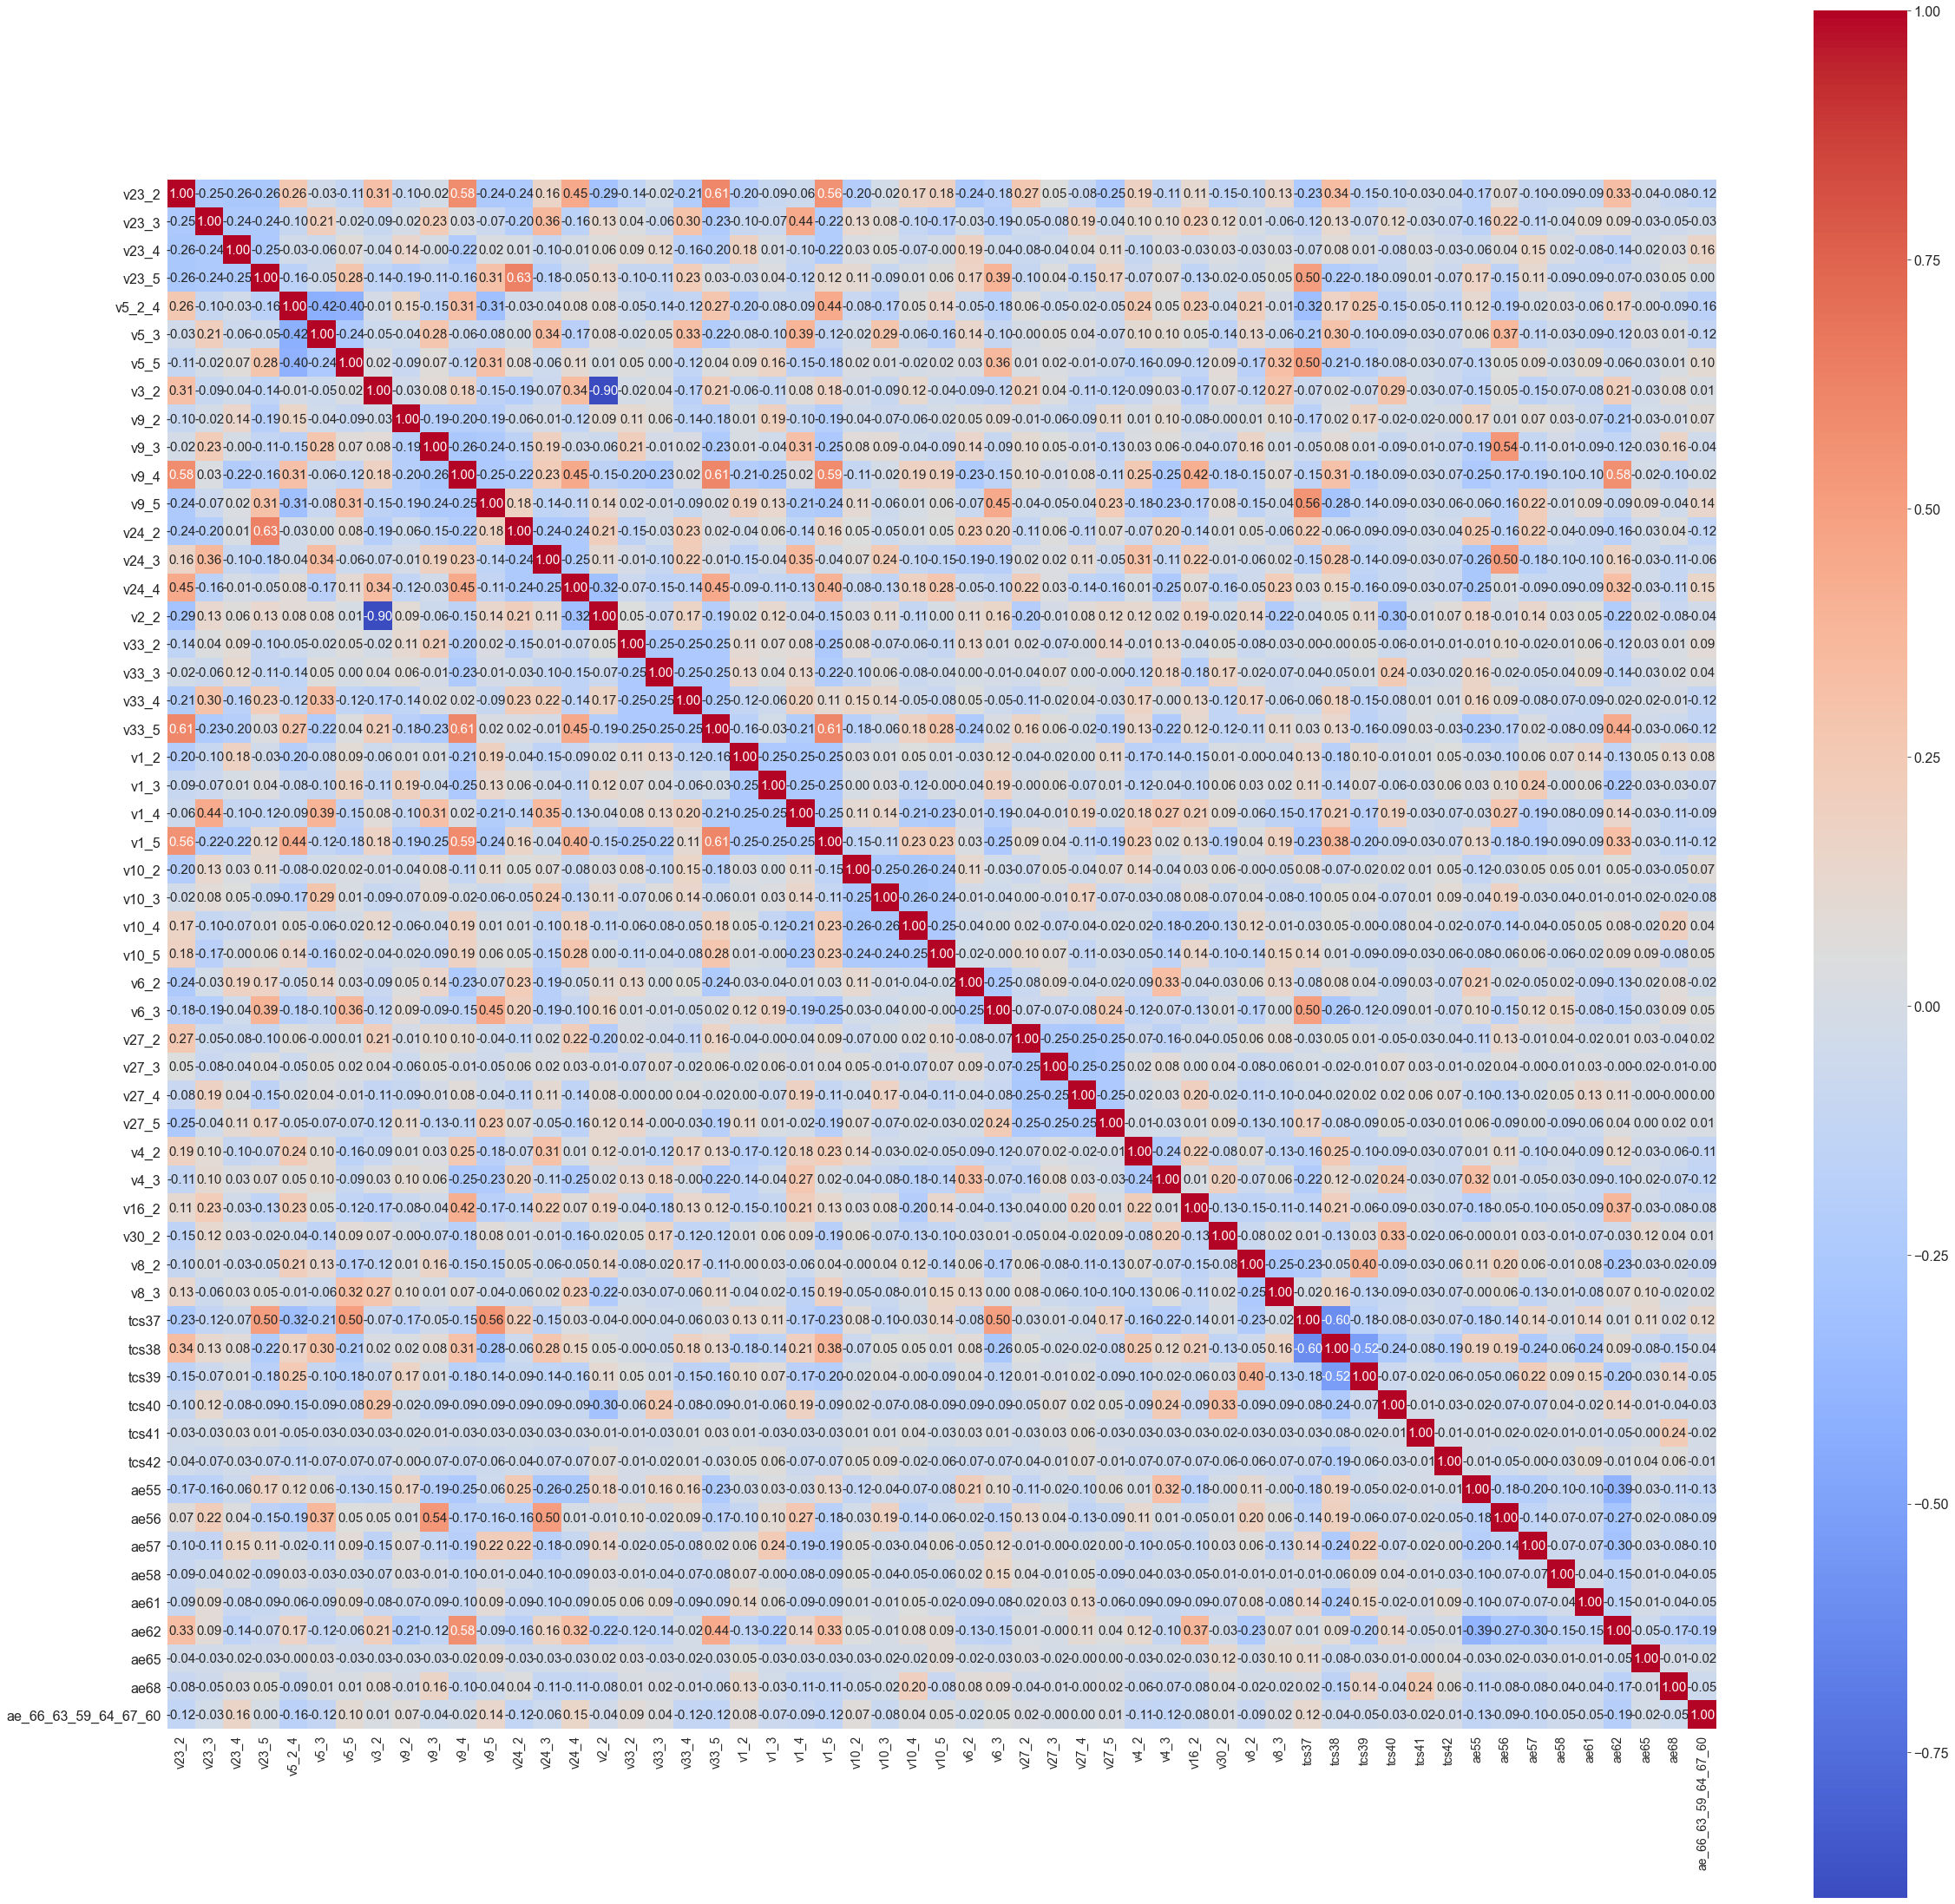

In [398]:
### Correlacion enre variables categoricas
corr_cat = data_train_ultimate.drop(['Moroso'],axis=1).corr(method='spearman')
plt.figure(figsize=(40,40))
sns.heatmap(corr_cat,cbar  =  True ,   square  =  True, annot=True,  fmt =  '.2f' , annot_kws = { 'size' :  15 },cmap =  'coolwarm')
plt.show()

In [399]:
# Eliminamos v2_2 por presentar una correlación muy alta con v3_2, además que de entre las dos, v2_2 posee el menor WoE
# Con esto tendríamos la data lista para introducirla al modelo
data_train_ultimate = data_train_ultimate.drop(['v2_2'],axis=1)
data_train_ultimate

Moroso  v23_2  v23_3  v23_4  v23_5  v5_2_4  v5_3  v5_5  v3_2  v9_2  ...  \
0        0.0      0      0      1      0       0     0     1     0     0  ...   
1        1.0      0      0      0      0       1     0     0     1     1  ...   
2        1.0      0      0      0      0       0     0     0     0     0  ...   
3        0.0      0      0      0      1       1     0     0     0     0  ...   
4        1.0      1      0      0      0       1     0     0     1     0  ...   
...      ...    ...    ...    ...    ...     ...   ...   ...   ...   ...  ...   
2184     0.0      0      0      1      0       0     1     0     0     0  ...   
2185     0.0      0      0      0      0       0     1     0     0     1  ...   
2186     0.0      0      0      0      0       0     0     0     0     0  ...   
2187     1.0      0      0      0      0       1     0     0     0     1  ...   
2188     0.0      0      1      0      0       0     1     0     0     0  ...   

      tcs42  ae55  ae56  ae57  ae58  ae61  ae62  ae65  ae68  \
0         0     0     1     0     0     0     0     0     0   
1         0     1     0     0     0     0     0     0     0   
2         1     0     0     0     0     1     0     0     0   
3         0     1     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     1     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   
2184      0     0     0     0     0     0     0     0     1   
2185      0     0     0     0     0     0     0     0     1   
2186      0     0     0     0     0     1     0     0     0   
2187      0     1     0     0     0     0     0     0     0   
2188      0     0     0     0     0     0     1     0     0   

      ae_66_63_59_64_67_60  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  
...                    ...  
2184                     0  
2185                     0  
2186                     0  
2187                     0  
2188                     0  

[2189 rows x 55 columns]

## Replicamos el proceso en el data_test

In [400]:
# Hacemos la operación inversa de get_dummies en el data test
var_cat_test = features_test.drop(vc,axis=1)
tsc_test = var_cat_test.iloc[:,range(0,6)]
tc_test = var_cat_test.iloc[:,range(6,17)]
dv_test = var_cat_test.iloc[:,range(17,18)]
ae_test = var_cat_test.iloc[:,range(18,32)]
d_test = var_cat_test.iloc[:,range(32,34)]
new_tsc_test = tsc_test.idxmax(axis=1)
new_tc_test = tc_test.idxmax(axis=1)
new_dv_test = dv_test.idxmax(axis=1)
new_ae_test = ae_test.idxmax(axis=1)
new_d_test = d_test.idxmax(axis=1)
new_var_cat_test = pd.DataFrame([new_tsc_test,new_tc_test,new_dv_test,new_ae_test,new_d_test]).T
new_var_cat_test.columns = ['tcs','tc','dv','ae','d']
new_var_cat_test

tcs    tc    dv    ae    d
0    tcs37  tc48  dv54  ae68  d69
1    tcs39  tc49  dv54  ae68  d69
2    tcs39  tc51  dv54  ae56  d69
3    tcs38  tc51  dv54  ae56  d69
4    tcs38  tc51  dv54  ae55  d69
..     ...   ...   ...   ...  ...
543  tcs38  tc49  dv54  ae56  d69
544  tcs38  tc49  dv54  ae62  d69
545  tcs37  tc49  dv54  ae61  d69
546  tcs38  tc51  dv54  ae55  d69
547  tcs38  tc51  dv54  ae62  d69

[548 rows x 5 columns]

In [401]:
# Creamos el data test a categorizar
data_test_before = pd.concat([features_test[vc],new_var_cat_test,label_test],axis=1)
data_test_before

v0           v1     v2    v3    v4            v5           v6   v7  \
0        0.00         0.10   29.0  71.0   0.0  4.206076e+07   2445379.88  0.0   
1        0.00         0.00  100.0   0.0   3.0  6.356591e+06   1151315.35  0.0   
2        0.00         0.00  100.0   0.0   0.0  1.834357e+08   8136692.18  0.0   
3        0.00    104207.83  100.0   0.0   0.0  7.515544e+07   4211350.00  0.0   
4    87791.71    460376.03   94.0   6.0  26.0  8.624776e+07  39737205.73  0.0   
..        ...          ...    ...   ...   ...           ...          ...  ...   
543      0.00    813216.41  100.0   0.0   0.0  1.642559e+07         0.00  0.0   
544      0.00     39690.33  100.0   0.0   0.0  7.174000e+07         0.00  0.0   
545      0.00     43754.09  100.0   0.0   0.0  9.366955e+07         0.00  0.0   
546      0.00  10484136.23  100.0   0.0   4.0  2.858129e+07    423747.53  0.0   
547      0.00   6324660.10  100.0   0.0   5.0  3.308427e+07         0.00  0.0   

             v8    v9  ...  v33   v34    v35   v36    tcs    tc    dv    ae  \
0     8000000.0  40.0  ...  179  30.0    1.0  30.0  tcs37  tc48  dv54  ae68   
1     3798381.6  24.0  ...   10  31.0   93.0  31.0  tcs39  tc49  dv54  ae68   
2     8000000.0   8.0  ...  905  31.0    1.0  31.0  tcs39  tc51  dv54  ae56   
3     6240000.0  17.0  ...  160  28.0    1.0  28.0  tcs38  tc51  dv54  ae56   
4     8000000.0  15.0  ...  326  31.0   62.0  31.0  tcs38  tc51  dv54  ae55   
..          ...   ...  ...  ...   ...    ...   ...    ...   ...   ...   ...   
543   3071719.0  23.0  ...  474  31.0    1.0  31.0  tcs38  tc49  dv54  ae56   
544  10000000.0   9.0  ...  222  30.0    1.0  30.0  tcs38  tc49  dv54  ae62   
545         0.0  45.0  ...  295  30.0    1.0  30.0  tcs37  tc49  dv54  ae61   
546   4500000.0  11.0  ...  689  31.0  123.0  31.0  tcs38  tc51  dv54  ae55   
547         0.0  24.0  ...  907  31.0  153.0  31.0  tcs38  tc51  dv54  ae62   

       d  Moroso  
0    d69     0.0  
1    d69     0.0  
2    d69     0.0  
3    d69     0.0  
4    d69     1.0  
..   ...     ...  
543  d69     0.0  
544  d69     0.0  
545  d69     0.0  
546  d69     0.0  
547  d69     0.0  

[548 rows x 43 columns]

In [402]:
cuantil0 = pd.DataFrame(data_train_before[vc].quantile(0))
cuantil1 = pd.DataFrame(data_train_before[vc].quantile(0.2))
cuantil2 = pd.DataFrame(data_train_before[vc].quantile(0.4))
cuantil3 = pd.DataFrame(data_train_before[vc].quantile(0.6))
cuantil4 = pd.DataFrame(data_train_before[vc].quantile(0.8))
cuantil5 = pd.DataFrame(data_train_before[vc].quantile(1))
cuantiles = pd.concat([cuantil0,cuantil1,cuantil2,cuantil3,cuantil4,cuantil5],axis=1)
cuantiles

0.0            0.2           0.4           0.6           0.8  \
v0   0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v1   0.0    4460.500000  6.758401e+04  9.502472e+05  5.914390e+06   
v2   0.0      78.000000  1.000000e+02  1.000000e+02  1.000000e+02   
v3   0.0       0.000000  0.000000e+00  0.000000e+00  9.000000e+00   
v4   0.0       0.000000  0.000000e+00  1.000000e+00  5.000000e+00   
v5   0.0  969808.192000  1.159741e+07  2.659397e+07  3.629251e+07   
v6   0.0       0.000000  0.000000e+00  3.649000e+05  4.405700e+06   
v7   0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v8   0.0       0.000000  0.000000e+00  2.338074e+05  6.240000e+06   
v9   1.0      11.000000  1.600000e+01  2.300000e+01  2.500000e+01   
v10  0.0     600.000000  6.610000e+02  7.430000e+02  7.970000e+02   
v11  0.0       6.000000  6.000000e+00  6.000000e+00  6.000000e+00   
v12  0.0       0.000000  0.000000e+00  2.412012e+05  6.096552e+05   
v13  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v14  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v15  0.0       0.000000  0.000000e+00  0.000000e+00  8.480000e+02   
v16  0.0       0.000000  0.000000e+00  0.000000e+00  8.480000e+02   
v17  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v18  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v19  0.0       0.000000  0.000000e+00  0.000000e+00  1.111372e+05   
v20  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v21  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v22  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v23  0.0    5344.279000  3.084651e+04  2.908663e+05  6.346511e+06   
v24  0.0       0.000000  3.560160e+04  2.908278e+06  1.428036e+07   
v25  0.0       0.000000  0.000000e+00  3.000000e+00  9.000000e+00   
v26  0.0      18.000000  2.260000e+02  4.200000e+02  8.080000e+02   
v27 -3.0      -1.343386 -8.162657e-01 -2.400000e-01  1.767993e+00   
v28  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v29  0.0       0.000000  0.000000e+00  0.000000e+00  1.000000e+02   
v30  0.0       0.000000  0.000000e+00  0.000000e+00  1.000000e+00   
v31  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v32  0.0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
v33  0.0      77.000000  2.310000e+02  4.660000e+02  7.860000e+02   
v34 -3.0      30.000000  3.100000e+01  3.100000e+01  3.100000e+01   
v35 -3.0       1.000000  1.000000e+00  1.000000e+00  9.200000e+01   
v36 -3.0      30.000000  3.100000e+01  3.100000e+01  3.100000e+01   

              1.0  
v0   5.030246e+06  
v1   1.257078e+07  
v2   1.000000e+02  
v3   1.000000e+02  
v4   1.830000e+02  
v5   3.283312e+09  
v6   4.415314e+08  
v7   2.427617e+06  
v8   1.000000e+07  
v9   1.150000e+02  
v10  9.360000e+02  
v11  6.000000e+00  
v12  2.834844e+08  
v13  5.991000e+03  
v14  4.127400e+04  
v15  8.612790e+05  
v16  1.730620e+05  
v17  2.400000e+01  
v18  1.076363e+07  
v19  5.117872e+06  
v20  1.413962e+06  
v21  6.200000e+01  
v22  1.450000e+02  
v23  1.357272e+09  
v24  6.301953e+08  
v25  3.800000e+01  
v26  4.138200e+04  
v27  8.083333e+00  
v28  1.000000e+02  
v29  1.000000e+02  
v30  1.650000e+02  
v31  1.000000e+02  
v32  1.000000e+02  
v33  1.286000e+03  
v34  7.310000e+02  
v35  1.280000e+03  
v36  7.310000e+02

In [403]:
# Categorizamos la data de testeo según se hizo en la data de entrenamiento

data_test_before = data_test_before[variables_IV['Variable'].array]
data_test_before['v23'] = np.where(data_test_before['v23'] <= cuantiles[0.2][23],'v23_1'
                                  ,np.where(data_test_before['v23'] <= cuantiles[0.4][23],'v23_2'
                                            ,np.where(data_test_before['v23'] <= cuantiles[0.6][23],'v23_3'
                                                      ,np.where(data_test_before['v23'] <= cuantiles[0.8][23],'v23_4'
                                                                ,'v23_5'))))

data_test_before['v5'] = np.where(data_test_before['v5'] <= cuantiles[0.2][5],'v5_1'
                                  ,np.where(data_test_before['v5'] <= cuantiles[0.4][5],'v5_2'
                                            ,np.where(data_test_before['v5'] <= cuantiles[0.6][5],'v5_3'
                                                      ,np.where(data_test_before['v5'] <= cuantiles[0.8][5],'v5_4'
                                                                ,'v5_5'))))

data_test_before['v3'] = np.where(data_test_before['v3'] <= cuantiles[0.8][3],'v3_1','v3_2')

data_test_before['v9'] = np.where(data_test_before['v9'] <= cuantiles[0.2][9],'v9_1'
                                  ,np.where(data_test_before['v9'] <= cuantiles[0.4][9],'v9_2'
                                            ,np.where(data_test_before['v9'] <= cuantiles[0.6][9],'v9_3'
                                                      ,np.where(data_test_before['v9'] <= cuantiles[0.8][9],'v9_4'
                                                                ,'v9_5'))))

data_test_before['v24'] = np.where(data_test_before['v24'] <= cuantiles[0.4][24],'v24_1'
                                  ,np.where(data_test_before['v24'] <= cuantiles[0.6][24],'v24_2'
                                            ,np.where(data_test_before['v24'] <= cuantiles[0.8][24],'v24_3'
                                                      ,'v24_4')))

data_test_before['v2'] = np.where(data_test_before['v2'] <= cuantiles[0.2][2],'v2_1','v2_2')

data_test_before['v33'] = np.where(data_test_before['v33'] <= cuantiles[0.2][33],'v33_1'
                                  ,np.where(data_test_before['v33'] <= cuantiles[0.4][33],'v33_2'
                                            ,np.where(data_test_before['v33'] <= cuantiles[0.6][33],'v33_3'
                                                      ,np.where(data_test_before['v33'] <= cuantiles[0.8][33],'v33_4'
                                                                ,'v33_5'))))

data_test_before['v1'] = np.where(data_test_before['v1'] <= cuantiles[0.2][1],'v1_1'
                                  ,np.where(data_test_before['v1'] <= cuantiles[0.4][1],'v1_2'
                                            ,np.where(data_test_before['v1'] <= cuantiles[0.6][1],'v1_3'
                                                      ,np.where(data_test_before['v1'] <= cuantiles[0.8][1],'v1_4'
                                                                ,'v1_5'))))

data_test_before['v10'] = np.where(data_test_before['v10'] <= cuantiles[0.2][10],'v10_1'
                                  ,np.where(data_test_before['v10'] <= cuantiles[0.4][10],'v10_2'
                                            ,np.where(data_test_before['v10'] <= cuantiles[0.6][10],'v10_3'
                                                      ,np.where(data_test_before['v10'] <= cuantiles[0.8][10],'v10_4'
                                                                ,'v10_5'))))

data_test_before['v6'] = np.where(data_test_before['v6'] <= cuantiles[0.6][6],'v6_1'
                                  ,np.where(data_test_before['v6'] <= cuantiles[0.8][6],'v6_2'
                                            ,'v6_3'))

data_test_before['v27'] = np.where(data_test_before['v27'] <= cuantiles[0.2][27],'v27_1'
                                  ,np.where(data_test_before['v27'] <= cuantiles[0.4][27],'v27_2'
                                            ,np.where(data_test_before['v27'] <= cuantiles[0.6][27],'v27_3'
                                                      ,np.where(data_test_before['v27'] <= cuantiles[0.8][27],'v27_4'
                                                                ,'v27_5'))))

data_test_before['v4'] = np.where(data_test_before['v4'] <= cuantiles[0.6][4],'v4_1'
                                  ,np.where(data_test_before['v4'] <= cuantiles[0.8][4],'v4_2'
                                            ,'v4_3'))

data_test_before['v16'] = np.where(data_test_before['v16'] <= cuantiles[0.8][16],'v16_1','v16_2')

data_test_before['v30'] = np.where(data_test_before['v30'] <= cuantiles[0.8][30],'v30_1','v30_2')

data_test_before['v8'] = np.where(data_test_before['v8'] <= cuantiles[0.6][8],'v8_1'
                                  ,np.where(data_test_before['v8'] <= cuantiles[0.8][8],'v8_2'
                                            ,'v8_3'))
data_test_before

v23    v5    tcs    v3    v9    v24    v2    v33    v1    v10    ae  \
0    v23_5  v5_5  tcs37  v3_2  v9_5  v24_2  v2_1  v33_2  v1_1  v10_4  ae68   
1    v23_1  v5_2  tcs39  v3_1  v9_4  v24_1  v2_2  v33_1  v1_1  v10_3  ae68   
2    v23_5  v5_5  tcs39  v3_1  v9_1  v24_4  v2_2  v33_5  v1_1  v10_2  ae56   
3    v23_4  v5_5  tcs38  v3_1  v9_3  v24_4  v2_2  v33_2  v1_3  v10_3  ae56   
4    v23_2  v5_5  tcs38  v3_1  v9_2  v24_1  v2_2  v33_3  v1_3  v10_1  ae55   
..     ...   ...    ...   ...   ...    ...   ...    ...   ...    ...   ...   
543  v23_3  v5_3  tcs38  v3_1  v9_3  v24_3  v2_2  v33_4  v1_3  v10_3  ae56   
544  v23_4  v5_5  tcs38  v3_1  v9_1  v24_3  v2_2  v33_2  v1_2  v10_3  ae62   
545  v23_3  v5_5  tcs37  v3_1  v9_5  v24_1  v2_2  v33_3  v1_2  v10_5  ae61   
546  v23_5  v5_4  tcs38  v3_1  v9_1  v24_2  v2_2  v33_4  v1_5  v10_2  ae55   
547  v23_2  v5_4  tcs38  v3_1  v9_4  v24_4  v2_2  v33_5  v1_5  v10_5  ae62   

       v6    v27    v4    v16    v30    v8  
0    v6_2  v27_1  v4_1  v16_1  v30_1  v8_3  
1    v6_2  v27_2  v4_2  v16_1  v30_1  v8_2  
2    v6_3  v27_2  v4_1  v16_1  v30_2  v8_3  
3    v6_2  v27_3  v4_1  v16_1  v30_1  v8_2  
4    v6_3  v27_2  v4_3  v16_1  v30_1  v8_3  
..    ...    ...   ...    ...    ...   ...  
543  v6_1  v27_3  v4_1  v16_1  v30_1  v8_2  
544  v6_1  v27_2  v4_1  v16_1  v30_1  v8_3  
545  v6_1  v27_4  v4_1  v16_1  v30_1  v8_1  
546  v6_2  v27_1  v4_2  v16_1  v30_1  v8_2  
547  v6_1  v27_3  v4_2  v16_2  v30_1  v8_1  

[548 rows x 17 columns]

In [404]:
data_test_after = data_test_before.copy()
data_test_after['v5'].replace({ 'v5_2': 'v5_2_4', 'v5_4': 'v5_2_4'}, inplace=True)
data_test_after['ae'].replace({ 'ae66': 'ae_66_63_59_64_67_60', 'ae63': 'ae_66_63_59_64_67_60', 'ae59': 'ae_66_63_59_64_67_60', 'ae64': 'ae_66_63_59_64_67_60', 'ae67': 'ae_66_63_59_64_67_60', 'ae60': 'ae_66_63_59_64_67_60'}, inplace=True)
data_test_after

v23      v5    tcs    v3    v9    v24    v2    v33    v1    v10    ae  \
0    v23_5    v5_5  tcs37  v3_2  v9_5  v24_2  v2_1  v33_2  v1_1  v10_4  ae68   
1    v23_1  v5_2_4  tcs39  v3_1  v9_4  v24_1  v2_2  v33_1  v1_1  v10_3  ae68   
2    v23_5    v5_5  tcs39  v3_1  v9_1  v24_4  v2_2  v33_5  v1_1  v10_2  ae56   
3    v23_4    v5_5  tcs38  v3_1  v9_3  v24_4  v2_2  v33_2  v1_3  v10_3  ae56   
4    v23_2    v5_5  tcs38  v3_1  v9_2  v24_1  v2_2  v33_3  v1_3  v10_1  ae55   
..     ...     ...    ...   ...   ...    ...   ...    ...   ...    ...   ...   
543  v23_3    v5_3  tcs38  v3_1  v9_3  v24_3  v2_2  v33_4  v1_3  v10_3  ae56   
544  v23_4    v5_5  tcs38  v3_1  v9_1  v24_3  v2_2  v33_2  v1_2  v10_3  ae62   
545  v23_3    v5_5  tcs37  v3_1  v9_5  v24_1  v2_2  v33_3  v1_2  v10_5  ae61   
546  v23_5  v5_2_4  tcs38  v3_1  v9_1  v24_2  v2_2  v33_4  v1_5  v10_2  ae55   
547  v23_2  v5_2_4  tcs38  v3_1  v9_4  v24_4  v2_2  v33_5  v1_5  v10_5  ae62   

       v6    v27    v4    v16    v30    v8  
0    v6_2  v27_1  v4_1  v16_1  v30_1  v8_3  
1    v6_2  v27_2  v4_2  v16_1  v30_1  v8_2  
2    v6_3  v27_2  v4_1  v16_1  v30_2  v8_3  
3    v6_2  v27_3  v4_1  v16_1  v30_1  v8_2  
4    v6_3  v27_2  v4_3  v16_1  v30_1  v8_3  
..    ...    ...   ...    ...    ...   ...  
543  v6_1  v27_3  v4_1  v16_1  v30_1  v8_2  
544  v6_1  v27_2  v4_1  v16_1  v30_1  v8_3  
545  v6_1  v27_4  v4_1  v16_1  v30_1  v8_1  
546  v6_2  v27_1  v4_2  v16_1  v30_1  v8_2  
547  v6_1  v27_3  v4_2  v16_2  v30_1  v8_1  

[548 rows x 17 columns]

In [405]:
variables_RLog = variables_IV.copy()
variables_RLog = variables_RLog['Variable'].array
data_test_after = data_test_after[variables_RLog]
data_test_after = pd.concat([data_test_after,label_test],axis=1)
data_test_after

v23      v5    tcs    v3    v9    v24    v2    v33    v1    v10    ae  \
0    v23_5    v5_5  tcs37  v3_2  v9_5  v24_2  v2_1  v33_2  v1_1  v10_4  ae68   
1    v23_1  v5_2_4  tcs39  v3_1  v9_4  v24_1  v2_2  v33_1  v1_1  v10_3  ae68   
2    v23_5    v5_5  tcs39  v3_1  v9_1  v24_4  v2_2  v33_5  v1_1  v10_2  ae56   
3    v23_4    v5_5  tcs38  v3_1  v9_3  v24_4  v2_2  v33_2  v1_3  v10_3  ae56   
4    v23_2    v5_5  tcs38  v3_1  v9_2  v24_1  v2_2  v33_3  v1_3  v10_1  ae55   
..     ...     ...    ...   ...   ...    ...   ...    ...   ...    ...   ...   
543  v23_3    v5_3  tcs38  v3_1  v9_3  v24_3  v2_2  v33_4  v1_3  v10_3  ae56   
544  v23_4    v5_5  tcs38  v3_1  v9_1  v24_3  v2_2  v33_2  v1_2  v10_3  ae62   
545  v23_3    v5_5  tcs37  v3_1  v9_5  v24_1  v2_2  v33_3  v1_2  v10_5  ae61   
546  v23_5  v5_2_4  tcs38  v3_1  v9_1  v24_2  v2_2  v33_4  v1_5  v10_2  ae55   
547  v23_2  v5_2_4  tcs38  v3_1  v9_4  v24_4  v2_2  v33_5  v1_5  v10_5  ae62   

       v6    v27    v4    v16    v30    v8  Moroso  
0    v6_2  v27_1  v4_1  v16_1  v30_1  v8_3     0.0  
1    v6_2  v27_2  v4_2  v16_1  v30_1  v8_2     0.0  
2    v6_3  v27_2  v4_1  v16_1  v30_2  v8_3     0.0  
3    v6_2  v27_3  v4_1  v16_1  v30_1  v8_2     0.0  
4    v6_3  v27_2  v4_3  v16_1  v30_1  v8_3     1.0  
..    ...    ...   ...    ...    ...   ...     ...  
543  v6_1  v27_3  v4_1  v16_1  v30_1  v8_2     0.0  
544  v6_1  v27_2  v4_1  v16_1  v30_1  v8_3     0.0  
545  v6_1  v27_4  v4_1  v16_1  v30_1  v8_1     0.0  
546  v6_2  v27_1  v4_2  v16_1  v30_1  v8_2     0.0  
547  v6_1  v27_3  v4_2  v16_2  v30_1  v8_1     0.0  

[548 rows x 18 columns]

In [406]:
variables_RLog = variables_IV.copy()
variables_RLog = variables_RLog.drop([37,40],axis=0)['Variable'].array
data_test_ultimate = data_test_after.copy()
for v in variables_RLog:
    v_dummies = pd.get_dummies(data_test_ultimate[v],drop_first=True)
    data_test_ultimate = pd.concat([data_test_ultimate,v_dummies],axis=1)
data_test_ultimate=data_test_ultimate.drop(variables_RLog,axis=1) 
tcs_test_dummie = pd.get_dummies(data_test_ultimate['tcs'],drop_first=False)
ae_test_dummie = pd.get_dummies(data_test_ultimate['ae'],drop_first=False)
data_test_ultimate = pd.concat([data_test_ultimate,tcs_test_dummie,ae_test_dummie],axis=1)
data_test_ultimate = data_test_ultimate.drop(['tcs','ae'],axis=1)
data_test_ultimate

Moroso  v23_2  v23_3  v23_4  v23_5  v5_2_4  v5_3  v5_5  v3_2  v9_2  ...  \
0       0.0      0      0      0      1       0     0     1     1     0  ...   
1       0.0      0      0      0      0       1     0     0     0     0  ...   
2       0.0      0      0      0      1       0     0     1     0     0  ...   
3       0.0      0      0      1      0       0     0     1     0     0  ...   
4       1.0      1      0      0      0       0     0     1     0     1  ...   
..      ...    ...    ...    ...    ...     ...   ...   ...   ...   ...  ...   
543     0.0      0      1      0      0       0     1     0     0     0  ...   
544     0.0      0      0      1      0       0     0     1     0     0  ...   
545     0.0      0      1      0      0       0     0     1     0     0  ...   
546     0.0      0      0      0      1       1     0     0     0     0  ...   
547     0.0      1      0      0      0       1     0     0     0     0  ...   

     tcs42  ae55  ae56  ae57  ae58  ae61  ae62  ae65  ae68  \
0        0     0     0     0     0     0     0     0     1   
1        0     0     0     0     0     0     0     0     1   
2        0     0     1     0     0     0     0     0     0   
3        0     0     1     0     0     0     0     0     0   
4        0     1     0     0     0     0     0     0     0   
..     ...   ...   ...   ...   ...   ...   ...   ...   ...   
543      0     0     1     0     0     0     0     0     0   
544      0     0     0     0     0     0     1     0     0   
545      0     0     0     0     0     1     0     0     0   
546      0     1     0     0     0     0     0     0     0   
547      0     0     0     0     0     0     1     0     0   

     ae_66_63_59_64_67_60  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
..                    ...  
543                     0  
544                     0  
545                     0  
546                     0  
547                     0  

[548 rows x 56 columns]

In [407]:
data_test_ultimate = data_test_ultimate.drop(['v2_2'],axis=1)
data_test_ultimate

Moroso  v23_2  v23_3  v23_4  v23_5  v5_2_4  v5_3  v5_5  v3_2  v9_2  ...  \
0       0.0      0      0      0      1       0     0     1     1     0  ...   
1       0.0      0      0      0      0       1     0     0     0     0  ...   
2       0.0      0      0      0      1       0     0     1     0     0  ...   
3       0.0      0      0      1      0       0     0     1     0     0  ...   
4       1.0      1      0      0      0       0     0     1     0     1  ...   
..      ...    ...    ...    ...    ...     ...   ...   ...   ...   ...  ...   
543     0.0      0      1      0      0       0     1     0     0     0  ...   
544     0.0      0      0      1      0       0     0     1     0     0  ...   
545     0.0      0      1      0      0       0     0     1     0     0  ...   
546     0.0      0      0      0      1       1     0     0     0     0  ...   
547     0.0      1      0      0      0       1     0     0     0     0  ...   

     tcs42  ae55  ae56  ae57  ae58  ae61  ae62  ae65  ae68  \
0        0     0     0     0     0     0     0     0     1   
1        0     0     0     0     0     0     0     0     1   
2        0     0     1     0     0     0     0     0     0   
3        0     0     1     0     0     0     0     0     0   
4        0     1     0     0     0     0     0     0     0   
..     ...   ...   ...   ...   ...   ...   ...   ...   ...   
543      0     0     1     0     0     0     0     0     0   
544      0     0     0     0     0     0     1     0     0   
545      0     0     0     0     0     1     0     0     0   
546      0     1     0     0     0     0     0     0     0   
547      0     0     0     0     0     0     1     0     0   

     ae_66_63_59_64_67_60  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
..                    ...  
543                     0  
544                     0  
545                     0  
546                     0  
547                     0  

[548 rows x 55 columns]

In [408]:
data_test_ultimate.columns

Index(['Moroso', 'v23_2', 'v23_3', 'v23_4', 'v23_5', 'v5_2_4', 'v5_3', 'v5_5',
       'v3_2', 'v9_2', 'v9_3', 'v9_4', 'v9_5', 'v24_2', 'v24_3', 'v24_4',
       'v33_2', 'v33_3', 'v33_4', 'v33_5', 'v1_2', 'v1_3', 'v1_4', 'v1_5',
       'v10_2', 'v10_3', 'v10_4', 'v10_5', 'v6_2', 'v6_3', 'v27_2', 'v27_3',
       'v27_4', 'v27_5', 'v4_2', 'v4_3', 'v16_2', 'v30_2', 'v8_2', 'v8_3',
       'tcs37', 'tcs38', 'tcs39', 'tcs40', 'tcs41', 'tcs42', 'ae55', 'ae56',
       'ae57', 'ae58', 'ae61', 'ae62', 'ae65', 'ae68', 'ae_66_63_59_64_67_60'],
      dtype='object')

In [409]:
data_train_ultimate.columns

Index(['Moroso', 'v23_2', 'v23_3', 'v23_4', 'v23_5', 'v5_2_4', 'v5_3', 'v5_5',
       'v3_2', 'v9_2', 'v9_3', 'v9_4', 'v9_5', 'v24_2', 'v24_3', 'v24_4',
       'v33_2', 'v33_3', 'v33_4', 'v33_5', 'v1_2', 'v1_3', 'v1_4', 'v1_5',
       'v10_2', 'v10_3', 'v10_4', 'v10_5', 'v6_2', 'v6_3', 'v27_2', 'v27_3',
       'v27_4', 'v27_5', 'v4_2', 'v4_3', 'v16_2', 'v30_2', 'v8_2', 'v8_3',
       'tcs37', 'tcs38', 'tcs39', 'tcs40', 'tcs41', 'tcs42', 'ae55', 'ae56',
       'ae57', 'ae58', 'ae61', 'ae62', 'ae65', 'ae68', 'ae_66_63_59_64_67_60'],
      dtype='object')

### Data sin Balancear

## LGBM

In [410]:
## Usando la mejor selección de variables
bestLGBM_X_train = X_train[variables_LGBM]
bestLGBM_X_test = X_test[variables_LGBM]

In [411]:
bestLGBM_X_train.shape

(2189, 23)

In [412]:
from time import time
# construimos un lightgbm
best_model_LGBM4 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8)
best_model_LGBM4.fit(bestLGBM_X_train, y_train)

# predecimos el train y test con la probabilidad para validar 
predict_train_lg4 = best_model_LGBM4.predict_proba(bestLGBM_X_train)[:,1]
predict_test_lg4 = best_model_LGBM4.predict_proba(bestLGBM_X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg4)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg4)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.969
auc o Roc on testing in LGBMClassifier data : 0.955


In [413]:
predictions_train_LGBM4 = best_model_LGBM4.predict(bestLGBM_X_train)
predictions_test_LGBM4 = best_model_LGBM4.predict(bestLGBM_X_test)
print(roc_auc_score(y_train, predictions_train_LGBM4))
print(roc_auc_score(y_test, predictions_test_LGBM4))
print(confusion_matrix(y_test, predictions_test_LGBM4))

0.8754152097902098
0.8788299663299664
[[423  17]
 [ 22  86]]


In [415]:
print("Accuracy of LGBM:",roc_auc_score(y_test,predictions_test_LGBM4)*100,'\n')
print(classification_report(y_test,predictions_test_LGBM4))

Accuracy of LGBM: 87.88299663299664 

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       440
         1.0       0.83      0.80      0.82       108

    accuracy                           0.93       548
   macro avg       0.89      0.88      0.89       548
weighted avg       0.93      0.93      0.93       548



## XGBOOST

In [416]:
## Usando la mejor selección de variables
bestXGB_X_train = X_train[variables_XGB]
bestXGB_X_test = X_test[variables_XGB]

In [417]:
bestXGB_X_train.shape

(2189, 25)

In [418]:
from time import time
# construimos un xgb
best_model_XGB3 = XGBClassifier(objective = 'binary:logistic',learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB3.fit(bestXGB_X_train, y_train)

# predecimos el train y test con la probabilidad para validar 
predict_train_xg3 = best_model_XGB3.predict_proba(bestXGB_X_train)[:,1]
predict_test_xg3 = best_model_XGB3.predict_proba(bestXGB_X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_xg3)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_xg3)))

[10:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.964
auc o Roc on testing in LGBMClassifier data : 0.957


In [419]:
predictions_train_XGB3 = best_model_XGB3.predict(bestXGB_X_train)
predictions_test_XGB3 = best_model_XGB3.predict(bestXGB_X_test)
print(roc_auc_score(y_train, predictions_train_XGB3))
print(roc_auc_score(y_test, predictions_test_XGB3))
print(confusion_matrix(y_test, predictions_test_XGB3))

0.8460227272727272
0.8730639730639732
[[422  18]
 [ 23  85]]


In [421]:
print("Accuracy of XGB:",roc_auc_score(y_test,predictions_test_XGB3)*100,'\n')
print(classification_report(y_test,predictions_test_XGB3))

Accuracy of XGB: 87.30639730639732 

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       440
         1.0       0.83      0.79      0.81       108

    accuracy                           0.93       548
   macro avg       0.89      0.87      0.88       548
weighted avg       0.92      0.93      0.92       548



## Regresión Logística 

In [422]:
## Usando la mejor selección de variables
bestRLog_X_train = data_train_ultimate.drop('Moroso',axis=1)
bestRLog_X_test = data_test_ultimate.drop('Moroso',axis=1)

Lasso

In [423]:
logmodel10 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel10.fit(bestRLog_X_train,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [424]:
print("Weights:")
print("\tB0 =", logmodel10.intercept_[0])
for i, b in enumerate(logmodel10.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = 0.0
	B1 =-0.730075580426692
	B2 =-0.5929387911267522
	B3 =-1.8327547081146662
	B4 =-2.3785579594954425
	B5 =-0.2941284857457693
	B6 =-1.3139262652920953
	B7 =0.8183784318636769
	B8 =1.4119565058945163
	B9 =0.0
	B10 =-0.9161392023520945
	B11 =1.0305726401306232
	B12 =0.0
	B13 =0.5013995950034154
	B14 =-1.2730142220007727
	B15 =-0.2710154450856603
	B16 =0.0
	B17 =-0.25035029679206294
	B18 =0.0
	B19 =0.5697913127899741
	B20 =-0.3950551243641438
	B21 =1.2241186031231934
	B22 =0.9826946564818798
	B23 =0.24334657204250135
	B24 =-1.5903061817865831
	B25 =-0.9092748662727654
	B26 =-1.0563028226125264
	B27 =-0.7981590949728353
	B28 =-0.022395460069445306
	B29 =0.6062392198548957
	B30 =-0.0804169572847712
	B31 =-0.2677111856266459
	B32 =-1.1520396789915985
	B33 =-0.2507475809361204
	B34 =0.09835119106119622
	B35 =0.16229746898459024
	B36 =-0.479604537208506
	B37 =0.8447574659598859
	B38 =-0.3499673995093196
	B39 =0.6488402617512147
	B40 =-2.1211134283832043
	B41 =-1.34779330560835

In [425]:
predictions_train_RL10 = logmodel10.predict(bestRLog_X_train)
predictions_test_RL10 = logmodel10.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL10))
print(roc_auc_score(y_test,predictions_test_RL10))
print(confusion_matrix(y_test, predictions_test_RL10))

0.7761509324009325
0.7886784511784513
[[417  23]
 [ 40  68]]


In [426]:
print(roc_auc_score(y_train,logmodel10.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel10.predict_proba(bestRLog_X_test)[:,1]))

0.9244867821572367
0.9206018518518517


In [428]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL10)*100,'\n')
print(classification_report(y_test,predictions_test_RL10))

Accuracy of Logistic Regression: 78.86784511784512 

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       440
         1.0       0.75      0.63      0.68       108

    accuracy                           0.89       548
   macro avg       0.83      0.79      0.81       548
weighted avg       0.88      0.89      0.88       548



Ridge

In [429]:
logmodel11 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel11.fit(bestRLog_X_train,y_train)

LogisticRegression(max_iter=1000)

In [430]:
print("Weights:")
print("\tB0 =", logmodel11.intercept_[0])
for i, b in enumerate(logmodel11.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -0.11457866454241135
	B1 =-0.7147300863516781
	B2 =-0.5710294327190608
	B3 =-1.7019965562870947
	B4 =-2.1668391522037815
	B5 =-0.3661394929039278
	B6 =-1.2666012903592598
	B7 =0.7316405394135372
	B8 =1.3859600251613196
	B9 =0.0419221744545562
	B10 =-0.8564994817010694
	B11 =1.0104091058036218
	B12 =-0.06560470604109386
	B13 =0.42661968331183464
	B14 =-1.277750918924229
	B15 =-0.3557775570248951
	B16 =0.012164475665005796
	B17 =-0.3029520668416006
	B18 =-0.0342854725012854
	B19 =0.5693387257669855
	B20 =-0.43080669850407655
	B21 =1.222427073903062
	B22 =0.9342969513861616
	B23 =0.34771427378307757
	B24 =-1.5505480266007952
	B25 =-0.8714484268439925
	B26 =-1.0042033420027983
	B27 =-0.7727488505194067
	B28 =-0.1255302038656176
	B29 =0.5787184081689181
	B30 =-0.14523935072529498
	B31 =-0.36781458949095
	B32 =-1.2237071228666478
	B33 =-0.3771629710865006
	B34 =0.16281630435875927
	B35 =0.22079934135396756
	B36 =-0.5051582124747628
	B37 =0.8636260941564364
	B38 =-0.37868773658

In [431]:
predictions_train_RL11 = logmodel11.predict(bestRLog_X_train)
predictions_test_RL11 = logmodel11.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL11))
print(roc_auc_score(y_test,predictions_test_RL11))
print(confusion_matrix(y_test, predictions_test_RL11))

0.7793633449883451
0.7886784511784513
[[417  23]
 [ 40  68]]


In [432]:
print(roc_auc_score(y_train,logmodel11.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel11.predict_proba(bestRLog_X_test)[:,1]))

0.9236987444373808
0.9207702020202019


In [434]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL11)*100,'\n')
print(classification_report(y_test,predictions_test_RL11))

Accuracy of Logistic Regression: 78.86784511784512 

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       440
         1.0       0.75      0.63      0.68       108

    accuracy                           0.89       548
   macro avg       0.83      0.79      0.81       548
weighted avg       0.88      0.89      0.88       548



ElasticNet

In [435]:
logmodel12 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel12.fit(bestRLog_X_train,y_train)

LogisticRegression(l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [436]:
print("Weights:")
print("\tB0 =", logmodel12.intercept_[0])
for i, b in enumerate(logmodel12.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = 0.0783123078314838
	B1 =-0.7264504174684905
	B2 =-0.5933475982643088
	B3 =-1.822656626501707
	B4 =-2.352573035665526
	B5 =-0.3037239228808289
	B6 =-1.3170845279062546
	B7 =0.802018084223667
	B8 =1.404016068989056
	B9 =0.0
	B10 =-0.9176628246170766
	B11 =1.0273097102165873
	B12 =0.0
	B13 =0.48818954588077207
	B14 =-1.3008561686475326
	B15 =-0.2981999276686195
	B16 =0.0
	B17 =-0.2549901970181993
	B18 =0.0
	B19 =0.568570771443075
	B20 =-0.4013399887646519
	B21 =1.2210502893207775
	B22 =0.9801887957111846
	B23 =0.26233047647971647
	B24 =-1.5912694526166804
	B25 =-0.9152138750144032
	B26 =-1.0619472166829171
	B27 =-0.8083339395412938
	B28 =-0.03376886882328418
	B29 =0.6018816523773372
	B30 =-0.09312232707267055
	B31 =-0.2847575731731987
	B32 =-1.1661250137582742
	B33 =-0.27428384843886927
	B34 =0.10365928608765729
	B35 =0.15813106698602156
	B36 =-0.4861202894229175
	B37 =0.8364715270980245
	B38 =-0.35745092368376546
	B39 =0.6412012952091168
	B40 =-2.118674192647003
	B41 =-1.3

In [437]:
predictions_train_RL12 = logmodel12.predict(bestRLog_X_train)
predictions_test_RL12 = logmodel12.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL12))
print(roc_auc_score(y_test,predictions_test_RL12))
print(confusion_matrix(y_test, predictions_test_RL12))

0.7758668414918416
0.7886784511784513
[[417  23]
 [ 40  68]]


In [438]:
print(roc_auc_score(y_train,logmodel12.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel12.predict_proba(bestRLog_X_test)[:,1]))

0.9244338048315321
0.9206439393939394


In [440]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL12)*100,'\n')
print(classification_report(y_test,predictions_test_RL12))

Accuracy of Logistic Regression: 78.86784511784512 

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       440
         1.0       0.75      0.63      0.68       108

    accuracy                           0.89       548
   macro avg       0.83      0.79      0.81       548
weighted avg       0.88      0.89      0.88       548



- Podemos notar una mejora notable en los modelos de regresión logística después del procedimiento WoE, tanto en el F1 Score como en el Accuracy y el AUC, además que hay estabilidad tanto en la prueba como en el testeo.

### Data Balanceada

Balancear los datos por oversampling

In [441]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [442]:
pip install delayed

Note: you may need to restart the kernel to use updated packages.


In [443]:
from imblearn.over_sampling import SMOTE

In [444]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({0.0: 1760, 1.0: 429})


### Selector LGBM

In [445]:
os2 = SMOTE(random_state = 0)

In [446]:
os_data_X2, os_data_y2 = os2.fit_resample(bestLGBM_X_train.values, y_train.values)

In [447]:
counter2 = Counter(os_data_y2)
print(counter2)

Counter({0.0: 1760, 1.0: 1760})


### Selector XGB

In [448]:
os3 = SMOTE(random_state = 0)

In [449]:
os_data_X3, os_data_y3 = os3.fit_resample(bestXGB_X_train.values, y_train.values)

In [450]:
counter3 = Counter(os_data_y3)
print(counter3)

Counter({0.0: 1760, 1.0: 1760})


### Selector RLog

In [451]:
os4 = SMOTE(random_state = 0)

In [452]:
os_data_X4, os_data_y4 = os4.fit_resample(bestRLog_X_train.values, y_train.values)

In [453]:
counter4 = Counter(os_data_y4)
print(counter4)

Counter({0.0: 1760, 1.0: 1760})


## LGBM

### Forma 1

In [454]:
from time import time
# construimos un lightgbm
best_model_LGBM5 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8,class_weight='balanced')
best_model_LGBM5.fit(bestLGBM_X_train, y_train)

# predecimos el train y test con la probabilidad para validar
predict_train_lg5 = best_model_LGBM5.predict_proba(bestLGBM_X_train)[:,1]
predict_test_lg5 = best_model_LGBM5.predict_proba(bestLGBM_X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg5)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg5)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.970
auc o Roc on testing in LGBMClassifier data : 0.957


In [455]:
predictions_train_LGBM5 = best_model_LGBM5.predict(bestLGBM_X_train)
predictions_test_LGBM5 = best_model_LGBM5.predict(bestLGBM_X_test)
print(roc_auc_score(y_train, predictions_train_LGBM5))
print(roc_auc_score(y_test, predictions_test_LGBM5))
print(confusion_matrix(y_test, predictions_test_LGBM5))

0.9185314685314686
0.8912037037037037
[[385  55]
 [ 10  98]]


In [457]:
print("Accuracy of LGBM:",roc_auc_score(y_test,predictions_test_LGBM5)*100,'\n')
print(classification_report(y_test,predictions_test_LGBM5))

Accuracy of LGBM: 89.12037037037037 

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       440
         1.0       0.64      0.91      0.75       108

    accuracy                           0.88       548
   macro avg       0.81      0.89      0.84       548
weighted avg       0.91      0.88      0.89       548



### Forma 2

In [458]:
from time import time
# construimos un lightgbm
best_model_LGBM6 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8)
best_model_LGBM6.fit(os_data_X2, os_data_y2)

# predecimos el train y test con la probabilidad para validar
predict_train_lg6 = best_model_LGBM6.predict_proba(bestLGBM_X_train)[:,1]
predict_test_lg6 = best_model_LGBM6.predict_proba(bestLGBM_X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg6)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg6)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.964
auc o Roc on testing in LGBMClassifier data : 0.955


In [459]:
predictions_train_LGBM6 = best_model_LGBM6.predict(bestLGBM_X_train)
predictions_test_LGBM6 = best_model_LGBM6.predict(bestLGBM_X_test)
print(roc_auc_score(y_train, predictions_train_LGBM6))
print(roc_auc_score(y_test, predictions_test_LGBM6))
print(confusion_matrix(y_test, predictions_test_LGBM6))

0.9031177156177156
0.8875420875420876
[[394  46]
 [ 13  95]]


In [461]:
print("Accuracy of LGBM:",roc_auc_score(y_test,predictions_test_LGBM6)*100,'\n')
print(classification_report(y_test,predictions_test_LGBM6))

Accuracy of LGBM: 88.75420875420876 

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       440
         1.0       0.67      0.88      0.76       108

    accuracy                           0.89       548
   macro avg       0.82      0.89      0.85       548
weighted avg       0.91      0.89      0.90       548



## XGBOOST

In [462]:
from time import time
# construimos un xgb
best_model_XGB4 = XGBClassifier(learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB4.fit(os_data_X3, os_data_y3)

# predecimos el train y test con la probabilidad para validar
predict_train_xg4 = best_model_XGB4.predict_proba(bestXGB_X_train)[:,1]
predict_test_xg4 = best_model_XGB4.predict_proba(bestXGB_X_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_xg4)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_xg4)))

[10:16:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.957
auc o Roc on testing in LGBMClassifier data : 0.950


In [463]:
predictions_train_XGB4 = best_model_XGB4.predict(bestXGB_X_train)
predictions_test_XGB4 = best_model_XGB4.predict(bestXGB_X_test)
print(roc_auc_score(y_train, predictions_train_XGB4))
print(roc_auc_score(y_test, predictions_test_XGB4))
print(confusion_matrix(y_test, predictions_test_XGB4))

0.8920964452214453
0.8726010101010101
[[389  51]
 [ 15  93]]


In [465]:
print("Accuracy of XGB:",roc_auc_score(y_test,predictions_test_XGB4)*100,'\n')
print(classification_report(y_test,predictions_test_XGB4))

Accuracy of XGB: 87.26010101010101 

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92       440
         1.0       0.65      0.86      0.74       108

    accuracy                           0.88       548
   macro avg       0.80      0.87      0.83       548
weighted avg       0.90      0.88      0.89       548



## Regresión Logística 

### Forma 1

Lasso

In [466]:
logmodel13 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel13.fit(bestRLog_X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [467]:
print("Weights:")
print("\tB0 =", logmodel13.intercept_[0])
for i, b in enumerate(logmodel13.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = 1.2164125153537064
	B1 =-1.0154607652525607
	B2 =-0.9734021729455143
	B3 =-2.173833317382224
	B4 =-2.8677525704890714
	B5 =-0.17053927559504975
	B6 =-1.0989557578270046
	B7 =1.1331223455233885
	B8 =1.5964506850110354
	B9 =-0.1066537337912975
	B10 =-1.0462103243792156
	B11 =1.1387663046228729
	B12 =0.0
	B13 =0.6025050715324908
	B14 =-1.0475148260743896
	B15 =0.0
	B16 =-0.043173681892221816
	B17 =-0.27357862795483584
	B18 =-0.017537776007326533
	B19 =0.4303008198041526
	B20 =-0.45980611889482437
	B21 =1.0276123756486808
	B22 =0.4164586362809819
	B23 =0.04055791369670652
	B24 =-1.3792112988915397
	B25 =-0.7447581429681447
	B26 =-1.0984360086060716
	B27 =-0.7553356771457278
	B28 =-0.014796999631726562
	B29 =0.8350896138627193
	B30 =-0.10937710858781496
	B31 =-0.15318310599590154
	B32 =-1.1166396593788537
	B33 =-0.2519976049227113
	B34 =0.2397129132251095
	B35 =0.33231461361627135
	B36 =-0.4946226620764187
	B37 =1.144591403922305
	B38 =-0.22372493630427537
	B39 =0.55389873477

In [468]:
predictions_train_RL13 = logmodel13.predict(bestRLog_X_train)
predictions_test_RL13 = logmodel13.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL13))
print(roc_auc_score(y_test,predictions_test_RL13))
print(confusion_matrix(y_test,predictions_test_RL13))

0.858253205128205
0.8429713804713804
[[367  73]
 [ 16  92]]


In [469]:
print(roc_auc_score(y_train,logmodel13.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel13.predict_proba(bestRLog_X_test)[:,1]))

0.925043044077135
0.9210858585858586


In [471]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL13)*100,'\n')
print(classification_report(y_test,predictions_test_RL13))

Accuracy of Logistic Regression: 84.29713804713805 

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       440
         1.0       0.56      0.85      0.67       108

    accuracy                           0.84       548
   macro avg       0.76      0.84      0.78       548
weighted avg       0.88      0.84      0.85       548



Ridge

In [472]:
logmodel14 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel14.fit(bestRLog_X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [473]:
print("Weights:")
print("\tB0 =", logmodel14.intercept_[0])
for i, b in enumerate(logmodel14.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = 1.090446111988354
	B1 =-0.9421953965053371
	B2 =-0.8919690916833579
	B3 =-2.0264118933606303
	B4 =-2.6267181623834377
	B5 =-0.275002158511281
	B6 =-1.1226101371583876
	B7 =0.9986327807502309
	B8 =1.52238236866724
	B9 =-0.12665287936774572
	B10 =-1.0153054160656965
	B11 =1.0729077605639443
	B12 =-0.060506526882150455
	B13 =0.5319595321793812
	B14 =-1.0933688797094283
	B15 =-0.08142523022841872
	B16 =-0.15490784656733222
	B17 =-0.41113031329946853
	B18 =-0.15302704980291906
	B19 =0.3751272515141122
	B20 =-0.4261085580999445
	B21 =1.085855025589347
	B22 =0.49537954904847636
	B23 =0.19007465192088116
	B24 =-1.3961578774699348
	B25 =-0.7770329546174407
	B26 =-1.1178974409380538
	B27 =-0.8004811220377454
	B28 =-0.09207557145079573
	B29 =0.8300867538979104
	B30 =-0.1697086449373042
	B31 =-0.24382310400825277
	B32 =-1.1929392865875128
	B33 =-0.365569955295866
	B34 =0.27265410275363816
	B35 =0.3288053403121401
	B36 =-0.5317682491055991
	B37 =1.1439681476935812
	B38 =-0.2622670446

In [474]:
predictions_train_RL14 = logmodel14.predict(bestRLog_X_train)
predictions_test_RL14 = logmodel14.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL14))
print(roc_auc_score(y_test,predictions_test_RL14))
print(confusion_matrix(y_test,predictions_test_RL14))

0.856803613053613
0.8429713804713804
[[367  73]
 [ 16  92]]


In [475]:
print(roc_auc_score(y_train,logmodel14.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel14.predict_proba(bestRLog_X_test)[:,1]))

0.9249596047891502
0.9199074074074074


In [477]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL14)*100,'\n')
print(classification_report(y_test,predictions_test_RL14))

Accuracy of Logistic Regression: 84.29713804713805 

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       440
         1.0       0.56      0.85      0.67       108

    accuracy                           0.84       548
   macro avg       0.76      0.84      0.78       548
weighted avg       0.88      0.84      0.85       548



ElasticNet

In [478]:
logmodel15 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel15.fit(bestRLog_X_train,y_train)

LogisticRegression(class_weight='balanced', l1_ratio=0.9, max_iter=10000,
                   penalty='elasticnet', solver='saga')

In [479]:
print("Weights:")
print("\tB0 =", logmodel15.intercept_[0])
for i, b in enumerate(logmodel15.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = 1.4232885853686823
	B1 =-1.0182684297649238
	B2 =-0.9741807017445842
	B3 =-2.1707480833619535
	B4 =-2.8419958140464847
	B5 =-0.20217547005137604
	B6 =-1.1290305204753905
	B7 =1.1129581843481742
	B8 =1.5768601204105057
	B9 =-0.11381886666680925
	B10 =-1.0477574361816857
	B11 =1.127595887067389
	B12 =0.0
	B13 =0.5996600893591107
	B14 =-1.0534604184340066
	B15 =0.0
	B16 =-0.07957370356381509
	B17 =-0.3080813311114628
	B18 =-0.04361113032647307
	B19 =0.40986416484670385
	B20 =-0.4626885546303573
	B21 =1.0292685745507806
	B22 =0.4375237629385793
	B23 =0.07302968585662555
	B24 =-1.4089739623821584
	B25 =-0.7792777675870326
	B26 =-1.1511880897958553
	B27 =-0.800226537860091
	B28 =-0.025353187961361365
	B29 =0.8382472311898682
	B30 =-0.13437692197600304
	B31 =-0.1872665863662268
	B32 =-1.1497005110299772
	B33 =-0.29350151578166256
	B34 =0.2372492605552896
	B35 =0.3056206067411288
	B36 =-0.5108446081306437
	B37 =1.137301458763661
	B38 =-0.2409149495600813
	B39 =0.5386045480947156

In [480]:
predictions_train_RL15 = logmodel15.predict(bestRLog_X_train)
predictions_test_RL15 = logmodel15.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL15))
print(roc_auc_score(y_test,predictions_test_RL15))
print(confusion_matrix(y_test,predictions_test_RL15))

0.8585664335664336
0.8441077441077441
[[368  72]
 [ 16  92]]


In [481]:
print(roc_auc_score(y_train,logmodel15.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel15.predict_proba(bestRLog_X_test)[:,1]))

0.9250536395422759
0.9204755892255893


In [483]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL15)*100,'\n')
print(classification_report(y_test,predictions_test_RL15))

Accuracy of Logistic Regression: 84.41077441077441 

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89       440
         1.0       0.56      0.85      0.68       108

    accuracy                           0.84       548
   macro avg       0.76      0.84      0.78       548
weighted avg       0.88      0.84      0.85       548



### Forma 2

Lasso

In [484]:
logmodel16 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel16.fit(os_data_X4,os_data_y4)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [485]:
print("Weights:")
print("\tB0 =", logmodel16.intercept_[0])
for i, b in enumerate(logmodel16.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -2.8260583209416277
	B1 =0.19797510613863367
	B2 =0.048915833611941614
	B3 =0.01265936241091657
	B4 =-0.054379759893118634
	B5 =0.030026839619683054
	B6 =0.0392059494828393
	B7 =0.0964100782816685
	B8 =1.1961963087143384
	B9 =1.1222918089374945
	B10 =-0.011940778088811065
	B11 =0.4178544904148498
	B12 =0.015960777045792122
	B13 =0.003985852618438976
	B14 =-0.02644778586797813
	B15 =0.5326640786883923
	B16 =0.05329349835239653
	B17 =0.03701702061198958
	B18 =-0.0003830988769238001
	B19 =1.2078001407866723
	B20 =0.029302834327541633
	B21 =1.1871272087660785
	B22 =0.02501310793487141
	B23 =0.1034662770654364
	B24 =-0.00451584630957223
	B25 =0.034869065370651826
	B26 =0.02733713808837969
	B27 =0.025918428377942886
	B28 =0.02494871145447529
	B29 =0.5197581702659828
	B30 =0.05153585327017224
	B31 =0.07152075776469448
	B32 =0.04464159044829452
	B33 =0.049170556980205615
	B34 =0.0003472780797555006
	B35 =0.324600837177723
	B36 =0.021267881520394973
	B37 =0.809903269823947
	B38 =

In [486]:
predictions_train_RL16 = logmodel16.predict(bestRLog_X_train)
predictions_test_RL16 = logmodel16.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL16))
print(roc_auc_score(y_test,predictions_test_RL16))
print(confusion_matrix(y_test,predictions_test_RL16))

0.7854239510489511
0.8094276094276095
[[366  74]
 [ 23  85]]


In [487]:
print(roc_auc_score(y_train,logmodel16.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel16.predict_proba(bestRLog_X_test)[:,1]))

0.8761343769866496
0.8990951178451178


In [489]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL16)*100,'\n')
print(classification_report(y_test,predictions_test_RL16))

Accuracy of Logistic Regression: 80.94276094276096 

              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       440
         1.0       0.53      0.79      0.64       108

    accuracy                           0.82       548
   macro avg       0.74      0.81      0.76       548
weighted avg       0.86      0.82      0.83       548



Ridge

In [490]:
logmodel17 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel17.fit(os_data_X4,os_data_y4)

LogisticRegression(max_iter=1000)

In [491]:
print("Weights:")
print("\tB0 =", logmodel17.intercept_[0])
for i, b in enumerate(logmodel17.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -7.247064449590615
	B1 =0.2980496255248872
	B2 =0.3659163225252737
	B3 =0.026698179571601564
	B4 =-0.4246383350016179
	B5 =0.3303897645889482
	B6 =-0.017827173195451775
	B7 =1.1730997011319402
	B8 =1.9929680921453221
	B9 =0.8519049729990498
	B10 =-0.15043871587196572
	B11 =1.6551277173368457
	B12 =0.026274985793410165
	B13 =0.24976663222586876
	B14 =-0.2189673561897056
	B15 =0.7166714475927161
	B16 =0.6274801299373253
	B17 =0.16189485567634904
	B18 =0.03466064038040813
	B19 =1.058467421105915
	B20 =0.03528613960092992
	B21 =2.165713976568943
	B22 =0.7136305460585262
	B23 =0.6600689450114479
	B24 =-0.004041717885884694
	B25 =0.48247593721044885
	B26 =0.4576509214133771
	B27 =0.6893981232221515
	B28 =0.03311889513985274
	B29 =1.223744866291549
	B30 =0.22938868987484107
	B31 =0.2807405172647214
	B32 =0.04119323188192481
	B33 =0.6668444358254194
	B34 =0.2446402719046162
	B35 =1.0122738903038828
	B36 =0.0310767406893015
	B37 =1.386526097001317
	B38 =-0.2227775090070069
	B39 =

In [492]:
predictions_train_RL17 = logmodel17.predict(bestRLog_X_train)
predictions_test_RL17 = logmodel17.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL17))
print(roc_auc_score(y_test,predictions_test_RL17))
print(confusion_matrix(y_test,predictions_test_RL17))

0.8127331002331002
0.8425505050505051
[[387  53]
 [ 21  87]]


In [493]:
print(roc_auc_score(y_train,logmodel17.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel17.predict_proba(bestRLog_X_test)[:,1]))

0.8891177950837043
0.906523569023569


In [495]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL17)*100,'\n')
print(classification_report(y_test,predictions_test_RL17))

Accuracy of Logistic Regression: 84.2550505050505 

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91       440
         1.0       0.62      0.81      0.70       108

    accuracy                           0.86       548
   macro avg       0.78      0.84      0.81       548
weighted avg       0.88      0.86      0.87       548



ElasticNet

In [496]:
logmodel18 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel18.fit(os_data_X4,os_data_y4)

LogisticRegression(l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [497]:
print("Weights:")
print("\tB0 =", logmodel18.intercept_[0])
for i, b in enumerate(logmodel18.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -2.3423974448517253
	B1 =0.386720748049281
	B2 =0.26231276418944555
	B3 =0.01857713692881809
	B4 =-0.34624925959803365
	B5 =0.12859493753223392
	B6 =0.259344906437012
	B7 =0.07975669911354849
	B8 =1.2921760011069328
	B9 =0.5886063364780398
	B10 =-0.18081754746682466
	B11 =0.19059910428891008
	B12 =-0.0326968735744224
	B13 =0.0004462938951422839
	B14 =-0.22155479140785023
	B15 =0.12505416978029715
	B16 =0.052192050525035005
	B17 =0.17243413319654458
	B18 =0.010562389605576027
	B19 =0.9115326783255507
	B20 =0.03184756636101474
	B21 =1.2928605371638195
	B22 =0.0312863060165732
	B23 =0.15120245020512457
	B24 =0.007846497817416585
	B25 =0.10848261912308137
	B26 =0.060925732651683606
	B27 =0.050350457787257316
	B28 =0.018998463933043344
	B29 =0.3697809108163787
	B30 =0.17549397122630028
	B31 =0.23414261355822805
	B32 =0.1574078456426411
	B33 =0.11626763307699756
	B34 =0.08235378854902697
	B35 =0.4762347175527252
	B36 =0.019529804642269576
	B37 =0.6664297193322315
	B38 =-0.0164

In [498]:
predictions_train_RL18 = logmodel18.predict(bestRLog_X_train)
predictions_test_RL18 = logmodel18.predict(bestRLog_X_test)
print(roc_auc_score(y_train,predictions_train_RL18))
print(roc_auc_score(y_test,predictions_test_RL18))
print(confusion_matrix(y_test,predictions_test_RL18))

0.7773164335664337
0.7917087542087542
[[383  57]
 [ 31  77]]


In [499]:
print(roc_auc_score(y_train,logmodel18.predict_proba(bestRLog_X_train)[:,1]))
print(roc_auc_score(y_test,logmodel18.predict_proba(bestRLog_X_test)[:,1]))

0.8570386999364271
0.867929292929293


In [501]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_test,predictions_test_RL18)*100,'\n')
print(classification_report(y_test,predictions_test_RL18))

Accuracy of Logistic Regression: 79.17087542087542 

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       440
         1.0       0.57      0.71      0.64       108

    accuracy                           0.84       548
   macro avg       0.75      0.79      0.77       548
weighted avg       0.86      0.84      0.85       548



- Esto también se evidencia al balancear los datos, pero la precisión es un punto a mejorar

# Modelos con tratamiento QuantTrans sin selección de mejores variables

In [504]:
X_train

v0           v1     v2    v3    v4           v5          v6  \
0         0.00    143270.10  100.0   0.0   0.0  63090564.44  4199850.00   
1         0.00   1403461.97   90.0  10.0  29.0   8013913.78  8177030.69   
2     19800.24     63401.41  100.0   0.0   0.0    323384.60    67610.22   
3         0.00  10585032.22  100.0   0.0   5.0  29596681.95   186964.54   
4         0.00  11259663.09   78.0  22.0   0.0  33626595.71        0.00   
...        ...          ...    ...   ...   ...          ...         ...   
2184      0.00         0.00  100.0   0.0   0.0  17321789.44  6502334.11   
2185      0.00    148821.45  100.0   0.0   5.0  17874738.23   805330.00   
2186      0.00      6438.10    0.0   0.0   0.0         0.00        0.00   
2187      0.00   1309077.66   91.0   9.0  12.0   7757433.99  9312203.53   
2188      0.00   5525987.68  100.0   0.0   5.0  26044955.88        0.00   

            v7         v8    v9  ...  ae61  ae62  ae63  ae64  ae65  ae66  \
0         0.00  6240000.0  17.0  ...     0     0     0     0     0     0   
1     44951.90        0.0  12.0  ...     0     0     0     0     0     0   
2         0.00        0.0   4.0  ...     1     0     0     0     0     0   
3         0.00  4500000.0  11.0  ...     0     0     0     0     0     0   
4         0.00  3972827.7  24.0  ...     0     1     0     0     0     0   
...        ...        ...   ...  ...   ...   ...   ...   ...   ...   ...   
2184      0.00  4800000.0  23.0  ...     0     0     0     0     0     0   
2185      0.00  4279059.0  14.0  ...     0     0     0     0     0     0   
2186      0.00        0.0   9.0  ...     1     0     0     0     0     0   
2187  19156.47        0.0  12.0  ...     0     0     0     0     0     0   
2188      0.00        0.0  24.0  ...     0     1     0     0     0     0   

      ae67  ae68  d69  d70  
0        0     0    0    0  
1        0     0    0    0  
2        0     0    1    0  
3        0     0    0    0  
4        0     0    0    0  
...    ...   ...  ...  ...  
2184     0     1    0    0  
2185     0     1    0    0  
2186     0     0    1    0  
2187     0     0    0    0  
2188     0     0    0    0  

[2189 rows x 71 columns]

## QuantilTransformer - output_distribution='normal'

In [505]:
# Normalizacion QuantileTransformer nos servirá para disminuir la cantidad de outliers

df_to_qt = var_cont
pt_names = df_to_qt.columns

# creando el escalador
qt_scaler = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0) 

# entrenar la data con el escalador
qt_scaled = qt_scaler.fit_transform(df_to_qt)

# transformamos a dataframe
qt_scaled_df_train = pd.DataFrame(qt_scaled, columns = pt_names)

# imprimimos el top5
qt_scaled_df_train.head(5)

v0        v1        v2        v3        v4        v5        v6  \
0 -5.199338 -0.067860  5.199338 -5.199338 -5.199338  0.981540  0.816150   
1 -5.199338  0.338834 -0.795322  0.888309  2.032279 -0.452858  0.957454   
2  2.018147 -0.278375  5.199338 -5.199338 -5.199338 -1.093546  0.043924   
3 -5.199338  1.537691  5.199338 -5.199338  0.664287  0.506348  0.125788   
4 -5.199338  1.750222 -0.941700  1.048748 -5.199338  0.729877 -5.199338   

         v7        v8        v9  ...       v27       v28       v29       v30  \
0 -5.199338  0.824933 -0.204660  ... -0.007527 -5.199338 -5.199338 -5.199338   
1  2.408550 -5.199338 -0.567211  ...  1.694923  5.199338 -5.199338  1.239352   
2 -5.199338 -5.199338 -2.053336  ...  0.105213 -5.199338 -5.199338 -5.199338   
3 -5.199338  0.723343 -0.779924  ... -2.085356 -5.199338 -5.199338 -5.199338   
4 -5.199338  0.568686  0.516356  ... -0.695908 -5.199338  5.199338 -5.199338   

        v31       v32       v33       v34       v35       v36  
0 -5.199338 -5.199338 -0.621099  0.461215 -0.392492  0.464007  
1  5.199338 -5.199338 -0.278302  0.461215 -0.392492  0.464007  
2 -5.199338 -5.199338 -0.910873  0.461215 -0.392492  0.464007  
3 -5.199338 -5.199338  0.662724  0.461215 -0.392492  0.464007  
4 -5.199338 -5.199338  1.404533  0.461215 -0.392492  0.464007  

[5 rows x 37 columns]

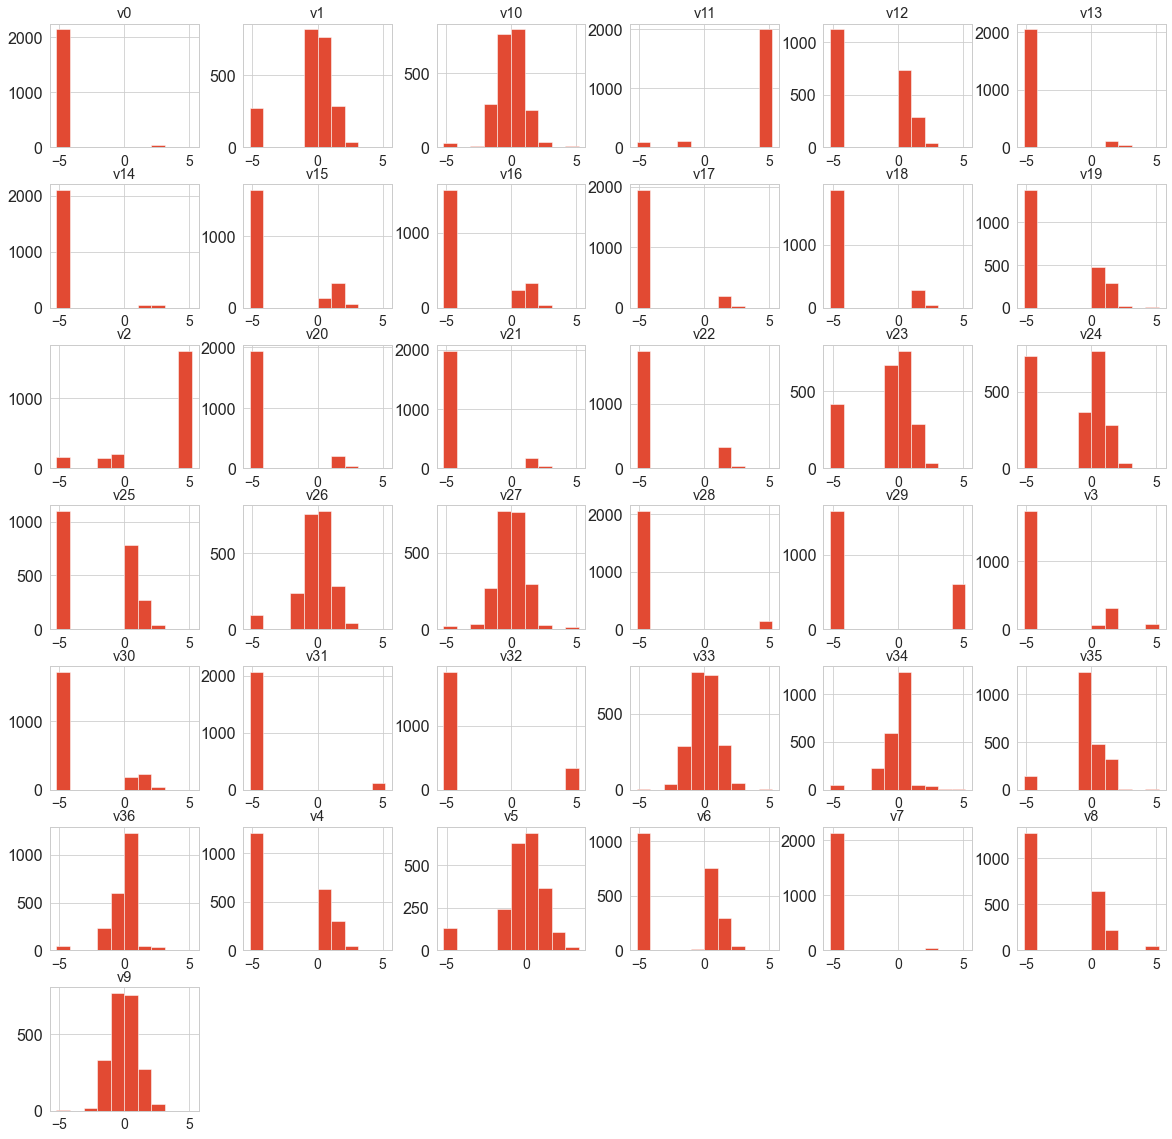

In [506]:
### Histograma de variables cuantitativas tansformadas para eliminar outliers

fig = plt.figure(figsize = (20,20))
ax = fig.gca()
var_cont_trans_train = qt_scaled_df_train
var_cont_trans_train.hist(ax=ax)
plt.show()

In [507]:
X_trans = pd.concat([var_cont_trans_train, var_cat], axis=1)
X_trans

v0        v1        v2        v3        v4        v5        v6  \
0    -5.199338 -0.067860  5.199338 -5.199338 -5.199338  0.981540  0.816150   
1    -5.199338  0.338834 -0.795322  0.888309  2.032279 -0.452858  0.957454   
2     2.018147 -0.278375  5.199338 -5.199338 -5.199338 -1.093546  0.043924   
3    -5.199338  1.537691  5.199338 -5.199338  0.664287  0.506348  0.125788   
4    -5.199338  1.750222 -0.941700  1.048748 -5.199338  0.729877 -5.199338   
...        ...       ...       ...       ...       ...       ...       ...   
2184 -5.199338 -5.199338  5.199338 -5.199338 -5.199338  0.053987  0.896590   
2185 -5.199338 -0.055660  5.199338 -5.199338  0.664287  0.058742  0.532303   
2186 -5.199338 -0.813084 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338   
2187 -5.199338  0.320290 -0.771450  0.860725  1.521525 -0.471004  1.046576   
2188 -5.199338  0.802618  5.199338 -5.199338  0.664287  0.222630 -5.199338   

            v7        v8        v9  ...  ae61  ae62  ae63  ae64  ae65  ae66  \
0    -5.199338  0.824933 -0.204660  ...     0     0     0     0     0     0   
1     2.408550 -5.199338 -0.567211  ...     0     0     0     0     0     0   
2    -5.199338 -5.199338 -2.053336  ...     1     0     0     0     0     0   
3    -5.199338  0.723343 -0.779924  ...     0     0     0     0     0     0   
4    -5.199338  0.568686  0.516356  ...     0     1     0     0     0     0   
...        ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
2184 -5.199338  0.774299  0.146048  ...     0     0     0     0     0     0   
2185 -5.199338  0.634851 -0.472407  ...     0     0     0     0     0     0   
2186 -5.199338 -5.199338 -1.252988  ...     1     0     0     0     0     0   
2187  2.241016 -5.199338 -0.567211  ...     0     0     0     0     0     0   
2188 -5.199338 -5.199338  0.516356  ...     0     1     0     0     0     0   

      ae67  ae68  d69  d70  
0        0     0    0    0  
1        0     0    0    0  
2        0     0    1    0  
3        0     0    0    0  
4        0     0    0    0  
...    ...   ...  ...  ...  
2184     0     1    0    0  
2185     0     1    0    0  
2186     0     0    1    0  
2187     0     0    0    0  
2188     0     0    0    0  

[2189 rows x 71 columns]

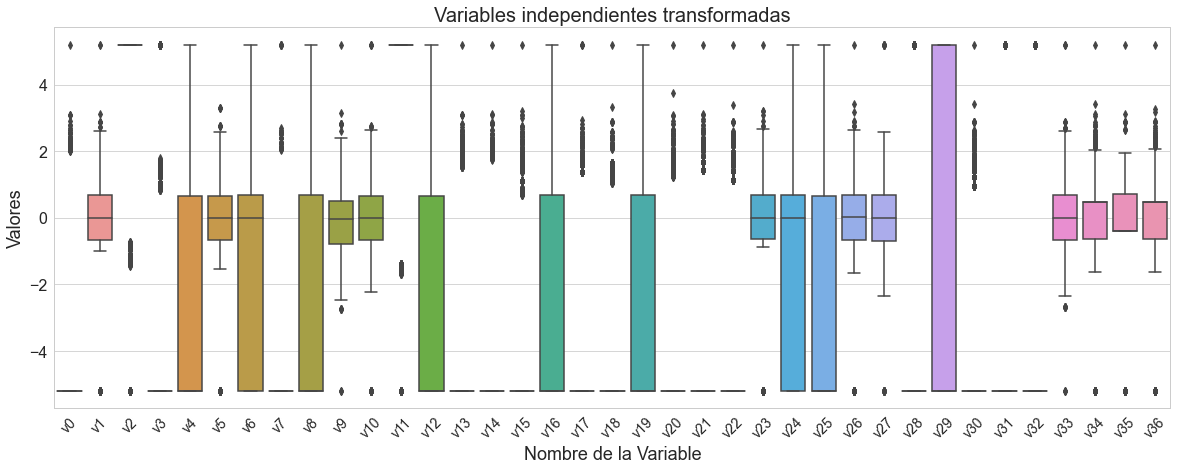

In [508]:
# Boxplots de cada variable numérica transformada
plt.figure(figsize=(20,7))
ax = sns.boxplot(data=var_cont_trans_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.title('Variables independientes transformadas', fontsize=20)
plt.ylabel('Valores', fontsize=18)
_ = plt.xlabel('Nombre de la Variable', fontsize=18)

In [509]:
media = var_cont_trans_train.mean()
desv = var_cont_trans_train.std()
pd.DataFrame([media,desv],index=['media','desviación']).T

media  desviación
v0  -5.025462    1.139963
v1  -0.442469    1.960373
v2   3.439604    3.336961
v3  -3.734797    2.958884
v4  -2.483260    3.050921
v5  -0.192723    1.529280
v6  -2.167629    3.027086
v7  -5.031364    1.158107
v8  -2.602025    3.166705
v9  -0.001624    1.008738
v10 -0.028755    1.140175
v11  4.444561    2.475879
v12 -2.262466    3.045183
v13 -4.719001    1.794579
v14 -4.899642    1.459077
v15 -3.606390    2.802320
v16 -3.390074    2.896182
v17 -4.432347    2.184568
v18 -4.199788    2.400873
v19 -2.884420    3.048257
v20 -4.434641    2.175149
v21 -4.544435    2.042556
v22 -4.081815    2.506401
v23 -0.721535    2.288051
v24 -1.370992    2.766703
v25 -2.207990    3.032543
v26 -0.132292    1.401207
v27 -0.011792    1.121412
v28 -4.558031    2.502065
v29 -2.311081    4.658533
v30 -3.801268    2.698656
v31 -4.619786    2.386061
v32 -3.569943    3.780893
v33 -0.001211    1.027490
v34 -0.085610    1.096735
v35 -0.184700    1.520138
v36 -0.086496    1.095283

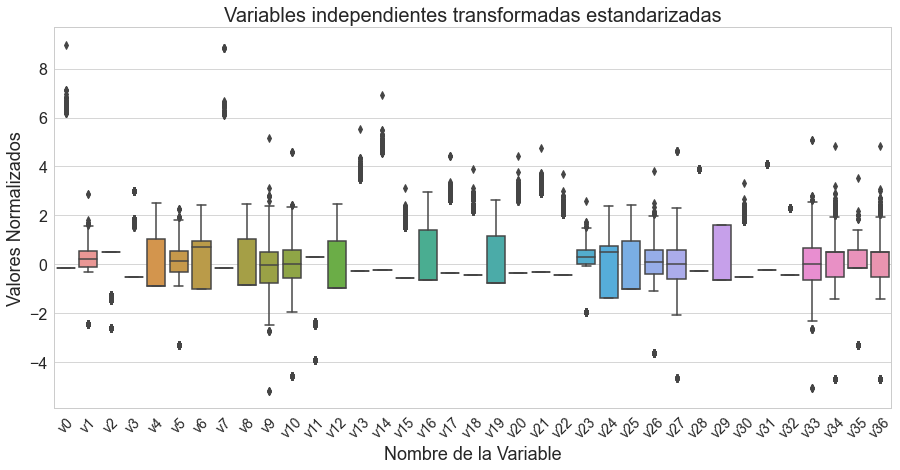

In [510]:
### Estandarizamos la data de entrenamiento con la media y desviacion de la misma
var_cont_trans_est_train = (var_cont_trans_train-media)/desv
# Boxplots de cada variable train
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=var_cont_trans_est_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.title('Variables independientes transformadas estandarizadas', fontsize=20)
plt.ylabel('Valores Normalizados', fontsize=18)
_ = plt.xlabel('Nombre de la Variable', fontsize=18)

In [511]:
X_trans_est_train = pd.concat([var_cont_trans_est_train, var_cat], axis=1)
X_trans_est_train

v0        v1        v2        v3        v4        v5        v6  \
0    -0.152527  0.191090  0.527346 -0.494964 -0.890248  0.767854  0.985693   
1    -0.152527  0.398548 -1.269096  1.562449  1.480057 -0.170103  1.032373   
2     6.178803  0.083706  0.527346 -0.494964 -0.890248 -0.589050  0.730588   
3    -0.152527  1.010093  0.527346 -0.494964  1.031671  0.457124  0.757632   
4    -0.152527  1.118507 -1.312962  1.616672 -0.890248  0.603291 -1.001527   
...        ...       ...       ...       ...       ...       ...       ...   
2184 -0.152527 -2.426512  0.527346 -0.494964 -0.890248  0.161325  1.012267   
2185 -0.152527  0.197314  0.527346 -0.494964  1.031671  0.164434  0.891924   
2186 -0.152527 -0.189053 -2.588865 -0.494964 -0.890248 -3.273838 -1.001527   
2187 -0.152527  0.389088 -1.261943  1.553127  1.312648 -0.181969  1.061815   
2188 -0.152527  0.635127  0.527346 -0.494964  1.031671  0.271600 -1.001527   

            v7        v8        v9  ...  ae61  ae62  ae63  ae64  ae65  ae66  \
0    -0.145042  1.082184 -0.201277  ...     0     0     0     0     0     0   
1     6.424204 -0.820194 -0.560688  ...     0     0     0     0     0     0   
2    -0.145042 -0.820194 -2.033938  ...     1     0     0     0     0     0   
3    -0.145042  1.050103 -0.771558  ...     0     0     0     0     0     0   
4    -0.145042  1.001265  0.513493  ...     0     1     0     0     0     0   
...        ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
2184 -0.145042  1.066195  0.146392  ...     0     0     0     0     0     0   
2185 -0.145042  1.022159 -0.466704  ...     0     0     0     0     0     0   
2186 -0.145042 -0.820194 -1.240524  ...     1     0     0     0     0     0   
2187  6.279542 -0.820194 -0.560688  ...     0     0     0     0     0     0   
2188 -0.145042 -0.820194  0.513493  ...     0     1     0     0     0     0   

      ae67  ae68  d69  d70  
0        0     0    0    0  
1        0     0    0    0  
2        0     0    1    0  
3        0     0    0    0  
4        0     0    0    0  
...    ...   ...  ...  ...  
2184     0     1    0    0  
2185     0     1    0    0  
2186     0     0    1    0  
2187     0     0    0    0  
2188     0     0    0    0  

[2189 rows x 71 columns]

In [512]:
trans_est = qt_scaler.transform(features_test[vc])
var_cont_trans_test = pd.DataFrame(trans_est, columns = vc)
var_cont_trans_test

v0        v1        v2        v3        v4        v5        v6  \
0   -5.199338 -1.010382 -1.242061  1.391202 -5.199338  0.925951  0.661662   
1   -5.199338 -5.199338  5.199338 -5.199338  0.385726 -0.554545  0.554822   
2   -5.199338 -5.199338  5.199338 -5.199338 -5.199338  1.372137  0.945187   
3   -5.199338 -0.169000  5.199338 -5.199338 -5.199338  1.050924  0.824933   
4    2.123803  0.152428 -0.744694  0.832006  1.926403  1.181921  1.611333   
..        ...       ...       ...       ...       ...       ...       ...   
543 -5.199338  0.231220  5.199338 -5.199338 -5.199338  0.023839 -5.199338   
544 -5.199338 -0.414417  5.199338 -5.199338 -5.199338  1.033647 -5.199338   
545 -5.199338 -0.386171  5.199338 -5.199338 -5.199338  1.250242 -5.199338   
546 -5.199338  1.425011  5.199338 -5.199338  0.479432  0.448692  0.459820   
547 -5.199338  0.941700  5.199338 -5.199338  0.664287  0.642543 -5.199338   

           v7        v8        v9  ...       v27       v28       v29  \
0   -5.199338  1.425011  1.541796  ... -0.927273 -5.199338 -5.199338   
1   -5.199338  0.543882  0.516356  ... -0.467325 -5.199338  5.199338   
2   -5.199338  1.425011 -1.414698  ... -0.394824 -5.199338 -5.199338   
3   -5.199338  0.824933 -0.204660  ... -0.007527 -5.199338  5.199338   
4   -5.199338  1.425011 -0.357496  ... -0.448692 -5.199338 -5.199338   
..        ...       ...       ...  ...       ...       ...       ...   
543 -5.199338  0.482248  0.146048  ... -0.229064 -5.199338 -5.199338   
544 -5.199338  5.199338 -1.252988  ... -0.791659 -5.199338 -5.199338   
545 -5.199338 -5.199338  1.654145  ...  0.647177 -5.199338 -5.199338   
546 -5.199338  0.723343 -0.779924  ... -1.895259 -5.199338 -5.199338   
547 -5.199338 -5.199338  0.516356  ... -0.040157 -5.199338  5.199338   

          v30       v31       v32       v33       v34       v35       v36  
0   -5.199338 -5.199338 -5.199338 -0.462610 -0.644086 -0.392492 -0.641002  
1    0.953493 -5.199338  5.199338 -1.562721  0.461215  0.973449  0.464007  
2    1.545927 -5.199338  5.199338  1.093732  0.461215 -0.392492  0.464007  
3   -5.199338 -5.199338 -5.199338 -0.532190 -1.629992 -0.392492 -1.629992  
4   -5.199338 -5.199338 -5.199338  0.012546  0.461215  0.699108  0.464007  
..        ...       ...       ...       ...       ...       ...       ...  
543 -5.199338 -5.199338 -5.199338  0.270485  0.461215 -0.392492  0.464007  
544 -5.199338 -5.199338 -5.199338 -0.280911 -0.644086 -0.392492 -0.641002  
545 -5.199338 -5.199338 -5.199338 -0.070314 -0.644086 -0.392492 -0.641002  
546 -5.199338 -5.199338 -5.199338  0.589456  0.461215  1.199766  0.464007  
547 -5.199338 -5.199338 -5.199338  1.152175  0.461215  1.562721  0.464007  

[548 rows x 37 columns]

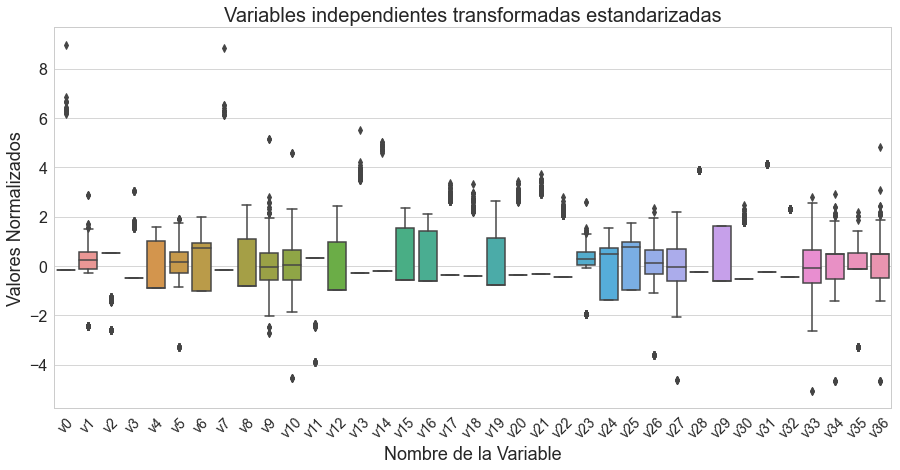

In [513]:
### Estandarizamos la data de prueba con la media y desviación de la data de entrenamiento
var_cont_trans_est_test = (var_cont_trans_test-media)/desv
# Boxplots de cada variable test
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=var_cont_trans_est_test)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.title('Variables independientes transformadas estandarizadas', fontsize=20)
plt.ylabel('Valores Normalizados', fontsize=18)
_ = plt.xlabel('Nombre de la Variable', fontsize=18)

In [514]:
X_trans_est_test = pd.concat([var_cont_trans_est_test, features_test.drop(vc,axis=1)], axis=1)
X_trans_est_test

v0        v1        v2        v3        v4        v5        v6  \
0   -0.152527 -0.289697 -1.402972  1.732409 -0.890248  0.731504  0.934658   
1   -0.152527 -2.426512  0.527346 -0.494964  0.940367 -0.236596  0.899363   
2   -0.152527 -2.426512  0.527346 -0.494964 -0.890248  1.023266  1.028321   
3   -0.152527  0.139498  0.527346 -0.494964 -0.890248  0.813224  0.988595   
4    6.271487  0.303461 -1.253925  1.543421  1.445354  0.898883  1.248383   
..        ...       ...       ...       ...       ...       ...       ...   
543 -0.152527  0.343653  0.527346 -0.494964 -0.890248  0.141611 -1.001527   
544 -0.152527  0.014309  0.527346 -0.494964 -0.890248  0.801927 -1.001527   
545 -0.152527  0.028718  0.527346 -0.494964 -0.890248  0.943559 -1.001527   
546 -0.152527  0.952614  0.527346 -0.494964  0.971081  0.419423  0.867979   
547 -0.152527  0.706074  0.527346 -0.494964  1.031671  0.546183 -1.001527   

           v7        v8        v9  ...  ae61  ae62  ae63  ae64  ae65  ae66  \
0   -0.145042  1.271680  1.530050  ...     0     0     0     0     0     0   
1   -0.145042  0.993432  0.513493  ...     0     0     0     0     0     0   
2   -0.145042  1.271680 -1.400833  ...     0     0     0     0     0     0   
3   -0.145042  1.082184 -0.201277  ...     0     0     0     0     0     0   
4   -0.145042  1.271680 -0.352789  ...     0     0     0     0     0     0   
..        ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
543 -0.145042  0.973969  0.146392  ...     0     0     0     0     0     0   
544 -0.145042  2.463558 -1.240524  ...     0     1     0     0     0     0   
545 -0.145042 -0.820194  1.641426  ...     1     0     0     0     0     0   
546 -0.145042  1.050103 -0.771558  ...     0     0     0     0     0     0   
547 -0.145042 -0.820194  0.513493  ...     0     1     0     0     0     0   

     ae67  ae68  d69  d70  
0       0     1    0    0  
1       0     1    0    0  
2       0     0    0    0  
3       0     0    0    0  
4       0     0    0    0  
..    ...   ...  ...  ...  
543     0     0    0    0  
544     0     0    0    0  
545     0     0    0    0  
546     0     0    0    0  
547     0     0    0    0  

[548 rows x 71 columns]

## Tratamiento de outliers

In [516]:
### Reemplazamos cada outlier por el límite superior de cada caja
for cols in vc:
    IQR = np.percentile(X_trans_est_train[cols],75) - np.percentile(X_trans_est_train[cols],25)
    
    limite_superior = np.percentile(X_trans_est_train[cols],75) + 1.5*IQR
    limite_inferior = np.percentile(X_trans_est_train[cols],25) - 1.5*IQR
    
    X_trans_est_train[cols] = np.where(X_trans_est_train[cols] > limite_superior,limite_superior,X_trans_est_train[cols])
    X_trans_est_train[cols] = np.where(X_trans_est_train[cols] < limite_inferior,limite_inferior,X_trans_est_train[cols])

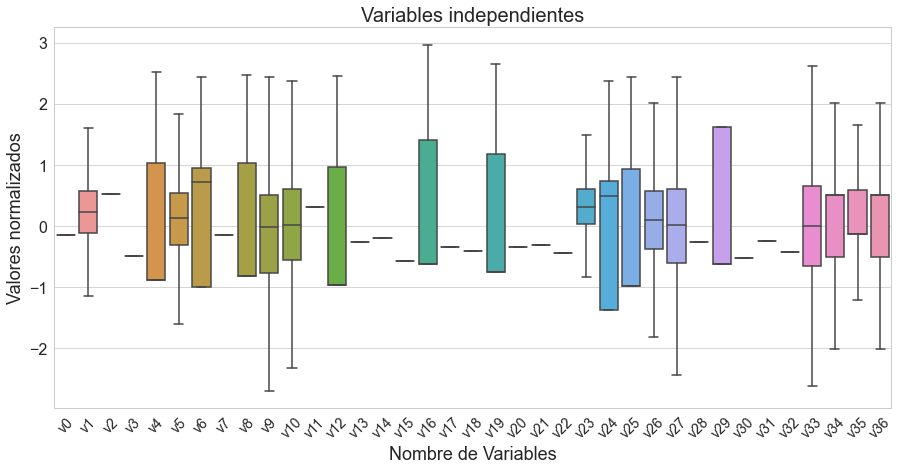

In [517]:
# Boxplots de cada variable de la data de entrenamiento sin outliers
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_trans_est_train[vc])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.title('Variables independientes', fontsize=20)
plt.ylabel('Valores normalizados', fontsize=18)
_ = plt.xlabel('Nombre de Variables', fontsize=18)

In [518]:
y_trans_est_train = y_train
y_trans_est_test = y_test

### Data sin Balancear

## LGBM

In [519]:
from time import time
# construimos un lightgbm
best_model_LGBM7 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8)
best_model_LGBM7.fit(X_trans_est_train, y_trans_est_train)

# predecimos el train y test con la probabilidad para validar 
predict_train_lg7 = best_model_LGBM7.predict_proba(X_trans_est_train)[:,1]
predict_test_lg7 = best_model_LGBM7.predict_proba(X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_lg7)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_lg7)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.967
auc o Roc on testing in LGBMClassifier data : 0.958


In [520]:
predictions_train_LGBM7 = best_model_LGBM7.predict(X_trans_est_train)
predictions_test_LGBM7 = best_model_LGBM7.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_LGBM7))
print(roc_auc_score(y_trans_est_test, predictions_test_LGBM7))
print(confusion_matrix(y_trans_est_test, predictions_test_LGBM7))

0.8669434731934732
0.8684343434343433
[[422  18]
 [ 24  84]]


In [522]:
print("Accuracy of LGBM:",roc_auc_score(y_trans_est_test,predictions_test_LGBM7)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_LGBM7))

Accuracy of LGBM: 86.84343434343434 

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       440
         1.0       0.82      0.78      0.80       108

    accuracy                           0.92       548
   macro avg       0.88      0.87      0.88       548
weighted avg       0.92      0.92      0.92       548



## XGBOOST

In [523]:
from time import time
# construimos un xgb
best_model_XGB5 = XGBClassifier(learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB5.fit(X_trans_est_train, y_trans_est_train)

# predecimos el train y test con la probabilidad para validar
predict_train_xg5 = best_model_XGB5.predict_proba(X_trans_est_train)[:,1]
predict_test_xg5 = best_model_XGB5.predict_proba(X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_xg5)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_xg5)))

[10:31:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.967
auc o Roc on testing in LGBMClassifier data : 0.958


In [524]:
predictions_train_XGB5 = best_model_XGB5.predict(X_trans_est_train)
predictions_test_XGB5 = best_model_XGB5.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_XGB5))
print(roc_auc_score(y_trans_est_test, predictions_test_XGB5))
print(confusion_matrix(y_trans_est_test, predictions_test_XGB5))

0.8689903846153846
0.8672979797979797
[[421  19]
 [ 24  84]]


In [526]:
print("Accuracy of XGB:",roc_auc_score(y_trans_est_test,predictions_test_XGB5)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_XGB5))

Accuracy of XGB: 86.72979797979798 

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       440
         1.0       0.82      0.78      0.80       108

    accuracy                           0.92       548
   macro avg       0.88      0.87      0.87       548
weighted avg       0.92      0.92      0.92       548



## Regresión Logística 

Lasso

In [527]:
logmodel19 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel19.fit(X_trans_est_train,y_trans_est_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [528]:
print("Weights:")
print("\tB0 =", logmodel19.intercept_[0])
for i, b in enumerate(logmodel19.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.857783448418685
	B1 =0.0
	B2 =0.6338662554468498
	B3 =0.0
	B4 =0.0
	B5 =-0.38285307140186636
	B6 =0.5790342451371788
	B7 =-0.25775258973570647
	B8 =0.0
	B9 =0.0
	B10 =-0.026818705507734197
	B11 =-0.6107226237138514
	B12 =0.0
	B13 =0.6217437435487722
	B14 =0.0
	B15 =0.0
	B16 =0.0
	B17 =0.03207498458395334
	B18 =0.0
	B19 =0.0
	B20 =0.07915955328475133
	B21 =0.0
	B22 =0.0
	B23 =0.0
	B24 =-1.0321239007532423
	B25 =-0.5848263629100581
	B26 =0.20444553473779137
	B27 =0.764933120268677
	B28 =-0.35997532474186483
	B29 =0.0
	B30 =-0.258911118807224
	B31 =0.0
	B32 =0.0
	B33 =0.0
	B34 =0.49048988294325896
	B35 =0.18067947723734137
	B36 =0.0
	B37 =0.0
	B38 =-0.33948152061740283
	B39 =0.0
	B40 =0.906880986640349
	B41 =3.942988801562999
	B42 =0.0
	B43 =1.135505908547905
	B44 =-0.2551915602706683
	B45 =0.0
	B46 =0.6188922640463523
	B47 =0.0
	B48 =0.0
	B49 =1.4798968019109169
	B50 =-0.002840370821803514
	B51 =0.0
	B52 =1.1105540061941437
	B53 =0.0
	B54 =-0.029842922726885494
	B55 =-0

In [529]:
predictions_train_RL19 = logmodel19.predict(X_trans_est_train)
predictions_test_RL19 = logmodel19.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL19))
print(roc_auc_score(y_trans_est_test,predictions_test_RL19))
print(confusion_matrix(y_trans_est_test, predictions_test_RL19))

0.7426937645687646
0.7994107744107743
[[402  38]
 [ 34  74]]


In [530]:
print(roc_auc_score(y_trans_est_train,logmodel19.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel19.predict_proba(X_trans_est_test)[:,1]))

0.888848272939182
0.8840277777777777


In [532]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL19)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL19))

Accuracy of Logistic Regression: 79.94107744107744 

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       440
         1.0       0.66      0.69      0.67       108

    accuracy                           0.87       548
   macro avg       0.79      0.80      0.80       548
weighted avg       0.87      0.87      0.87       548



Ridge

In [533]:
logmodel20 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel20.fit(X_trans_est_train,y_trans_est_train)

LogisticRegression(max_iter=1000)

In [534]:
print("Weights:")
print("\tB0 =", logmodel20.intercept_[0])
for i, b in enumerate(logmodel20.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.6409574117080856
	B1 =-0.0004825515630526331
	B2 =0.6719860170856268
	B3 =0.0016683711633941642
	B4 =-0.0015659220599963627
	B5 =-0.39464950049234165
	B6 =0.5866292204056734
	B7 =-0.2720441816726993
	B8 =-0.00045887021799950956
	B9 =-0.015401632762457996
	B10 =-0.0353590861532486
	B11 =-0.6170605574222014
	B12 =0.0009644640969097844
	B13 =0.6108387200589239
	B14 =-0.0008467983360520545
	B15 =-0.0006498287279388406
	B16 =-0.0017983762664412234
	B17 =0.24632959597957838
	B18 =-0.0011107624907761254
	B19 =-0.0013171398843944736
	B20 =0.1008399507482342
	B21 =-0.0011122360852753252
	B22 =-0.0010143769373073272
	B23 =-0.0014105962753578828
	B24 =-0.9847106863698801
	B25 =-0.6235085920888928
	B26 =0.20809685322320273
	B27 =0.7801669168306861
	B28 =-0.3595491893900299
	B29 =-0.000810894399487733
	B30 =-0.4947404896348057
	B31 =-0.0016389965811319533
	B32 =-0.0007684353111304028
	B33 =-0.0013634174496339056
	B34 =0.4822620171081325
	B35 =0.5363333912622561
	B36 =0.04635273659

In [535]:
predictions_train_RL20 = logmodel20.predict(X_trans_est_train)
predictions_test_RL20 = logmodel20.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL20))
print(roc_auc_score(y_trans_est_test,predictions_test_RL20))
print(confusion_matrix(y_trans_est_test, predictions_test_RL20))

0.7435751748251748
0.8028198653198653
[[405  35]
 [ 34  74]]


In [536]:
print(roc_auc_score(y_trans_est_train,logmodel20.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel20.predict_proba(X_trans_est_test)[:,1]))

0.8889886628522992
0.8848905723905723


In [538]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL20)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL20))

Accuracy of Logistic Regression: 80.28198653198653 

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       440
         1.0       0.68      0.69      0.68       108

    accuracy                           0.87       548
   macro avg       0.80      0.80      0.80       548
weighted avg       0.87      0.87      0.87       548



ElasticNet

In [539]:
logmodel21 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel21.fit(X_trans_est_train,y_trans_est_train)

LogisticRegression(l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [540]:
print("Weights:")
print("\tB0 =", logmodel21.intercept_[0])
for i, b in enumerate(logmodel21.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -4.002270624052965
	B1 =0.0
	B2 =0.6411763945010733
	B3 =0.0
	B4 =0.0
	B5 =-0.38207390544379466
	B6 =0.5770520318973482
	B7 =-0.2684402301010123
	B8 =0.0
	B9 =0.0
	B10 =-0.017075701843120898
	B11 =-0.6111889986424033
	B12 =0.0
	B13 =0.6200481411101848
	B14 =0.0
	B15 =0.0
	B16 =0.0
	B17 =0.06022267342413712
	B18 =0.0
	B19 =0.0
	B20 =0.08764422329126266
	B21 =0.0
	B22 =0.0
	B23 =0.0
	B24 =-1.0114483178166405
	B25 =-0.5860032744767548
	B26 =0.20810890841910085
	B27 =0.7802047678508367
	B28 =-0.36250038362660725
	B29 =0.0
	B30 =-0.2898779476312013
	B31 =0.0
	B32 =0.0
	B33 =0.0
	B34 =0.48473626938982406
	B35 =0.18238006911640003
	B36 =0.0
	B37 =0.0
	B38 =-0.3240367038675547
	B39 =0.0
	B40 =0.9189491565017067
	B41 =3.9042630928613757
	B42 =0.0
	B43 =1.1439105712438844
	B44 =-0.3314773316602064
	B45 =0.0
	B46 =0.648994590302363
	B47 =0.0
	B48 =0.0
	B49 =1.4891363093169487
	B50 =0.0
	B51 =0.0
	B52 =1.1493031436454806
	B53 =0.0
	B54 =-0.08329150359372023
	B55 =-0.1073186090760421

In [541]:
predictions_train_RL21 = logmodel21.predict(X_trans_est_train)
predictions_test_RL21 = logmodel21.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL21))
print(roc_auc_score(y_trans_est_test,predictions_test_RL21))
print(confusion_matrix(y_trans_est_test, predictions_test_RL21))

0.7426937645687646
0.800547138047138
[[403  37]
 [ 34  74]]


In [542]:
print(roc_auc_score(y_trans_est_train,logmodel21.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel21.predict_proba(X_trans_est_test)[:,1]))

0.8890363424454333
0.8846380471380472


In [544]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL21)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL21))

Accuracy of Logistic Regression: 80.0547138047138 

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       440
         1.0       0.67      0.69      0.68       108

    accuracy                           0.87       548
   macro avg       0.79      0.80      0.80       548
weighted avg       0.87      0.87      0.87       548



### Data Balanceada

Balancear los datos por oversampling

In [545]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [546]:
pip install delayed

Note: you may need to restart the kernel to use updated packages.


In [547]:
from imblearn.over_sampling import SMOTE

In [548]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({0.0: 1760, 1.0: 429})


In [549]:
os5 = SMOTE(random_state = 0)

In [550]:
os_data_X5, os_data_y5 = os5.fit_resample(X_trans_est_train.values, y_train.values)

In [551]:
counter5 = Counter(os_data_y5)
print(counter5)

Counter({0.0: 1760, 1.0: 1760})


## LGBM

### Forma 1

In [552]:
from time import time
# construimos un lightgbm
best_model_LGBM8 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8,class_weight='balanced')
best_model_LGBM8.fit(X_trans_est_train, y_trans_est_train)

# predecimos el train y test con la probabilidad para validar
predict_train_lg8 = best_model_LGBM8.predict_proba(X_trans_est_train)[:,1]
predict_test_lg8 = best_model_LGBM8.predict_proba(X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_lg8)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_lg8)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.969
auc o Roc on testing in LGBMClassifier data : 0.957


In [553]:
predictions_train_LGBM8 = best_model_LGBM8.predict(X_trans_est_train)
predictions_test_LGBM8 = best_model_LGBM8.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_LGBM8))
print(roc_auc_score(y_trans_est_test, predictions_test_LGBM8))
print(confusion_matrix(y_trans_est_test, predictions_test_LGBM8))

0.9139568764568765
0.884469696969697
[[375  65]
 [  9  99]]


In [555]:
print("Accuracy of LGBM:",roc_auc_score(y_trans_est_test,predictions_test_LGBM8)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_LGBM8))

Accuracy of LGBM: 88.4469696969697 

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91       440
         1.0       0.60      0.92      0.73       108

    accuracy                           0.86       548
   macro avg       0.79      0.88      0.82       548
weighted avg       0.90      0.86      0.87       548



### Forma 2

In [557]:
from time import time
# construimos un lightgbm
best_model_LGBM9 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8)
best_model_LGBM9.fit(os_data_X5, os_data_y5)

# predecimos el train y test con la probabilidad para validar
predict_train_lg9 = best_model_LGBM9.predict_proba(X_trans_est_train)[:,1]
predict_test_lg9 = best_model_LGBM9.predict_proba(X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_lg9)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_lg9)))

auc o Roc on training in LGBMClassifier data : 0.959
auc o Roc on testing in LGBMClassifier data : 0.952


In [558]:
predictions_train_LGBM9 = best_model_LGBM9.predict(X_trans_est_train)
predictions_test_LGBM9 = best_model_LGBM9.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_LGBM9))
print(roc_auc_score(y_trans_est_test, predictions_test_LGBM9))
print(confusion_matrix(y_trans_est_test, predictions_test_LGBM9))

0.8944493006993007
0.8817760942760943
[[393  47]
 [ 14  94]]


In [560]:
print("Accuracy of LGBM:",roc_auc_score(y_trans_est_test,predictions_test_LGBM9)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_LGBM9))

Accuracy of LGBM: 88.17760942760943 

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93       440
         1.0       0.67      0.87      0.76       108

    accuracy                           0.89       548
   macro avg       0.82      0.88      0.84       548
weighted avg       0.91      0.89      0.89       548



## XGBOOST

In [562]:
from time import time
# construimos un xgb
best_model_XGB6 = XGBClassifier(learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB6.fit(os_data_X5, os_data_y5)

# predecimos el train y test con la probabilidad para validar 
predict_train_xg6 = best_model_XGB6.predict_proba(X_trans_est_train)[:,1]
predict_test_xg6 = best_model_XGB6.predict_proba(X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_xg6)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_xg6)))

[10:36:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.960
auc o Roc on testing in LGBMClassifier data : 0.953


In [563]:
predictions_train_XGB6 = best_model_XGB6.predict(X_trans_est_train)
predictions_test_XGB6 = best_model_XGB6.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_XGB6))
print(roc_auc_score(y_trans_est_test, predictions_test_XGB6))
print(confusion_matrix(y_trans_est_test, predictions_test_XGB6))

0.8953015734265735
0.8874579124579124
[[398  42]
 [ 14  94]]


In [565]:
print("Accuracy of XGB:",roc_auc_score(y_trans_est_test,predictions_test_XGB6)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_XGB6))

Accuracy of XGB: 88.74579124579124 

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       440
         1.0       0.69      0.87      0.77       108

    accuracy                           0.90       548
   macro avg       0.83      0.89      0.85       548
weighted avg       0.91      0.90      0.90       548



## Regresión Logística 

### Forma 1

Lasso

In [566]:
logmodel22 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel22.fit(X_trans_est_train,y_trans_est_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [567]:
print("Weights:")
print("\tB0 =", logmodel22.intercept_[0])
for i, b in enumerate(logmodel22.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -2.76796457746554
	B1 =0.0
	B2 =0.39951185450562626
	B3 =0.0
	B4 =0.0
	B5 =-0.6208731298814306
	B6 =0.5116958405382432
	B7 =-0.18853953311033753
	B8 =0.0
	B9 =0.0
	B10 =-0.03572462112559395
	B11 =-0.5874838696907001
	B12 =0.0
	B13 =0.819269968061213
	B14 =0.0
	B15 =0.0
	B16 =0.0
	B17 =0.17932456896988974
	B18 =0.0
	B19 =0.0
	B20 =0.250186679951449
	B21 =0.0
	B22 =0.0
	B23 =0.0
	B24 =-1.2571679326242216
	B25 =-0.8293256443979049
	B26 =0.16230039023158618
	B27 =0.9520475181041637
	B28 =-0.3990856586217448
	B29 =0.0
	B30 =-0.29347625918392006
	B31 =0.0
	B32 =0.0
	B33 =0.0
	B34 =0.43473395365800976
	B35 =0.17491708575389447
	B36 =0.14728271724361075
	B37 =0.0
	B38 =-0.2938877416808492
	B39 =0.28299722186383797
	B40 =1.2634431389917893
	B41 =4.667256705411162
	B42 =0.5989549432946925
	B43 =1.438505260753722
	B44 =-1.2916666475679355
	B45 =0.0
	B46 =1.044113245645057
	B47 =0.0
	B48 =0.0
	B49 =1.8733120486392254
	B50 =-0.09651911882623668
	B51 =0.0
	B52 =1.06677521243847
	B53 =

In [568]:
predictions_train_RL22 = logmodel22.predict(X_trans_est_train)
predictions_test_RL22 = logmodel22.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL22))
print(roc_auc_score(y_trans_est_test,predictions_test_RL22))
print(confusion_matrix(y_trans_est_test, predictions_test_RL22))

0.8451558857808857
0.8456649831649832
[[349  91]
 [ 11  97]]


In [569]:
print(roc_auc_score(y_trans_est_train,logmodel22.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel22.predict_proba(X_trans_est_test)[:,1]))

0.8940850815850816
0.8816708754208754


In [571]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL22)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL22))

Accuracy of Logistic Regression: 84.56649831649831 

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87       440
         1.0       0.52      0.90      0.66       108

    accuracy                           0.81       548
   macro avg       0.74      0.85      0.76       548
weighted avg       0.88      0.81      0.83       548



Ridge

In [572]:
logmodel23 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel23.fit(X_trans_est_train,y_trans_est_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [573]:
print("Weights:")
print("\tB0 =", logmodel23.intercept_[0])
for i, b in enumerate(logmodel23.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -2.6469094442767322
	B1 =-0.0005172052273200487
	B2 =0.4328232977803072
	B3 =0.0017881825547491927
	B4 =-0.0016783762337877906
	B5 =-0.5923299919648133
	B6 =0.5279577485296744
	B7 =-0.1960000659087884
	B8 =-0.0004918232445651947
	B9 =-0.002805722332734105
	B10 =-0.05902679026676544
	B11 =-0.59734613624498
	B12 =0.0010337255345897486
	B13 =0.7858513900913935
	B14 =-0.0009076097963942922
	B15 =-0.0006964951327188865
	B16 =-0.001927523765136774
	B17 =0.2884389647056079
	B18 =-0.001190530112273821
	B19 =-0.0014117281664366103
	B20 =0.2543266329367213
	B21 =-0.0011921095305872755
	B22 =-0.0010872227853290356
	B23 =-0.0015118959777850956
	B24 =-1.1998635079151827
	B25 =-0.8039177033031796
	B26 =0.15526086998917507
	B27 =0.9433024360755137
	B28 =-0.38535272965292233
	B29 =-0.0008691274763793219
	B30 =-0.4274393391511369
	B31 =-0.0017566984841101542
	B32 =-0.0008236192568905573
	B33 =-0.0014613290805824588
	B34 =0.43791657564668507
	B35 =0.5152019854890498
	B36 =0.16953677900958

In [574]:
predictions_train_RL23 = logmodel23.predict(X_trans_est_train)
predictions_test_RL23 = logmodel23.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL23))
print(roc_auc_score(y_trans_est_test,predictions_test_RL23))
print(confusion_matrix(y_trans_est_test, predictions_test_RL23))

0.8457240675990675
0.8490740740740741
[[352  88]
 [ 11  97]]


In [575]:
print(roc_auc_score(y_trans_est_train,logmodel23.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel23.predict_proba(X_trans_est_test)[:,1]))

0.8926573426573428
0.8808291245791247


In [577]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL23)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL23))

Accuracy of Logistic Regression: 84.9074074074074 

              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88       440
         1.0       0.52      0.90      0.66       108

    accuracy                           0.82       548
   macro avg       0.75      0.85      0.77       548
weighted avg       0.88      0.82      0.83       548



ElasticNet

In [578]:
logmodel24 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel24.fit(X_trans_est_train,y_trans_est_train)

LogisticRegression(class_weight='balanced', l1_ratio=0.9, max_iter=10000,
                   penalty='elasticnet', solver='saga')

In [579]:
print("Weights:")
print("\tB0 =", logmodel24.intercept_[0])
for i, b in enumerate(logmodel24.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.1123614315180372
	B1 =0.0
	B2 =0.4036674052185311
	B3 =0.0
	B4 =0.0
	B5 =-0.6138377229736205
	B6 =0.4953979248005439
	B7 =-0.19721213320147007
	B8 =0.0
	B9 =0.003399783132607798
	B10 =-0.03969431958910681
	B11 =-0.5937587422675296
	B12 =0.0
	B13 =0.8152988405222725
	B14 =0.0
	B15 =0.0
	B16 =0.0
	B17 =0.18565754987488414
	B18 =0.0
	B19 =0.0
	B20 =0.2524377676941489
	B21 =0.0
	B22 =0.0
	B23 =0.0
	B24 =-1.2428804360878833
	B25 =-0.8164892171879092
	B26 =0.16352389789935257
	B27 =0.9657619146105979
	B28 =-0.4046099941599061
	B29 =0.0
	B30 =-0.30465662238573465
	B31 =0.0
	B32 =0.0
	B33 =0.0
	B34 =0.4263416826106032
	B35 =0.1693575431705881
	B36 =0.14427375083034658
	B37 =0.0
	B38 =-0.11855844256179916
	B39 =0.44149910289481986
	B40 =1.402053913060953
	B41 =4.7221049210208195
	B42 =0.7192588280293435
	B43 =1.562760896425054
	B44 =-1.1369727458499685
	B45 =0.0
	B46 =1.1546571538150359
	B47 =0.0
	B48 =0.0
	B49 =1.9167166299803076
	B50 =0.0
	B51 =0.0
	B52 =1.1548146956449665
	

In [580]:
predictions_train_RL24 = logmodel24.predict(X_trans_est_train)
predictions_test_RL24 = logmodel24.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL24))
print(roc_auc_score(y_trans_est_test,predictions_test_RL24))
print(confusion_matrix(y_trans_est_test, predictions_test_RL24))

0.8448717948717948
0.8456649831649832
[[349  91]
 [ 11  97]]


In [581]:
print(roc_auc_score(y_trans_est_train,logmodel24.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel24.predict_proba(X_trans_est_test)[:,1]))

0.8941314367450731
0.8819023569023569


In [583]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL24)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL24))

Accuracy of Logistic Regression: 84.56649831649831 

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87       440
         1.0       0.52      0.90      0.66       108

    accuracy                           0.81       548
   macro avg       0.74      0.85      0.76       548
weighted avg       0.88      0.81      0.83       548



### Forma 2

Lasso

In [584]:
logmodel25 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel25.fit(os_data_X5,os_data_y5)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [585]:
print("Weights:")
print("\tB0 =", logmodel25.intercept_[0])
for i, b in enumerate(logmodel25.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.0688026495726897
	B1 =0.0
	B2 =0.562131708974376
	B3 =0.0
	B4 =0.0
	B5 =-0.6513127095781546
	B6 =0.49833121383086737
	B7 =-0.1434581632764744
	B8 =0.0
	B9 =-0.011513501285462753
	B10 =0.0788709963376096
	B11 =-0.6162837677014301
	B12 =0.0
	B13 =0.8518305333123318
	B14 =0.0
	B15 =0.0
	B16 =0.0
	B17 =0.06216911370820178
	B18 =0.0
	B19 =0.0
	B20 =0.30032209140049954
	B21 =0.0
	B22 =0.0
	B23 =0.0
	B24 =-1.2966653747957777
	B25 =-1.1256169716052502
	B26 =0.2554832464431365
	B27 =1.1097175743847572
	B28 =-0.4481406967266336
	B29 =0.0
	B30 =-0.1548182890511164
	B31 =0.0
	B32 =0.0
	B33 =0.0
	B34 =0.5207263303853727
	B35 =0.21250040448556962
	B36 =0.1372867260541341
	B37 =-0.04568918077998673
	B38 =-0.48563020019745373
	B39 =0.6540240221520937
	B40 =1.795992336055265
	B41 =5.210098391126922
	B42 =1.18247243608857
	B43 =1.8732215009075976
	B44 =-2.082320310773721
	B45 =0.0
	B46 =1.3713326340546106
	B47 =0.0
	B48 =0.0
	B49 =1.7524421156301493
	B50 =0.0
	B51 =0.0
	B52 =1.09877405

In [586]:
predictions_train_RL25 = logmodel25.predict(X_trans_est_train)
predictions_test_RL25 = logmodel25.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL25))
print(roc_auc_score(y_trans_est_test,predictions_test_RL25))
print(confusion_matrix(y_trans_est_test, predictions_test_RL25))

0.8433347902097902
0.8513468013468014
[[354  86]
 [ 11  97]]


In [587]:
print(roc_auc_score(y_trans_est_train,logmodel25.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel25.predict_proba(X_trans_est_test)[:,1]))

0.8925897965670693
0.8859848484848484


In [589]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL25)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL25))

Accuracy of Logistic Regression: 85.13468013468014 

              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88       440
         1.0       0.53      0.90      0.67       108

    accuracy                           0.82       548
   macro avg       0.75      0.85      0.77       548
weighted avg       0.88      0.82      0.84       548



Ridge

In [590]:
logmodel26 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel26.fit(os_data_X5,os_data_y5)

LogisticRegression(max_iter=1000)

In [591]:
print("Weights:")
print("\tB0 =", logmodel26.intercept_[0])
for i, b in enumerate(logmodel26.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.2284186975459916
	B1 =-1.5033098896996395e-05
	B2 =0.584730976733441
	B3 =5.197535477820155e-05
	B4 =-4.878372179515865e-05
	B5 =-0.634118197247216
	B6 =0.545590185784108
	B7 =-0.14497870521504666
	B8 =-1.4295345618920503e-05
	B9 =-0.026861854469472413
	B10 =0.07996968012510074
	B11 =-0.6229208739354501
	B12 =3.0046289902106122e-05
	B13 =0.8091068902382987
	B14 =-2.638060695268513e-05
	B15 =-2.0244343367851812e-05
	B16 =-5.60254495806865e-05
	B17 =0.1623732428402546
	B18 =-3.460397532053397e-05
	B19 =-4.1033322997316724e-05
	B20 =0.29629416266690894
	B21 =-3.464988268291549e-05
	B22 =-3.1601242177599885e-05
	B23 =-4.394480284333638e-05
	B24 =-1.2314528556743165
	B25 =-1.0646274308253612
	B26 =0.2539162791754658
	B27 =1.0594818803155375
	B28 =-0.4200787591466816
	B29 =-2.526207899131005e-05
	B30 =-0.2845443479514608
	B31 =-5.1060238114995084e-05
	B32 =-2.3939336021337835e-05
	B33 =-4.247502426653027e-05
	B34 =0.5199066276615062
	B35 =0.6298496384579043
	B36 =0.16914873

In [592]:
predictions_train_RL26 = logmodel26.predict(X_trans_est_train)
predictions_test_RL26 = logmodel26.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL26))
print(roc_auc_score(y_trans_est_test,predictions_test_RL26))
print(confusion_matrix(y_trans_est_test, predictions_test_RL26))

0.8407196969696971
0.8536195286195286
[[356  84]
 [ 11  97]]


In [593]:
print(roc_auc_score(y_trans_est_train,logmodel26.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel26.predict_proba(X_trans_est_test)[:,1]))

0.8907038037719857
0.8868476430976431


In [595]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL26)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL26))

Accuracy of Logistic Regression: 85.36195286195286 

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88       440
         1.0       0.54      0.90      0.67       108

    accuracy                           0.83       548
   macro avg       0.75      0.85      0.78       548
weighted avg       0.88      0.83      0.84       548



ElasticNet

In [596]:
logmodel27 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel27.fit(os_data_X5,os_data_y5)

LogisticRegression(l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [597]:
print("Weights:")
print("\tB0 =", logmodel27.intercept_[0])
for i, b in enumerate(logmodel27.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -3.9430413936009794
	B1 =0.0
	B2 =0.5645181373127832
	B3 =0.0
	B4 =0.0
	B5 =-0.6499749580658662
	B6 =0.4590154801861043
	B7 =-0.14795614450829647
	B8 =0.0
	B9 =-0.010699860019488819
	B10 =0.07826129519484917
	B11 =-0.6214397195092085
	B12 =0.0
	B13 =0.8428994800277365
	B14 =0.0
	B15 =0.0
	B16 =0.0
	B17 =0.062292477385349834
	B18 =0.0
	B19 =0.0
	B20 =0.29318740224662304
	B21 =0.0
	B22 =0.0
	B23 =0.0
	B24 =-1.27110244078508
	B25 =-1.1189367765956106
	B26 =0.256049407047104
	B27 =1.1133823050854763
	B28 =-0.45596115556466454
	B29 =0.0
	B30 =-0.15756763684643535
	B31 =0.0
	B32 =0.0
	B33 =0.0
	B34 =0.519567014770578
	B35 =0.2381033414586461
	B36 =0.14478188277885326
	B37 =-0.0736017285343378
	B38 =-0.2896001115036797
	B39 =0.7946243323828498
	B40 =1.9115794969044488
	B41 =5.2501560573185175
	B42 =1.2833132199095345
	B43 =1.9723907518741997
	B44 =-1.3871670577207702
	B45 =0.0
	B46 =1.40667786022812
	B47 =0.0
	B48 =0.0
	B49 =1.7336812257940208
	B50 =0.01684263717677867
	B51 =0.

In [598]:
predictions_train_RL27 = logmodel27.predict(X_trans_est_train)
predictions_test_RL27 = logmodel27.predict(X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL27))
print(roc_auc_score(y_trans_est_test,predictions_test_RL27))
print(confusion_matrix(y_trans_est_test, predictions_test_RL27))

0.8410037878787879
0.8547558922558922
[[357  83]
 [ 11  97]]


In [599]:
print(roc_auc_score(y_trans_est_train,logmodel27.predict_proba(X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel27.predict_proba(X_trans_est_test)[:,1]))

0.8925209260436533
0.888047138047138


In [601]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL27)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL27))

Accuracy of Logistic Regression: 85.47558922558922 

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88       440
         1.0       0.54      0.90      0.67       108

    accuracy                           0.83       548
   macro avg       0.75      0.85      0.78       548
weighted avg       0.89      0.83      0.84       548



# Modelos con tratamiento QuantTrans y con selección de mejores variables

### Data sin Balancear

## LGBM

In [602]:
## Usando la mejor selección de variables
bestLGBM_X_trans_est_train = X_trans_est_train[variables_LGBM]
bestLGBM_X_trans_est_test = X_trans_est_test[variables_LGBM]

In [603]:
bestLGBM_X_trans_est_train.shape

(2189, 23)

In [604]:
from time import time
# construimos un lightgbm
best_model_LGBM10 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8)
best_model_LGBM10.fit(bestLGBM_X_trans_est_train, y_trans_est_train)

# predecimos el train y test con la probabilidad para validar
predict_train_lg10 = best_model_LGBM10.predict_proba(bestLGBM_X_trans_est_train)[:,1]
predict_test_lg10 = best_model_LGBM10.predict_proba(bestLGBM_X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_lg10)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_lg10)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.965
auc o Roc on testing in LGBMClassifier data : 0.956


In [605]:
predictions_train_LGBM10 = best_model_LGBM10.predict(bestLGBM_X_trans_est_train)
predictions_test_LGBM10 = best_model_LGBM10.predict(bestLGBM_X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_LGBM10))
print(roc_auc_score(y_trans_est_test, predictions_test_LGBM10))
print(confusion_matrix(y_trans_est_test, predictions_test_LGBM10))

0.8611159673659674
0.8638047138047139
[[422  18]
 [ 25  83]]


In [607]:
print("Accuracy of LGBM:",roc_auc_score(y_trans_est_test,predictions_test_LGBM10)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_LGBM10))

Accuracy of LGBM: 86.38047138047139 

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       440
         1.0       0.82      0.77      0.79       108

    accuracy                           0.92       548
   macro avg       0.88      0.86      0.87       548
weighted avg       0.92      0.92      0.92       548



## XGBOOST

In [608]:
## Usando la mejor selección de variables
bestXGB_X_trans_est_train = X_trans_est_train[variables_XGB]
bestXGB_X_trans_est_test = X_trans_est_test[variables_XGB]

In [609]:
bestXGB_X_trans_est_train.shape

(2189, 25)

In [610]:
from time import time
# construimos un xgb
best_model_XGB7 = XGBClassifier(objective = 'binary:logistic',learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB7.fit(bestXGB_X_trans_est_train, y_trans_est_train)

# predecimos el train y test con la probabilidad para validar
predict_train_xg7 = best_model_XGB7.predict_proba(bestXGB_X_trans_est_train)[:,1]
predict_test_xg7 = best_model_XGB7.predict_proba(bestXGB_X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_xg7)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_xg7)))

[10:39:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.956
auc o Roc on testing in LGBMClassifier data : 0.952


In [611]:
predictions_train_XGB7 = best_model_XGB7.predict(bestXGB_X_trans_est_train)
predictions_test_XGB7 = best_model_XGB7.predict(bestXGB_X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_XGB7))
print(roc_auc_score(y_trans_est_test, predictions_test_XGB7))
print(confusion_matrix(y_trans_est_test, predictions_test_XGB7))

0.8314102564102565
0.8638047138047139
[[422  18]
 [ 25  83]]


In [613]:
print("Accuracy of XGB:",roc_auc_score(y_trans_est_test,predictions_test_XGB7)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_XGB7))

Accuracy of XGB: 86.38047138047139 

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       440
         1.0       0.82      0.77      0.79       108

    accuracy                           0.92       548
   macro avg       0.88      0.86      0.87       548
weighted avg       0.92      0.92      0.92       548



## Regresión Logística 

In [614]:
## Usando la mejor selección de variables
bestRLog_X_trans_est_train = pd.concat([X_trans_est_train[['tcs40', 'tcs41', 'tcs42', 'tc43','ae55', 'ae56',
       'ae57', 'ae58', 'ae59', 'ae60', 'ae61', 'ae62', 'ae63', 'ae64', 'ae65',
       'ae66', 'ae67', 'ae68']],X_trans_est_train[variables_RLog]],axis=1) 
bestRLog_X_trans_est_test = pd.concat([X_trans_est_test[['tcs40', 'tcs41', 'tcs42', 'tc43','ae55', 'ae56',
       'ae57', 'ae58', 'ae59', 'ae60', 'ae61', 'ae62', 'ae63', 'ae64', 'ae65',
       'ae66', 'ae67', 'ae68']],X_trans_est_test[variables_RLog]],axis=1) 

Lasso

In [615]:
logmodel28 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel28.fit(bestRLog_X_trans_est_train,y_trans_est_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [616]:
print("Weights:")
print("\tB0 =", logmodel28.intercept_[0])
for i, b in enumerate(logmodel28.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -2.5982275166779827
	B1 =2.600098851583972
	B2 =0.0
	B3 =0.797412200398183
	B4 =-0.0625407412700566
	B5 =0.0
	B6 =-0.24020036831870958
	B7 =2.145595885759137
	B8 =-0.6514328703253827
	B9 =0.0
	B10 =-0.5176958760051616
	B11 =0.7583614929208018
	B12 =0.8478419084019422
	B13 =0.0
	B14 =-0.6871553203126514
	B15 =0.0
	B16 =0.0
	B17 =-0.11195581346619225
	B18 =0.0
	B19 =-1.6191993764182435
	B20 =1.0826282575526522
	B21 =0.0
	B22 =-0.21779874182256512
	B23 =-0.3807861196208444
	B24 =0.0
	B25 =0.6880218711465769
	B26 =0.6146753493979424
	B27 =-0.6384462196341857
	B28 =-0.0372173495965052
	B29 =-0.30314886981601075
	B30 =-0.1223667123719226
	B31 =-0.26906820352274435
	B32 =0.0
	B33 =0.05103768369760628


In [617]:
predictions_train_RL28 = logmodel28.predict(bestRLog_X_trans_est_train)
predictions_test_RL28 = logmodel28.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL28))
print(roc_auc_score(y_trans_est_test,predictions_test_RL28))
print(confusion_matrix(y_trans_est_test, predictions_test_RL28))

0.7213432400932401
0.7904040404040404
[[390  50]
 [ 33  75]]


In [618]:
print(roc_auc_score(y_trans_est_train,logmodel28.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel28.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8601014515787242
0.8493897306397307


In [620]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL28)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL28))

Accuracy of Logistic Regression: 79.04040404040404 

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       440
         1.0       0.60      0.69      0.64       108

    accuracy                           0.85       548
   macro avg       0.76      0.79      0.77       548
weighted avg       0.86      0.85      0.85       548



Ridge

In [621]:
logmodel29 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel29.fit(bestRLog_X_trans_est_train,y_trans_est_train)

LogisticRegression(max_iter=1000)

In [622]:
print("Weights:")
print("\tB0 =", logmodel29.intercept_[0])
for i, b in enumerate(logmodel29.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -2.5644833080714626
	B1 =2.373603428213319
	B2 =0.6164571786767985
	B3 =0.7872786972155704
	B4 =-0.6831990476353473
	B5 =-0.0013356561508809492
	B6 =-0.34236445070640564
	B7 =2.055838463686675
	B8 =-0.6837386538718437
	B9 =-0.1064759647768052
	B10 =-0.7387465078056222
	B11 =0.7126780681809965
	B12 =0.8253670483201093
	B13 =-0.26314185120847494
	B14 =-0.8915623803689973
	B15 =0.23973877393894452
	B16 =-0.22755897287747215
	B17 =-0.6394990693391527
	B18 =0.08995665724244342
	B19 =-1.5515435497474277
	B20 =1.0736463135461676
	B21 =0.0010107859178484556
	B22 =-0.21034718647378325
	B23 =-0.4097797215942907
	B24 =-0.001076915716807323
	B25 =0.6780790872966111
	B26 =0.6150549285233441
	B27 =-0.6460427001414348
	B28 =-0.07712678793742261
	B29 =-0.30326378536881465
	B30 =-0.12565269878457522
	B31 =-0.2855231981834088
	B32 =0.001057954738574496
	B33 =0.050262246677337113


In [623]:
predictions_train_RL29 = logmodel29.predict(bestRLog_X_trans_est_train)
predictions_test_RL29 = logmodel29.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL29))
print(roc_auc_score(y_trans_est_test,predictions_test_RL29))
print(confusion_matrix(y_trans_est_test, predictions_test_RL29))

0.7222246503496503
0.7904040404040404
[[390  50]
 [ 33  75]]


In [624]:
print(roc_auc_score(y_trans_est_train,logmodel29.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel29.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8611212650985378
0.8497895622895623


In [626]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL29)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL29))

Accuracy of Logistic Regression: 79.04040404040404 

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       440
         1.0       0.60      0.69      0.64       108

    accuracy                           0.85       548
   macro avg       0.76      0.79      0.77       548
weighted avg       0.86      0.85      0.85       548



ElasticNet

In [627]:
logmodel30 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel30.fit(bestRLog_X_trans_est_train,y_trans_est_train)

LogisticRegression(l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [628]:
print("Weights:")
print("\tB0 =", logmodel30.intercept_[0])
for i, b in enumerate(logmodel30.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -2.7942148874487405
	B1 =2.5723193128737383
	B2 =0.0
	B3 =0.7993453885869879
	B4 =-0.026198647275615952
	B5 =0.182747560544503
	B6 =-0.04971246473737588
	B7 =2.3326296749613196
	B8 =-0.469358965750926
	B9 =0.0
	B10 =-0.4112139743531537
	B11 =0.9412151311627323
	B12 =1.0483804913759118
	B13 =0.0
	B14 =-0.5515718006367948
	B15 =0.0
	B16 =0.0
	B17 =-0.045202655572653155
	B18 =0.19558554788450522
	B19 =-1.611822669279148
	B20 =1.0814777430867573
	B21 =0.0
	B22 =-0.21584692740714229
	B23 =-0.3909261845399594
	B24 =0.0
	B25 =0.6855025763876681
	B26 =0.6197307090691179
	B27 =-0.6399494288303368
	B28 =-0.03887462648754548
	B29 =-0.3052161251588875
	B30 =-0.12428114033586822
	B31 =-0.2714613493540307
	B32 =0.0
	B33 =0.0504959085693913


In [629]:
predictions_train_RL30 = logmodel30.predict(bestRLog_X_trans_est_train)
predictions_test_RL30 = logmodel30.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL30))
print(roc_auc_score(y_trans_est_test,predictions_test_RL30))
print(confusion_matrix(y_trans_est_test, predictions_test_RL30))

0.7213432400932401
0.791540404040404
[[391  49]
 [ 33  75]]


In [630]:
print(roc_auc_score(y_trans_est_train,logmodel30.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel30.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8602391926255563
0.8500210437710438


In [632]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL30)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL30))

Accuracy of Logistic Regression: 79.1540404040404 

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91       440
         1.0       0.60      0.69      0.65       108

    accuracy                           0.85       548
   macro avg       0.76      0.79      0.78       548
weighted avg       0.86      0.85      0.85       548



### Data Balanceada

Balancear los datos por oversampling

In [633]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [634]:
pip install delayed

Note: you may need to restart the kernel to use updated packages.


In [635]:
from imblearn.over_sampling import SMOTE

In [636]:
from collections import Counter
counter = Counter(y_trans_est_train)
print(counter)

Counter({0.0: 1760, 1.0: 429})


### Selector LGBM

In [637]:
os6 = SMOTE(random_state = 0)

In [638]:
os_data_X6, os_data_y6 = os6.fit_resample(bestLGBM_X_trans_est_train.values, y_trans_est_train.values)

In [639]:
counter6 = Counter(os_data_y6)
print(counter6)

Counter({0.0: 1760, 1.0: 1760})


### Selector XGB

In [640]:
os7 = SMOTE(random_state = 0)

In [641]:
os_data_X7, os_data_y7 = os7.fit_resample(bestXGB_X_trans_est_train.values, y_trans_est_train.values)

In [642]:
counter7 = Counter(os_data_y7)
print(counter7)

Counter({0.0: 1760, 1.0: 1760})


### Selector RLog

In [643]:
os8 = SMOTE(random_state = 0)

In [644]:
os_data_X8, os_data_y8 = os8.fit_resample(bestRLog_X_trans_est_train.values, y_trans_est_train.values)

In [645]:
counter8 = Counter(os_data_y8)
print(counter8)

Counter({0.0: 1760, 1.0: 1760})


## LGBM

### Forma 1

In [646]:
from time import time
# construimos un lightgbm
best_model_LGBM11 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8, class_weight='balanced')
best_model_LGBM11.fit(bestLGBM_X_trans_est_train, y_trans_est_train)

# predecimos el train y test con la probabilidad para validar
predict_train_lg11 = best_model_LGBM11.predict_proba(bestLGBM_X_trans_est_train)[:,1]
predict_test_lg11 = best_model_LGBM11.predict_proba(bestLGBM_X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_lg11)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_lg11)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.967
auc o Roc on testing in LGBMClassifier data : 0.957


In [647]:
predictions_train_LGBM11 = best_model_LGBM11.predict(bestLGBM_X_trans_est_train)
predictions_test_LGBM11 = best_model_LGBM11.predict(bestLGBM_X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_LGBM11))
print(roc_auc_score(y_trans_est_test, predictions_test_LGBM11))
print(confusion_matrix(y_trans_est_test, predictions_test_LGBM11))

0.9142409673659674
0.8878787878787878
[[378  62]
 [  9  99]]


In [649]:
print("Accuracy of LGBM:",roc_auc_score(y_trans_est_test,predictions_test_LGBM11)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_LGBM11))

Accuracy of LGBM: 88.78787878787878 

              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91       440
         1.0       0.61      0.92      0.74       108

    accuracy                           0.87       548
   macro avg       0.80      0.89      0.83       548
weighted avg       0.91      0.87      0.88       548



### Forma 2

In [650]:
from time import time
# construimos un lightgbm
best_model_LGBM12 = LGBMClassifier(objetive = 'binary',learning_rate=0.01,n_estimators=30000,max_depth=10,n_jobs=5,num_leaves = 2,
                            bagging_fraction = 0.8, class_weight='balanced')
best_model_LGBM12.fit(os_data_X6, os_data_y6)

# predecimos el train y test con la probabilidad para validar
predict_train_lg12 = best_model_LGBM12.predict_proba(bestLGBM_X_trans_est_train)[:,1]
predict_test_lg12 = best_model_LGBM12.predict_proba(bestLGBM_X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_lg12)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_lg12)))

[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
auc o Roc on training in LGBMClassifier data : 0.960
auc o Roc on testing in LGBMClassifier data : 0.952


In [651]:
predictions_train_LGBM12 = best_model_LGBM12.predict(bestLGBM_X_trans_est_train)
predictions_test_LGBM12 = best_model_LGBM12.predict(bestLGBM_X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_LGBM12))
print(roc_auc_score(y_trans_est_test, predictions_test_LGBM12))
print(confusion_matrix(y_trans_est_test, predictions_test_LGBM12))

0.8944201631701632
0.8839646464646465
[[399  41]
 [ 15  93]]


In [653]:
print("Accuracy of LGBM:",roc_auc_score(y_trans_est_test,predictions_test_LGBM12)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_LGBM12))

Accuracy of LGBM: 88.39646464646465 

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       440
         1.0       0.69      0.86      0.77       108

    accuracy                           0.90       548
   macro avg       0.83      0.88      0.85       548
weighted avg       0.91      0.90      0.90       548



## XGBOOST

In [654]:
from time import time
# construimos un xgb
best_model_XGB8 = XGBClassifier(learning_rate=0.01,n_estimators=30000,max_depth=1,n_jobs=15)
best_model_XGB8.fit(os_data_X7, os_data_y7)

# predecimos el train y test con la probabilidad para validar
predict_train_xg8 = best_model_XGB8.predict_proba(bestXGB_X_trans_est_train)[:,1]
predict_test_xg8 = best_model_XGB8.predict_proba(bestXGB_X_trans_est_test)[:,1]

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_train, predict_train_xg8)))
print("auc o Roc on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_trans_est_test, predict_test_xg8)))

[10:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc o Roc on training in LGBMClassifier data : 0.949
auc o Roc on testing in LGBMClassifier data : 0.943


In [655]:
predictions_train_XGB8 = best_model_XGB8.predict(bestXGB_X_trans_est_train)
predictions_test_XGB8 = best_model_XGB8.predict(bestXGB_X_trans_est_test)
print(roc_auc_score(y_trans_est_train, predictions_train_XGB8))
print(roc_auc_score(y_trans_est_test, predictions_test_XGB8))
print(confusion_matrix(y_trans_est_test, predictions_test_XGB8))

0.8823208041958042
0.87739898989899
[[381  59]
 [ 12  96]]


In [657]:
print("Accuracy of XGB:",roc_auc_score(y_trans_est_test,predictions_test_XGB8)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_XGB8))

Accuracy of XGB: 87.739898989899 

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.91       440
         1.0       0.62      0.89      0.73       108

    accuracy                           0.87       548
   macro avg       0.79      0.88      0.82       548
weighted avg       0.90      0.87      0.88       548



## Regresión Logística 

### Forma 1

Lasso

In [658]:
logmodel31 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel31.fit(bestRLog_X_trans_est_train,y_trans_est_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [659]:
print("Weights:")
print("\tB0 =", logmodel31.intercept_[0])
for i, b in enumerate(logmodel31.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -1.2987402643860377
	B1 =2.6917564818790356
	B2 =0.9092229291499636
	B3 =0.9394392110859326
	B4 =-1.1866484969705007
	B5 =0.23604317044677128
	B6 =-0.17380957245021664
	B7 =2.477823346834919
	B8 =-0.4733109553355852
	B9 =0.0
	B10 =-1.3211799040117587
	B11 =0.5916956784432589
	B12 =0.9212629752382261
	B13 =0.0
	B14 =-1.7387991052025766
	B15 =0.0
	B16 =0.0
	B17 =-1.2040906935292448
	B18 =0.26380956815753337
	B19 =-1.7217366342574574
	B20 =1.2203598002068707
	B21 =0.0
	B22 =-0.1976171231100709
	B23 =-0.3875046989940708
	B24 =0.0
	B25 =0.5308188510814885
	B26 =0.3589336355164943
	B27 =-0.5533203738763731
	B28 =-0.10908459047094615
	B29 =-0.2890705577736608
	B30 =-0.1550005002056074
	B31 =-0.1644898679619471
	B32 =0.0
	B33 =0.08183949309244279


In [660]:
predictions_train_RL31 = logmodel31.predict(bestRLog_X_trans_est_train)
predictions_test_RL31 = logmodel31.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL31))
print(roc_auc_score(y_trans_est_test,predictions_test_RL31))
print(confusion_matrix(y_trans_est_test, predictions_test_RL31))

0.8153409090909092
0.827314814814815
[[341  99]
 [ 13  95]]


In [661]:
print(roc_auc_score(y_trans_est_train,logmodel31.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel31.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8647581585081584
0.8367424242424242


In [663]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL31)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL31))

Accuracy of Logistic Regression: 82.7314814814815 

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86       440
         1.0       0.49      0.88      0.63       108

    accuracy                           0.80       548
   macro avg       0.73      0.83      0.74       548
weighted avg       0.87      0.80      0.81       548



Ridge

In [664]:
logmodel32 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel32.fit(bestRLog_X_trans_est_train,y_trans_est_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [665]:
print("Weights:")
print("\tB0 =", logmodel32.intercept_[0])
for i, b in enumerate(logmodel32.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -1.3743786650502912
	B1 =2.431540515667326
	B2 =0.8999201742063868
	B3 =0.8990010508620675
	B4 =-1.1519454229694552
	B5 =0.32110469219700655
	B6 =-0.1337967127981593
	B7 =2.4985787307237253
	B8 =-0.42826256314934363
	B9 =-0.26581065883949473
	B10 =-1.0976269252451587
	B11 =0.6742236133642493
	B12 =1.0172518367112553
	B13 =-0.45001307636743304
	B14 =-1.3329220615964368
	B15 =0.2934001698114384
	B16 =-0.34245106573205597
	B17 =-1.0482773577314997
	B18 =0.3871020269662608
	B19 =-1.653869506429705
	B20 =1.2006076266337387
	B21 =0.0018312364812721308
	B22 =-0.20672828946496227
	B23 =-0.41222470553295526
	B24 =-0.001951043552401181
	B25 =0.5370886398718564
	B26 =0.36341977561593813
	B27 =-0.5637003310459264
	B28 =-0.12547872924149017
	B29 =-0.28809947634111144
	B30 =-0.15554309182480658
	B31 =-0.1785292256006286
	B32 =0.0019166920300347974
	B33 =0.0749840948685446


In [666]:
predictions_train_RL32 = logmodel32.predict(bestRLog_X_trans_est_train)
predictions_test_RL32 = logmodel32.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL32))
print(roc_auc_score(y_trans_est_test,predictions_test_RL32))
print(confusion_matrix(y_trans_est_test, predictions_test_RL32))

0.814459498834499
0.8284511784511785
[[342  98]
 [ 13  95]]


In [667]:
print(roc_auc_score(y_trans_est_train,logmodel32.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel32.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8644018859927951
0.8379840067340067


In [669]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL32)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL32))

Accuracy of Logistic Regression: 82.84511784511785 

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86       440
         1.0       0.49      0.88      0.63       108

    accuracy                           0.80       548
   macro avg       0.73      0.83      0.75       548
weighted avg       0.87      0.80      0.82       548



ElasticNet

In [670]:
logmodel33 = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel33.fit(bestRLog_X_trans_est_train,y_trans_est_train)

LogisticRegression(class_weight='balanced', l1_ratio=0.9, max_iter=10000,
                   penalty='elasticnet', solver='saga')

In [671]:
print("Weights:")
print("\tB0 =", logmodel33.intercept_[0])
for i, b in enumerate(logmodel33.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -1.4992496390502512
	B1 =2.659968775725488
	B2 =0.9224773719683258
	B3 =0.951526537872094
	B4 =-1.0128995199820712
	B5 =0.4387191591784539
	B6 =0.0
	B7 =2.669603420365741
	B8 =-0.27618961839499123
	B9 =0.0
	B10 =-1.1334834940832557
	B11 =0.789369618478508
	B12 =1.1238244792674807
	B13 =0.0
	B14 =-1.4923439245522612
	B15 =0.0
	B16 =0.0
	B17 =-0.9990119738604918
	B18 =0.46400827684543017
	B19 =-1.7112951727921044
	B20 =1.219431077864741
	B21 =0.0
	B22 =-0.19720189574687194
	B23 =-0.390017590399306
	B24 =0.0
	B25 =0.5284930573190196
	B26 =0.3595121755094583
	B27 =-0.5555203032403934
	B28 =-0.11358977004668844
	B29 =-0.2910664866256976
	B30 =-0.15491242259114532
	B31 =-0.16794642331209514
	B32 =0.0
	B33 =0.08050038595161117


In [672]:
predictions_train_RL33 = logmodel33.predict(bestRLog_X_trans_est_train)
predictions_test_RL33 = logmodel33.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL33))
print(roc_auc_score(y_trans_est_test,predictions_test_RL33))
print(confusion_matrix(y_trans_est_test, predictions_test_RL33))

0.8153409090909092
0.827314814814815
[[341  99]
 [ 13  95]]


In [673]:
print(roc_auc_score(y_trans_est_train,logmodel33.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel33.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8645290315744861
0.8372685185185185


In [675]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL33)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL33))

Accuracy of Logistic Regression: 82.7314814814815 

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86       440
         1.0       0.49      0.88      0.63       108

    accuracy                           0.80       548
   macro avg       0.73      0.83      0.74       548
weighted avg       0.87      0.80      0.81       548



### Forma 2

Lasso

In [680]:
logmodel34 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel34.fit(os_data_X8,os_data_y8)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [681]:
print("Weights:")
print("\tB0 =", logmodel34.intercept_[0])
for i, b in enumerate(logmodel34.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -1.414623669508457
	B1 =2.9606634392722966
	B2 =1.160872517625616
	B3 =0.9612061506137339
	B4 =-1.8380632202255736
	B5 =0.18521035132183467
	B6 =0.04756504189497304
	B7 =2.8106966611306388
	B8 =-1.297832360667014
	B9 =0.0
	B10 =-1.8914730263581472
	B11 =0.5871301782341148
	B12 =0.9580924891567035
	B13 =-0.011560123527109768
	B14 =-2.1554657656826715
	B15 =0.0
	B16 =0.0
	B17 =-1.766361069419422
	B18 =0.0
	B19 =-1.8294676049226064
	B20 =1.269513089671191
	B21 =0.0
	B22 =-0.16766224575901245
	B23 =-0.5020363369981986
	B24 =0.0
	B25 =0.5896820523680311
	B26 =0.4258297731433696
	B27 =-0.5541337267531847
	B28 =-0.06346947518289975
	B29 =-0.3066562722025108
	B30 =-0.13473402161508014
	B31 =-0.16303341556429957
	B32 =0.0
	B33 =0.13054307159138062


In [682]:
predictions_train_RL34 = logmodel34.predict(bestRLog_X_trans_est_train)
predictions_test_RL34 = logmodel34.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL34))
print(roc_auc_score(y_trans_est_test,predictions_test_RL34))
print(confusion_matrix(y_trans_est_test, predictions_test_RL34))

0.8155958624708625
0.8329966329966331
[[346  94]
 [ 13  95]]


In [683]:
print(roc_auc_score(y_trans_est_train,logmodel34.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel34.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8642363318499682
0.8410984848484849


In [685]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL34)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL34))

Accuracy of Logistic Regression: 83.29966329966331 

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87       440
         1.0       0.50      0.88      0.64       108

    accuracy                           0.80       548
   macro avg       0.73      0.83      0.75       548
weighted avg       0.87      0.80      0.82       548



Ridge

In [686]:
logmodel35 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel35.fit(os_data_X8,os_data_y8)

LogisticRegression(max_iter=1000)

In [687]:
print("Weights:")
print("\tB0 =", logmodel35.intercept_[0])
for i, b in enumerate(logmodel35.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -1.7250215767590178
	B1 =2.724866198172097
	B2 =1.060973081311798
	B3 =0.9466697451923303
	B4 =-1.168344167002203
	B5 =0.5025261721588525
	B6 =0.38900915038954414
	B7 =3.0654810517037876
	B8 =-0.9518281234976149
	B9 =-0.2998199015375418
	B10 =-1.315851115730829
	B11 =0.8870286171227086
	B12 =1.2941181882362807
	B13 =-0.5448127909621312
	B14 =-1.4372191262348715
	B15 =-0.26327357783911254
	B16 =-0.2987317972093798
	B17 =-1.2171016455214732
	B18 =0.3196606562988144
	B19 =-1.7621798634183974
	B20 =1.2385745096206273
	B21 =0.002209673887322516
	B22 =-0.17367024686938332
	B23 =-0.5309190491207894
	B24 =-0.0023542398999996023
	B25 =0.5992537805223112
	B26 =0.4238312954386031
	B27 =-0.5577313226871724
	B28 =-0.07302499867155865
	B29 =-0.30624687754905194
	B30 =-0.13764535335067185
	B31 =-0.17212384250466584
	B32 =0.0023127894033244593
	B33 =0.12211386722179082


In [688]:
predictions_train_RL35 = logmodel35.predict(bestRLog_X_trans_est_train)
predictions_test_RL35 = logmodel35.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL35))
print(roc_auc_score(y_trans_est_test,predictions_test_RL35))
print(confusion_matrix(y_trans_est_test, predictions_test_RL35))

0.8138039044289045
0.8341329966329966
[[347  93]
 [ 13  95]]


In [689]:
print(roc_auc_score(y_trans_est_train,logmodel35.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel35.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8635754397118033
0.843013468013468


In [691]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL35)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL35))

Accuracy of Logistic Regression: 83.41329966329965 

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87       440
         1.0       0.51      0.88      0.64       108

    accuracy                           0.81       548
   macro avg       0.73      0.83      0.75       548
weighted avg       0.87      0.81      0.82       548



ElasticNet

In [695]:
logmodel36 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel36.fit(os_data_X8,os_data_y8)

LogisticRegression(l1_ratio=0.9, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [696]:
print("Weights:")
print("\tB0 =", logmodel36.intercept_[0])
for i, b in enumerate(logmodel36.coef_[0]):
    print("\tB{} ={}".format(i+1, b))

Weights:
	B0 = -1.7769406881792182
	B1 =2.9290328438871907
	B2 =1.193872686447094
	B3 =0.9684409926857392
	B4 =-1.4705680148700004
	B5 =0.5459521122198815
	B6 =0.4169860690040831
	B7 =3.1628969407545315
	B8 =-0.9359776050632067
	B9 =0.0
	B10 =-1.5224170058061275
	B11 =0.9425904901209791
	B12 =1.3275259786459843
	B13 =0.0
	B14 =-1.723486167927988
	B15 =0.0
	B16 =0.0
	B17 =-1.371321430657866
	B18 =0.32855293836631316
	B19 =-1.8178995162327873
	B20 =1.2627523413335122
	B21 =0.0
	B22 =-0.16719896059021583
	B23 =-0.5089993101184224
	B24 =0.0
	B25 =0.5901521466517254
	B26 =0.42509510107670667
	B27 =-0.5543768207865033
	B28 =-0.06294530307132545
	B29 =-0.3081496548792788
	B30 =-0.1363958684313081
	B31 =-0.1639519170853434
	B32 =0.0
	B33 =0.12864973647881717


In [697]:
predictions_train_RL36 = logmodel36.predict(bestRLog_X_trans_est_train)
predictions_test_RL36 = logmodel36.predict(bestRLog_X_trans_est_test)
print(roc_auc_score(y_trans_est_train,predictions_train_RL36))
print(roc_auc_score(y_trans_est_test,predictions_test_RL36))
print(confusion_matrix(y_trans_est_test, predictions_test_RL36))

0.8161640442890443
0.8329966329966331
[[346  94]
 [ 13  95]]


In [698]:
print(roc_auc_score(y_trans_est_train,logmodel36.predict_proba(bestRLog_X_trans_est_train)[:,1]))
print(roc_auc_score(y_trans_est_test,logmodel36.predict_proba(bestRLog_X_trans_est_test)[:,1]))

0.8639992583174402
0.8418350168350168


In [700]:
print("Accuracy of Logistic Regression:",roc_auc_score(y_trans_est_test,predictions_test_RL36)*100,'\n')
print(classification_report(y_trans_est_test,predictions_test_RL36))

Accuracy of Logistic Regression: 83.29966329966331 

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87       440
         1.0       0.50      0.88      0.64       108

    accuracy                           0.80       548
   macro avg       0.73      0.83      0.75       548
weighted avg       0.87      0.80      0.82       548



# RESULTADOS

In [701]:
#Accuracy
accuracy1 = roc_auc_score(y_test, predictions_test_LGBM1)
accuracy2 = roc_auc_score(y_test, predictions_test_XGB1)
accuracy3 = roc_auc_score(y_test, predictions_test_RL1)
accuracy4 = roc_auc_score(y_test, predictions_test_RL2)
accuracy5 = roc_auc_score(y_test, predictions_test_RL3)
accuracy6 = roc_auc_score(y_test, predictions_test_LGBM2)
accuracy7 = roc_auc_score(y_test, predictions_test_LGBM3)
accuracy8 = roc_auc_score(y_test, predictions_test_XGB2)
accuracy9 = roc_auc_score(y_test, predictions_test_RL4)
accuracy10 = roc_auc_score(y_test,predictions_test_RL5)
accuracy11 = roc_auc_score(y_test,predictions_test_RL6)
accuracy12 = roc_auc_score(y_test,predictions_test_RL7)
accuracy13 = roc_auc_score(y_test,predictions_test_RL8)
accuracy14 = roc_auc_score(y_test,predictions_test_RL9)
accuracy15 = roc_auc_score(y_test,predictions_test_LGBM4)
accuracy16 = roc_auc_score(y_test,predictions_test_XGB3)
accuracy17 = roc_auc_score(y_test,predictions_test_RL10)
accuracy18 = roc_auc_score(y_test,predictions_test_RL11)
accuracy19 = roc_auc_score(y_test,predictions_test_RL12)
accuracy20 = roc_auc_score(y_test,predictions_test_LGBM5)
accuracy21 = roc_auc_score(y_test,predictions_test_LGBM6)
accuracy22 = roc_auc_score(y_test,predictions_test_XGB4)
accuracy23 = roc_auc_score(y_test,predictions_test_RL13)
accuracy24 = roc_auc_score(y_test,predictions_test_RL14)
accuracy25 = roc_auc_score(y_test,predictions_test_RL15)
accuracy26 = roc_auc_score(y_test,predictions_test_RL16)
accuracy27 = roc_auc_score(y_test,predictions_test_RL17)
accuracy28 = roc_auc_score(y_test,predictions_test_RL18)
accuracy29 = roc_auc_score(y_trans_est_test,predictions_test_LGBM7)
accuracy30 = roc_auc_score(y_trans_est_test,predictions_test_XGB5)
accuracy31 = roc_auc_score(y_trans_est_test,predictions_test_RL19)
accuracy32 = roc_auc_score(y_trans_est_test,predictions_test_RL20)
accuracy33 = roc_auc_score(y_trans_est_test,predictions_test_RL21)
accuracy34 = roc_auc_score(y_trans_est_test,predictions_test_LGBM8)
accuracy35 = roc_auc_score(y_trans_est_test,predictions_test_LGBM9)
accuracy36 = roc_auc_score(y_trans_est_test,predictions_test_XGB6)
accuracy37 = roc_auc_score(y_trans_est_test,predictions_test_RL22)
accuracy38 = roc_auc_score(y_trans_est_test,predictions_test_RL23)
accuracy39 = roc_auc_score(y_trans_est_test,predictions_test_RL24)
accuracy40 = roc_auc_score(y_trans_est_test,predictions_test_RL25)
accuracy41 = roc_auc_score(y_trans_est_test,predictions_test_RL26)
accuracy42 = roc_auc_score(y_trans_est_test,predictions_test_RL27)
accuracy43 = roc_auc_score(y_trans_est_test,predictions_test_LGBM10)
accuracy44 = roc_auc_score(y_trans_est_test,predictions_test_XGB7)
accuracy45 = roc_auc_score(y_trans_est_test,predictions_test_RL28)
accuracy46 = roc_auc_score(y_trans_est_test,predictions_test_RL29)
accuracy47 = roc_auc_score(y_trans_est_test,predictions_test_RL30)
accuracy48 = roc_auc_score(y_trans_est_test,predictions_test_LGBM11)
accuracy49 = roc_auc_score(y_trans_est_test,predictions_test_LGBM12)
accuracy50 = roc_auc_score(y_trans_est_test,predictions_test_XGB8)
accuracy51 = roc_auc_score(y_trans_est_test,predictions_test_RL31)
accuracy52 = roc_auc_score(y_trans_est_test,predictions_test_RL32)
accuracy53 = roc_auc_score(y_trans_est_test,predictions_test_RL33)
accuracy54 = roc_auc_score(y_trans_est_test,predictions_test_RL34)
accuracy55 = roc_auc_score(y_trans_est_test,predictions_test_RL35)
accuracy56 = roc_auc_score(y_trans_est_test,predictions_test_RL36)

#Var.Accuracy
var_accuracy1 = abs(roc_auc_score(y_test, predictions_test_LGBM1) - roc_auc_score(y_train, predictions_train_LGBM1) )
var_accuracy2 = abs(roc_auc_score(y_test, predictions_test_XGB1) - roc_auc_score(y_train, predictions_train_XGB1) )
var_accuracy3 = abs(roc_auc_score(y_test, predictions_test_RL1) - roc_auc_score(y_train, predictions_train_RL1) )
var_accuracy4 = abs(roc_auc_score(y_test, predictions_test_RL2) - roc_auc_score(y_train, predictions_train_RL2) )
var_accuracy5 = abs(roc_auc_score(y_test, predictions_test_RL3) - roc_auc_score(y_train, predictions_train_RL3) )
var_accuracy6 = abs(roc_auc_score(y_test, predictions_test_LGBM2) - roc_auc_score(y_train, predictions_train_LGBM2) )
var_accuracy7 = abs(roc_auc_score(y_test, predictions_test_LGBM3) - roc_auc_score(y_train, predictions_train_LGBM3) )
var_accuracy8 = abs(roc_auc_score(y_test, predictions_test_XGB2) - roc_auc_score(y_train, predictions_train_XGB2) )
var_accuracy9 = abs(roc_auc_score(y_test, predictions_test_RL4) - roc_auc_score(y_train, predictions_train_RL4) )
var_accuracy10 = abs(roc_auc_score(y_test,predictions_test_RL5) - roc_auc_score(y_train,predictions_train_RL5) )
var_accuracy11 = abs(roc_auc_score(y_test,predictions_test_RL6) - roc_auc_score(y_train,predictions_train_RL6) )
var_accuracy12 = abs(roc_auc_score(y_test,predictions_test_RL7) - roc_auc_score(y_train,predictions_train_RL7) )
var_accuracy13 = abs(roc_auc_score(y_test,predictions_test_RL8) - roc_auc_score(y_train,predictions_train_RL8) )
var_accuracy14 = abs(roc_auc_score(y_test,predictions_test_RL9) - roc_auc_score(y_train,predictions_train_RL9) )
var_accuracy15 = abs(roc_auc_score(y_test,predictions_test_LGBM4) - roc_auc_score(y_train,predictions_train_LGBM4) )
var_accuracy16 = abs(roc_auc_score(y_test,predictions_test_XGB3) - roc_auc_score(y_train,predictions_train_XGB3) )
var_accuracy17 = abs(roc_auc_score(y_test,predictions_test_RL10) - roc_auc_score(y_train,predictions_train_RL10) )
var_accuracy18 = abs(roc_auc_score(y_test,predictions_test_RL11) - roc_auc_score(y_train,predictions_train_RL11) )
var_accuracy19 = abs(roc_auc_score(y_test,predictions_test_RL12) - roc_auc_score(y_train,predictions_train_RL12) )
var_accuracy20 = abs(roc_auc_score(y_test,predictions_test_LGBM5) - roc_auc_score(y_train,predictions_train_LGBM5) )
var_accuracy21 = abs(roc_auc_score(y_test,predictions_test_LGBM6) - roc_auc_score(y_train,predictions_train_LGBM6) )
var_accuracy22 = abs(roc_auc_score(y_test,predictions_test_XGB4) - roc_auc_score(y_train,predictions_train_XGB4) )
var_accuracy23 = abs(roc_auc_score(y_test,predictions_test_RL13) - roc_auc_score(y_train,predictions_train_RL13) )
var_accuracy24 = abs(roc_auc_score(y_test,predictions_test_RL14) - roc_auc_score(y_train,predictions_train_RL14) )
var_accuracy25 = abs(roc_auc_score(y_test,predictions_test_RL15) - roc_auc_score(y_train,predictions_train_RL15) )
var_accuracy26 = abs(roc_auc_score(y_test,predictions_test_RL16) - roc_auc_score(y_train,predictions_train_RL16) )
var_accuracy27 = abs(roc_auc_score(y_test,predictions_test_RL17) - roc_auc_score(y_train,predictions_train_RL17) )
var_accuracy28 = abs(roc_auc_score(y_test,predictions_test_RL18) - roc_auc_score(y_train,predictions_train_RL18) )
var_accuracy29 = abs(roc_auc_score(y_trans_est_test,predictions_test_LGBM7) - roc_auc_score(y_trans_est_train,predictions_train_LGBM7) )
var_accuracy30 = abs(roc_auc_score(y_trans_est_test,predictions_test_XGB5) - roc_auc_score(y_trans_est_train,predictions_train_XGB5) )
var_accuracy31 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL19) - roc_auc_score(y_trans_est_train,predictions_train_RL19) )
var_accuracy32 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL20) - roc_auc_score(y_trans_est_train,predictions_train_RL20))
var_accuracy33 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL21) - roc_auc_score(y_trans_est_train,predictions_train_RL21))
var_accuracy34 = abs(roc_auc_score(y_trans_est_test,predictions_test_LGBM8) - roc_auc_score(y_trans_est_train,predictions_train_LGBM8))
var_accuracy35 = abs(roc_auc_score(y_trans_est_test,predictions_test_LGBM9) - roc_auc_score(y_trans_est_train,predictions_train_LGBM9))
var_accuracy36 = abs(roc_auc_score(y_trans_est_test,predictions_test_XGB6) - roc_auc_score(y_trans_est_train,predictions_train_XGB6))
var_accuracy37 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL22) - roc_auc_score(y_trans_est_train,predictions_train_RL22))
var_accuracy38 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL23) - roc_auc_score(y_trans_est_train,predictions_train_RL23))
var_accuracy39 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL24) - roc_auc_score(y_trans_est_train,predictions_train_RL24))
var_accuracy40 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL25) - roc_auc_score(y_trans_est_train,predictions_train_RL25))
var_accuracy41 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL26) - roc_auc_score(y_trans_est_train,predictions_train_RL26))
var_accuracy42 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL27) - roc_auc_score(y_trans_est_train,predictions_train_RL27))
var_accuracy43 = abs(roc_auc_score(y_trans_est_test,predictions_test_LGBM10) - roc_auc_score(y_trans_est_train,predictions_train_LGBM10))
var_accuracy44 = abs(roc_auc_score(y_trans_est_test,predictions_test_XGB7) - roc_auc_score(y_trans_est_train,predictions_train_XGB7))
var_accuracy45 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL28) - roc_auc_score(y_trans_est_train,predictions_train_RL28))
var_accuracy46 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL29) - roc_auc_score(y_trans_est_train,predictions_train_RL29))
var_accuracy47 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL30) - roc_auc_score(y_trans_est_train,predictions_train_RL30))
var_accuracy48 = abs(roc_auc_score(y_trans_est_test,predictions_test_LGBM11) - roc_auc_score(y_trans_est_train,predictions_train_LGBM11))
var_accuracy49 = abs(roc_auc_score(y_trans_est_test,predictions_test_LGBM12) - roc_auc_score(y_trans_est_train,predictions_train_LGBM12))
var_accuracy50 = abs(roc_auc_score(y_trans_est_test,predictions_test_XGB8) - roc_auc_score(y_trans_est_train,predictions_train_XGB8))
var_accuracy51 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL31) - roc_auc_score(y_trans_est_train,predictions_train_RL31))
var_accuracy52 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL32) - roc_auc_score(y_trans_est_train,predictions_train_RL32))
var_accuracy53 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL33) - roc_auc_score(y_trans_est_train,predictions_train_RL33))
var_accuracy54 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL34) - roc_auc_score(y_trans_est_train,predictions_train_RL34))
var_accuracy55 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL35) - roc_auc_score(y_trans_est_train,predictions_train_RL35))
var_accuracy56 = abs(roc_auc_score(y_trans_est_test,predictions_test_RL36) - roc_auc_score(y_trans_est_train,predictions_train_RL36))

#AUC
AUC1 = roc_auc_score(y_test, predict_test_lg1)
AUC2 = roc_auc_score(y_test, predict_test_xg1)
AUC3 = roc_auc_score(y_test, logmodel1.predict_proba(X_test)[:,1])
AUC4 = roc_auc_score(y_test, logmodel2.predict_proba(X_test)[:,1])
AUC5 = roc_auc_score(y_test, logmodel3.predict_proba(X_test)[:,1])
AUC6 = roc_auc_score(y_test, predict_test_lg2)
AUC7 = roc_auc_score(y_test, predict_test_lg3)
AUC8 = roc_auc_score(y_test, predict_test_xg2)
AUC9 = roc_auc_score(y_test, logmodel4.predict_proba(X_test)[:,1])
AUC10 = roc_auc_score(y_test,logmodel5.predict_proba(X_test)[:,1])
AUC11 = roc_auc_score(y_test,logmodel6.predict_proba(X_test)[:,1])
AUC12 = roc_auc_score(y_test,logmodel7.predict_proba(X_test)[:,1])
AUC13 = roc_auc_score(y_test,logmodel8.predict_proba(X_test)[:,1])
AUC14 = roc_auc_score(y_test,logmodel9.predict_proba(X_test)[:,1])
AUC15 = roc_auc_score(y_test,predict_test_lg4)
AUC16 = roc_auc_score(y_test,predict_test_xg3)
AUC17 = roc_auc_score(y_test,logmodel10.predict_proba(bestRLog_X_test)[:,1])
AUC18 = roc_auc_score(y_test,logmodel11.predict_proba(bestRLog_X_test)[:,1])
AUC19 = roc_auc_score(y_test,logmodel12.predict_proba(bestRLog_X_test)[:,1])
AUC20 = roc_auc_score(y_test,predict_test_lg5)
AUC21 = roc_auc_score(y_test,predict_test_lg6)
AUC22 = roc_auc_score(y_test,predict_test_xg4)
AUC23 = roc_auc_score(y_test,logmodel13.predict_proba(bestRLog_X_test)[:,1])
AUC24 = roc_auc_score(y_test,logmodel14.predict_proba(bestRLog_X_test)[:,1])
AUC25 = roc_auc_score(y_test,logmodel15.predict_proba(bestRLog_X_test)[:,1])
AUC26 = roc_auc_score(y_test,logmodel16.predict_proba(bestRLog_X_test)[:,1])
AUC27 = roc_auc_score(y_test,logmodel17.predict_proba(bestRLog_X_test)[:,1])
AUC28 = roc_auc_score(y_test,logmodel18.predict_proba(bestRLog_X_test)[:,1])
AUC29 = roc_auc_score(y_trans_est_test,predict_test_lg7)
AUC30 = roc_auc_score(y_trans_est_test,predict_test_xg5)
AUC31 = roc_auc_score(y_trans_est_test,logmodel19.predict_proba(X_trans_est_test)[:,1])
AUC32 = roc_auc_score(y_trans_est_test,logmodel20.predict_proba(X_trans_est_test)[:,1])
AUC33 = roc_auc_score(y_trans_est_test,logmodel21.predict_proba(X_trans_est_test)[:,1])
AUC34 = roc_auc_score(y_trans_est_test,predict_test_lg8)
AUC35 = roc_auc_score(y_trans_est_test,predict_test_lg9)
AUC36 = roc_auc_score(y_trans_est_test,predict_test_xg6)
AUC37 = roc_auc_score(y_trans_est_test,logmodel22.predict_proba(X_trans_est_test)[:,1])
AUC38 = roc_auc_score(y_trans_est_test,logmodel23.predict_proba(X_trans_est_test)[:,1])
AUC39 = roc_auc_score(y_trans_est_test,logmodel24.predict_proba(X_trans_est_test)[:,1])
AUC40 = roc_auc_score(y_trans_est_test,logmodel25.predict_proba(X_trans_est_test)[:,1])
AUC41 = roc_auc_score(y_trans_est_test,logmodel26.predict_proba(X_trans_est_test)[:,1])
AUC42 = roc_auc_score(y_trans_est_test,logmodel27.predict_proba(X_trans_est_test)[:,1])
AUC43 = roc_auc_score(y_trans_est_test,predict_test_lg10)
AUC44 = roc_auc_score(y_trans_est_test,predict_test_xg7)
AUC45 = roc_auc_score(y_trans_est_test,logmodel28.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC46 = roc_auc_score(y_trans_est_test,logmodel29.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC47 = roc_auc_score(y_trans_est_test,logmodel30.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC48 = roc_auc_score(y_trans_est_test,predict_test_lg11)
AUC49 = roc_auc_score(y_trans_est_test,predict_test_lg12)
AUC50 = roc_auc_score(y_trans_est_test,predict_test_xg8)
AUC51 = roc_auc_score(y_trans_est_test,logmodel31.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC52 = roc_auc_score(y_trans_est_test,logmodel32.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC53 = roc_auc_score(y_trans_est_test,logmodel33.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC54 = roc_auc_score(y_trans_est_test,logmodel34.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC55 = roc_auc_score(y_trans_est_test,logmodel35.predict_proba(bestRLog_X_trans_est_test)[:,1])
AUC56 = roc_auc_score(y_trans_est_test,logmodel36.predict_proba(bestRLog_X_trans_est_test)[:,1])

#Var.AUC
var_AUC1 = abs(roc_auc_score(y_test, predict_test_lg1) - roc_auc_score(y_train, predict_train_lg1) )
var_AUC2 = abs(roc_auc_score(y_test, predict_test_xg1) - roc_auc_score(y_train, predict_train_xg1) )
var_AUC3 = abs(roc_auc_score(y_test, logmodel1.predict_proba(X_test)[:,1]) - roc_auc_score(y_train, logmodel1.predict_proba(X_train)[:,1]) )
var_AUC4 = abs(roc_auc_score(y_test, logmodel2.predict_proba(X_test)[:,1]) - roc_auc_score(y_train, logmodel2.predict_proba(X_train)[:,1]) )
var_AUC5 = abs(roc_auc_score(y_test, logmodel3.predict_proba(X_test)[:,1]) - roc_auc_score(y_train, logmodel3.predict_proba(X_train)[:,1]) )
var_AUC6 = abs(roc_auc_score(y_test, predict_test_lg2) - roc_auc_score(y_train, predict_train_lg2) )
var_AUC7 = abs(roc_auc_score(y_test, predict_test_lg3) - roc_auc_score(y_train, predict_train_lg3) )
var_AUC8 = abs(roc_auc_score(y_test, predict_test_xg2) - roc_auc_score(y_train, predict_train_xg2) )
var_AUC9 = abs(roc_auc_score(y_test, logmodel4.predict_proba(X_test)[:,1]) - roc_auc_score(y_train, logmodel4.predict_proba(X_train)[:,1]) )
var_AUC10 = abs(roc_auc_score(y_test,logmodel5.predict_proba(X_test)[:,1]) - roc_auc_score(y_train,logmodel5.predict_proba(X_train)[:,1]) )
var_AUC11 = abs(roc_auc_score(y_test,logmodel6.predict_proba(X_test)[:,1]) - roc_auc_score(y_train,logmodel6.predict_proba(X_train)[:,1]) )
var_AUC12 = abs(roc_auc_score(y_test,logmodel7.predict_proba(X_test)[:,1]) - roc_auc_score(y_train,logmodel7.predict_proba(X_train)[:,1]) )
var_AUC13 = abs(roc_auc_score(y_test,logmodel8.predict_proba(X_test)[:,1]) - roc_auc_score(y_train,logmodel8.predict_proba(X_train)[:,1]) )
var_AUC14 = abs(roc_auc_score(y_test,logmodel9.predict_proba(X_test)[:,1]) - roc_auc_score(y_train,logmodel9.predict_proba(X_train)[:,1]) )
var_AUC15 = abs(roc_auc_score(y_test,predict_test_lg4) - roc_auc_score(y_train,predict_train_lg4) )
var_AUC16 = abs(roc_auc_score(y_test,predict_test_xg3) - roc_auc_score(y_train,predict_train_xg3) )
var_AUC17 = abs(roc_auc_score(y_test,logmodel10.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel10.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC18 = abs(roc_auc_score(y_test,logmodel11.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel11.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC19 = abs(roc_auc_score(y_test,logmodel12.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel12.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC20 = abs(roc_auc_score(y_test,predict_test_lg5) - roc_auc_score(y_train,predict_train_lg5) )
var_AUC21 = abs(roc_auc_score(y_test,predict_test_lg6) - roc_auc_score(y_train,predict_train_lg6) )
var_AUC22 = abs(roc_auc_score(y_test,predict_test_xg4) - roc_auc_score(y_train,predict_train_xg4) )
var_AUC23 = abs(roc_auc_score(y_test,logmodel13.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel13.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC24 = abs(roc_auc_score(y_test,logmodel14.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel14.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC25 = abs(roc_auc_score(y_test,logmodel15.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel15.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC26 = abs(roc_auc_score(y_test,logmodel16.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel16.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC27 = abs(roc_auc_score(y_test,logmodel17.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel17.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC28 = abs(roc_auc_score(y_test,logmodel18.predict_proba(bestRLog_X_test)[:,1]) - roc_auc_score(y_train,logmodel18.predict_proba(bestRLog_X_train)[:,1]) )
var_AUC29 = abs(roc_auc_score(y_trans_est_test,predict_test_lg7) - roc_auc_score(y_trans_est_train,predict_train_lg7) )
var_AUC30 = abs(roc_auc_score(y_trans_est_test,predict_test_xg5) - roc_auc_score(y_trans_est_train,predict_train_xg5) )
var_AUC31 = abs(roc_auc_score(y_trans_est_test,logmodel19.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel19.predict_proba(X_trans_est_train)[:,1]) )
var_AUC32 = abs(roc_auc_score(y_trans_est_test,logmodel20.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel20.predict_proba(X_trans_est_train)[:,1]) )
var_AUC33 = abs(roc_auc_score(y_trans_est_test,logmodel21.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel21.predict_proba(X_trans_est_train)[:,1]) )
var_AUC34 = abs(roc_auc_score(y_trans_est_test,predict_test_lg8) - roc_auc_score(y_trans_est_train,predict_train_lg8) )
var_AUC35 = abs(roc_auc_score(y_trans_est_test,predict_test_lg9) - roc_auc_score(y_trans_est_train,predict_train_lg9) )
var_AUC36 = abs(roc_auc_score(y_trans_est_test,predict_test_xg6) - roc_auc_score(y_trans_est_train,predict_train_xg6) )
var_AUC37 = abs(roc_auc_score(y_trans_est_test,logmodel22.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel22.predict_proba(X_trans_est_train)[:,1]) )
var_AUC38 = abs(roc_auc_score(y_trans_est_test,logmodel23.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel23.predict_proba(X_trans_est_train)[:,1]) )
var_AUC39 = abs(roc_auc_score(y_trans_est_test,logmodel24.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel24.predict_proba(X_trans_est_train)[:,1]) )
var_AUC40 = abs(roc_auc_score(y_trans_est_test,logmodel25.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel25.predict_proba(X_trans_est_train)[:,1]) )
var_AUC41 = abs(roc_auc_score(y_trans_est_test,logmodel26.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel26.predict_proba(X_trans_est_train)[:,1]) )
var_AUC42 = abs(roc_auc_score(y_trans_est_test,logmodel27.predict_proba(X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel27.predict_proba(X_trans_est_train)[:,1]) )
var_AUC43 = abs(roc_auc_score(y_trans_est_test,predict_test_lg10) - roc_auc_score(y_trans_est_train,predict_train_lg10) )
var_AUC44 = abs(roc_auc_score(y_trans_est_test,predict_test_xg7) - roc_auc_score(y_trans_est_train,predict_train_xg7) )
var_AUC45 = abs(roc_auc_score(y_trans_est_test,logmodel28.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel28.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC46 = abs(roc_auc_score(y_trans_est_test,logmodel29.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel29.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC47 = abs(roc_auc_score(y_trans_est_test,logmodel30.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel30.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC48 = abs(roc_auc_score(y_trans_est_test,predict_test_lg11) - roc_auc_score(y_trans_est_train,predict_train_lg11) )
var_AUC49 = abs(roc_auc_score(y_trans_est_test,predict_test_lg12) - roc_auc_score(y_trans_est_train,predict_train_lg12) )
var_AUC50 = abs(roc_auc_score(y_trans_est_test,predict_test_xg8) - roc_auc_score(y_trans_est_train,predict_train_xg8) )
var_AUC51 = abs(roc_auc_score(y_trans_est_test,logmodel31.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel31.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC52 = abs(roc_auc_score(y_trans_est_test,logmodel32.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel32.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC53 = abs(roc_auc_score(y_trans_est_test,logmodel33.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel33.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC54 = abs(roc_auc_score(y_trans_est_test,logmodel34.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel34.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC55 = abs(roc_auc_score(y_trans_est_test,logmodel35.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel35.predict_proba(bestRLog_X_trans_est_train)[:,1]) )
var_AUC56 = abs(roc_auc_score(y_trans_est_test,logmodel36.predict_proba(bestRLog_X_trans_est_test)[:,1]) - roc_auc_score(y_trans_est_train,logmodel36.predict_proba(bestRLog_X_trans_est_train)[:,1]) )

#Recall
recall1 = recall_score(y_test, predictions_test_LGBM1)
recall2 = recall_score(y_test, predictions_test_XGB1)
recall3 = recall_score(y_test, predictions_test_RL1)
recall4 = recall_score(y_test, predictions_test_RL2)
recall5 = recall_score(y_test, predictions_test_RL3)
recall6 = recall_score(y_test, predictions_test_LGBM2)
recall7 = recall_score(y_test, predictions_test_LGBM3)
recall8 = recall_score(y_test, predictions_test_XGB2)
recall9 = recall_score(y_test, predictions_test_RL4)
recall10 = recall_score(y_test,predictions_test_RL5)
recall11 = recall_score(y_test,predictions_test_RL6)
recall12 = recall_score(y_test,predictions_test_RL7)
recall13 = recall_score(y_test,predictions_test_RL8)
recall14 = recall_score(y_test,predictions_test_RL9)
recall15 = recall_score(y_test,predictions_test_LGBM4)
recall16 = recall_score(y_test,predictions_test_XGB3)
recall17 = recall_score(y_test,predictions_test_RL10)
recall18 = recall_score(y_test,predictions_test_RL11)
recall19 = recall_score(y_test,predictions_test_RL12)
recall20 = recall_score(y_test,predictions_test_LGBM5)
recall21 = recall_score(y_test,predictions_test_LGBM6)
recall22 = recall_score(y_test,predictions_test_XGB4)
recall23 = recall_score(y_test,predictions_test_RL13)
recall24 = recall_score(y_test,predictions_test_RL14)
recall25 = recall_score(y_test,predictions_test_RL15)
recall26 = recall_score(y_test,predictions_test_RL16)
recall27 = recall_score(y_test,predictions_test_RL17)
recall28 = recall_score(y_test,predictions_test_RL18)
recall29 = recall_score(y_trans_est_test,predictions_test_LGBM7)
recall30 = recall_score(y_trans_est_test,predictions_test_XGB5)
recall31 = recall_score(y_trans_est_test,predictions_test_RL19)
recall32 = recall_score(y_trans_est_test,predictions_test_RL20)
recall33 = recall_score(y_trans_est_test,predictions_test_RL21)
recall34 = recall_score(y_trans_est_test,predictions_test_LGBM8)
recall35 = recall_score(y_trans_est_test,predictions_test_LGBM9)
recall36 = recall_score(y_trans_est_test,predictions_test_XGB6)
recall37 = recall_score(y_trans_est_test,predictions_test_RL22)
recall38 = recall_score(y_trans_est_test,predictions_test_RL23)
recall39 = recall_score(y_trans_est_test,predictions_test_RL24)
recall40 = recall_score(y_trans_est_test,predictions_test_RL25)
recall41 = recall_score(y_trans_est_test,predictions_test_RL26)
recall42 = recall_score(y_trans_est_test,predictions_test_RL27)
recall43 = recall_score(y_trans_est_test,predictions_test_LGBM10)
recall44 = recall_score(y_trans_est_test,predictions_test_XGB7)
recall45 = recall_score(y_trans_est_test,predictions_test_RL28)
recall46 = recall_score(y_trans_est_test,predictions_test_RL29)
recall47 = recall_score(y_trans_est_test,predictions_test_RL30)
recall48 = recall_score(y_trans_est_test,predictions_test_LGBM11)
recall49 = recall_score(y_trans_est_test,predictions_test_LGBM12)
recall50 = recall_score(y_trans_est_test,predictions_test_XGB8)
recall51 = recall_score(y_trans_est_test,predictions_test_RL31)
recall52 = recall_score(y_trans_est_test,predictions_test_RL32)
recall53 = recall_score(y_trans_est_test,predictions_test_RL33)
recall54 = recall_score(y_trans_est_test,predictions_test_RL34)
recall55 = recall_score(y_trans_est_test,predictions_test_RL35)
recall56 = recall_score(y_trans_est_test,predictions_test_RL36)

#F1 score
f1score1 = f1_score(y_test, predictions_test_LGBM1)
f1score2 = f1_score(y_test, predictions_test_XGB1)
f1score3 = f1_score(y_test, predictions_test_RL1)
f1score4 = f1_score(y_test, predictions_test_RL2)
f1score5 = f1_score(y_test, predictions_test_RL3)
f1score6 = f1_score(y_test, predictions_test_LGBM2)
f1score7 = f1_score(y_test, predictions_test_LGBM3)
f1score8 = f1_score(y_test, predictions_test_XGB2)
f1score9 = f1_score(y_test, predictions_test_RL4)
f1score10 = f1_score(y_test,predictions_test_RL5)
f1score11 = f1_score(y_test,predictions_test_RL6)
f1score12 = f1_score(y_test,predictions_test_RL7)
f1score13 = f1_score(y_test,predictions_test_RL8)
f1score14 = f1_score(y_test,predictions_test_RL9)
f1score15 = f1_score(y_test,predictions_test_LGBM4)
f1score16 = f1_score(y_test,predictions_test_XGB3)
f1score17 = f1_score(y_test,predictions_test_RL10)
f1score18 = f1_score(y_test,predictions_test_RL11)
f1score19 = f1_score(y_test,predictions_test_RL12)
f1score20 = f1_score(y_test,predictions_test_LGBM5)
f1score21 = f1_score(y_test,predictions_test_LGBM6)
f1score22 = f1_score(y_test,predictions_test_XGB4)
f1score23 = f1_score(y_test,predictions_test_RL13)
f1score24 = f1_score(y_test,predictions_test_RL14)
f1score25 = f1_score(y_test,predictions_test_RL15)
f1score26 = f1_score(y_test,predictions_test_RL16)
f1score27 = f1_score(y_test,predictions_test_RL17)
f1score28 = f1_score(y_test,predictions_test_RL18)
f1score29 = f1_score(y_trans_est_test,predictions_test_LGBM7)
f1score30 = f1_score(y_trans_est_test,predictions_test_XGB5)
f1score31 = f1_score(y_trans_est_test,predictions_test_RL19)
f1score32 = f1_score(y_trans_est_test,predictions_test_RL20)
f1score33 = f1_score(y_trans_est_test,predictions_test_RL21)
f1score34 = f1_score(y_trans_est_test,predictions_test_LGBM8)
f1score35 = f1_score(y_trans_est_test,predictions_test_LGBM9)
f1score36 = f1_score(y_trans_est_test,predictions_test_XGB6)
f1score37 = f1_score(y_trans_est_test,predictions_test_RL22)
f1score38 = f1_score(y_trans_est_test,predictions_test_RL23)
f1score39 = f1_score(y_trans_est_test,predictions_test_RL24)
f1score40 = f1_score(y_trans_est_test,predictions_test_RL25)
f1score41 = f1_score(y_trans_est_test,predictions_test_RL26)
f1score42 = f1_score(y_trans_est_test,predictions_test_RL27)
f1score43 = f1_score(y_trans_est_test,predictions_test_LGBM10)
f1score44 = f1_score(y_trans_est_test,predictions_test_XGB7)
f1score45 = f1_score(y_trans_est_test,predictions_test_RL28)
f1score46 = f1_score(y_trans_est_test,predictions_test_RL29)
f1score47 = f1_score(y_trans_est_test,predictions_test_RL30)
f1score48 = f1_score(y_trans_est_test,predictions_test_LGBM11)
f1score49 = f1_score(y_trans_est_test,predictions_test_LGBM12)
f1score50 = f1_score(y_trans_est_test,predictions_test_XGB8)
f1score51 = f1_score(y_trans_est_test,predictions_test_RL31)
f1score52 = f1_score(y_trans_est_test,predictions_test_RL32)
f1score53 = f1_score(y_trans_est_test,predictions_test_RL33)
f1score54 = f1_score(y_trans_est_test,predictions_test_RL34)
f1score55 = f1_score(y_trans_est_test,predictions_test_RL35)
f1score56 = f1_score(y_trans_est_test,predictions_test_RL36)

#Precision
precision1 = precision_score(y_test, predictions_test_LGBM1)
precision2 = precision_score(y_test, predictions_test_XGB1)
precision3 = precision_score(y_test, predictions_test_RL1)
precision4 = precision_score(y_test, predictions_test_RL2)
precision5 = precision_score(y_test, predictions_test_RL3)
precision6 = precision_score(y_test, predictions_test_LGBM2)
precision7 = precision_score(y_test, predictions_test_LGBM3)
precision8 = precision_score(y_test, predictions_test_XGB2)
precision9 = precision_score(y_test, predictions_test_RL4)
precision10 = precision_score(y_test,predictions_test_RL5)
precision11 = precision_score(y_test,predictions_test_RL6)
precision12 = precision_score(y_test,predictions_test_RL7)
precision13 = precision_score(y_test,predictions_test_RL8)
precision14 = precision_score(y_test,predictions_test_RL9)
precision15 = precision_score(y_test,predictions_test_LGBM4)
precision16 = precision_score(y_test,predictions_test_XGB3)
precision17 = precision_score(y_test,predictions_test_RL10)
precision18 = precision_score(y_test,predictions_test_RL11)
precision19 = precision_score(y_test,predictions_test_RL12)
precision20 = precision_score(y_test,predictions_test_LGBM5)
precision21 = precision_score(y_test,predictions_test_LGBM6)
precision22 = precision_score(y_test,predictions_test_XGB4)
precision23 = precision_score(y_test,predictions_test_RL13)
precision24 = precision_score(y_test,predictions_test_RL14)
precision25 = precision_score(y_test,predictions_test_RL15)
precision26 = precision_score(y_test,predictions_test_RL16)
precision27 = precision_score(y_test,predictions_test_RL17)
precision28 = precision_score(y_test,predictions_test_RL18)
precision29 = precision_score(y_trans_est_test,predictions_test_LGBM7)
precision30 = precision_score(y_trans_est_test,predictions_test_XGB5)
precision31 = precision_score(y_trans_est_test,predictions_test_RL19)
precision32 = precision_score(y_trans_est_test,predictions_test_RL20)
precision33 = precision_score(y_trans_est_test,predictions_test_RL21)
precision34 = precision_score(y_trans_est_test,predictions_test_LGBM8)
precision35 = precision_score(y_trans_est_test,predictions_test_LGBM9)
precision36 = precision_score(y_trans_est_test,predictions_test_XGB6)
precision37 = precision_score(y_trans_est_test,predictions_test_RL22)
precision38 = precision_score(y_trans_est_test,predictions_test_RL23)
precision39 = precision_score(y_trans_est_test,predictions_test_RL24)
precision40 = precision_score(y_trans_est_test,predictions_test_RL25)
precision41 = precision_score(y_trans_est_test,predictions_test_RL26)
precision42 = precision_score(y_trans_est_test,predictions_test_RL27)
precision43 = precision_score(y_trans_est_test,predictions_test_LGBM10)
precision44 = precision_score(y_trans_est_test,predictions_test_XGB7)
precision45 = precision_score(y_trans_est_test,predictions_test_RL28)
precision46 = precision_score(y_trans_est_test,predictions_test_RL29)
precision47 = precision_score(y_trans_est_test,predictions_test_RL30)
precision48 = precision_score(y_trans_est_test,predictions_test_LGBM11)
precision49 = precision_score(y_trans_est_test,predictions_test_LGBM12)
precision50 = precision_score(y_trans_est_test,predictions_test_XGB8)
precision51 = precision_score(y_trans_est_test,predictions_test_RL31)
precision52 = precision_score(y_trans_est_test,predictions_test_RL32)
precision53 = precision_score(y_trans_est_test,predictions_test_RL33)
precision54 = precision_score(y_trans_est_test,predictions_test_RL34)
precision55 = precision_score(y_trans_est_test,predictions_test_RL35)
precision56 = precision_score(y_trans_est_test,predictions_test_RL36)


In [702]:
comparison = pd.DataFrame({
    "LGBM Data Desbalanceada STSS":{'Accuracy':accuracy1, 'Var.Accuracy':var_accuracy1, 'AUC':AUC1, 'Var.AUC':var_AUC1, 'Recall':recall1, 'F1 score':f1score1,'Precision':precision1},
    "XGB Data Desbalanceada STSS":{'Accuracy':accuracy2, 'Var.Accuracy':var_accuracy2, 'AUC':AUC2, 'Var.AUC':var_AUC2, 'Recall':recall2, 'F1 score':f1score2,'Precision':precision2},
    "RL Lasso Data Desbalanceada STSS":{'Accuracy':accuracy3, 'Var.Accuracy':var_accuracy3, 'AUC':AUC3, 'Var.AUC':var_AUC3, 'Recall':recall3, 'F1 score':f1score3,'Precision':precision3},
    "RL Ridge Data Desbalanceada STSS":{'Accuracy':accuracy4, 'Var.Accuracy':var_accuracy4, 'AUC':AUC4, 'Var.AUC':var_AUC4, 'Recall':recall4, 'F1 score':f1score4,'Precision':precision4},
    "RL ElasticNet Data Desbalanceada STSS":{'Accuracy':accuracy5, 'Var.Accuracy':var_accuracy5, 'AUC':AUC5, 'Var.AUC':var_AUC5, 'Recall':recall5, 'F1 score':f1score5,'Precision':precision5},
    "LGBM Data Balanceada STSSF1":{'Accuracy':accuracy6, 'Var.Accuracy':var_accuracy6, 'AUC':AUC6, 'Var.AUC':var_AUC6, 'Recall':recall6, 'F1 score':f1score6,'Precision':precision6},
    "LGBM Data Balanceada STSSF2":{'Accuracy':accuracy7, 'Var.Accuracy':var_accuracy7, 'AUC':AUC7, 'Var.AUC':var_AUC7, 'Recall':recall7, 'F1 score':f1score7,'Precision':precision7},
    "XGB Data Balanceada STSS":{'Accuracy':accuracy8, 'Var.Accuracy':var_accuracy8, 'AUC':AUC8, 'Var.AUC':var_AUC8, 'Recall':recall8, 'F1 score':f1score8,'Precision':precision8},
    "RL Lasso Data Balanceada STSSF1":{'Accuracy':accuracy9, 'Var.Accuracy':var_accuracy9, 'AUC':AUC9, 'Var.AUC':var_AUC9, 'Recall':recall9, 'F1 score':f1score9,'Precision':precision9},
    "RL Ridge Data Balanceada STSSF1":{'Accuracy':accuracy10, 'Var.Accuracy':var_accuracy10, 'AUC':AUC10, 'Var.AUC':var_AUC10, 'Recall':recall10, 'F1 score':f1score10,'Precision':precision10},
    "RL ElasticNet Data Balanceada STSSF1":{'Accuracy':accuracy11, 'Var.Accuracy':var_accuracy11, 'AUC':AUC11, 'Var.AUC':var_AUC11, 'Recall':recall11, 'F1 score':f1score11,'Precision':precision11},
    "RL Lasso Data Balanceada STSSF2":{'Accuracy':accuracy12, 'Var.Accuracy':var_accuracy12, 'AUC':AUC12, 'Var.AUC':var_AUC12, 'Recall':recall12, 'F1 score':f1score12,'Precision':precision12},
    "RL Ridge Data Balanceada STSSF2":{'Accuracy':accuracy13, 'Var.Accuracy':var_accuracy13, 'AUC':AUC13, 'Var.AUC':var_AUC13, 'Recall':recall13, 'F1 score':f1score13,'Precision':precision13},
    "RL ElasticNet Data Balanceada STSSF2":{'Accuracy':accuracy14, 'Var.Accuracy':var_accuracy14, 'AUC':AUC14, 'Var.AUC':var_AUC14, 'Recall':recall14, 'F1 score':f1score14,'Precision':precision14},
    "LGBM Data Desbalanceada STCS":{'Accuracy':accuracy15, 'Var.Accuracy':var_accuracy15, 'AUC':AUC15, 'Var.AUC':var_AUC15, 'Recall':recall15, 'F1 score':f1score15,'Precision':precision15},
    "XGB Data Desbalanceada STCS":{'Accuracy':accuracy16, 'Var.Accuracy':var_accuracy16, 'AUC':AUC16, 'Var.AUC':var_AUC16, 'Recall':recall16, 'F1 score':f1score16,'Precision':precision16},
    "RL Lasso Data Desbalanceada STCS":{'Accuracy':accuracy17, 'Var.Accuracy':var_accuracy17, 'AUC':AUC17, 'Var.AUC':var_AUC17, 'Recall':recall17, 'F1 score':f1score17,'Precision':precision17},
    "RL Ridge Data Desbalanceada STCS":{'Accuracy':accuracy18, 'Var.Accuracy':var_accuracy18, 'AUC':AUC18, 'Var.AUC':var_AUC18, 'Recall':recall18, 'F1 score':f1score18,'Precision':precision18},
    "RL ElasticNet Data Desbalanceada STCS":{'Accuracy':accuracy19, 'Var.Accuracy':var_accuracy19, 'AUC':AUC19, 'Var.AUC':var_AUC19, 'Recall':recall19, 'F1 score':f1score19,'Precision':precision19},
    "LGBM Data Balanceada STCSF1":{'Accuracy':accuracy20, 'Var.Accuracy':var_accuracy20, 'AUC':AUC20, 'Var.AUC':var_AUC20, 'Recall':recall20, 'F1 score':f1score20,'Precision':precision20},
    "LGBM Data Balanceada STCSF2":{'Accuracy':accuracy21, 'Var.Accuracy':var_accuracy21, 'AUC':AUC21, 'Var.AUC':var_AUC21, 'Recall':recall21, 'F1 score':f1score21,'Precision':precision21},
    "XGB Data Balanceada STCS":{'Accuracy':accuracy22, 'Var.Accuracy':var_accuracy22, 'AUC':AUC22, 'Var.AUC':var_AUC22, 'Recall':recall22, 'F1 score':f1score22,'Precision':precision22},
    "RL Lasso Data Balanceada STCSF1":{'Accuracy':accuracy23, 'Var.Accuracy':var_accuracy23, 'AUC':AUC23, 'Var.AUC':var_AUC23, 'Recall':recall23, 'F1 score':f1score23,'Precision':precision23},
    "RL Ridge Data Balanceada STCSF1":{'Accuracy':accuracy24, 'Var.Accuracy':var_accuracy24, 'AUC':AUC24, 'Var.AUC':var_AUC24, 'Recall':recall24, 'F1 score':f1score24,'Precision':precision24},
    "RL ElasticNet Data Balanceada STCSF1":{'Accuracy':accuracy25, 'Var.Accuracy':var_accuracy25, 'AUC':AUC25, 'Var.AUC':var_AUC25, 'Recall':recall25, 'F1 score':f1score25,'Precision':precision25},
    "RL Lasso Data Balanceada STCSF2":{'Accuracy':accuracy26, 'Var.Accuracy':var_accuracy26, 'AUC':AUC26, 'Var.AUC':var_AUC26, 'Recall':recall26, 'F1 score':f1score26,'Precision':precision26},
    "RL Ridge Data Balanceada STCSF2":{'Accuracy':accuracy27, 'Var.Accuracy':var_accuracy27, 'AUC':AUC27, 'Var.AUC':var_AUC27, 'Recall':recall27, 'F1 score':f1score27,'Precision':precision27},
    "RL ElasticNet Data Balanceada STCSF2":{'Accuracy':accuracy28, 'Var.Accuracy':var_accuracy28, 'AUC':AUC28, 'Var.AUC':var_AUC28, 'Recall':recall28, 'F1 score':f1score28,'Precision':precision28},
    "LGBM Data Desbalanceada CTSS":{'Accuracy':accuracy29, 'Var.Accuracy':var_accuracy29, 'AUC':AUC29, 'Var.AUC':var_AUC29, 'Recall':recall29, 'F1 score':f1score29,'Precision':precision29},
    "XGB Data Desbalanceada CTSS":{'Accuracy':accuracy30, 'Var.Accuracy':var_accuracy30, 'AUC':AUC30, 'Var.AUC':var_AUC30, 'Recall':recall30, 'F1 score':f1score30,'Precision':precision30},
    "RL Lasso Data Desbalanceada CTSS":{'Accuracy':accuracy31, 'Var.Accuracy':var_accuracy31, 'AUC':AUC31, 'Var.AUC':var_AUC31, 'Recall':recall31, 'F1 score':f1score31,'Precision':precision31},
    "RL Ridge Data Desbalanceada CTSS":{'Accuracy':accuracy32, 'Var.Accuracy':var_accuracy32, 'AUC':AUC32, 'Var.AUC':var_AUC32, 'Recall':recall32, 'F1 score':f1score32,'Precision':precision32},
    "RL ElasticNet Data Desbalanceada CTSS":{'Accuracy':accuracy33, 'Var.Accuracy':var_accuracy33, 'AUC':AUC33, 'Var.AUC':var_AUC33, 'Recall':recall33, 'F1 score':f1score33,'Precision':precision33},
    "LGBM Data Balanceada CTSSF1":{'Accuracy':accuracy34, 'Var.Accuracy':var_accuracy34, 'AUC':AUC34, 'Var.AUC':var_AUC34, 'Recall':recall34, 'F1 score':f1score34,'Precision':precision34},
    "LGBM Data Balanceada CTSSF2":{'Accuracy':accuracy35, 'Var.Accuracy':var_accuracy35, 'AUC':AUC35, 'Var.AUC':var_AUC35, 'Recall':recall35, 'F1 score':f1score35,'Precision':precision35},
    "XGB Data Balanceada CTSS":{'Accuracy':accuracy36, 'Var.Accuracy':var_accuracy36, 'AUC':AUC36, 'Var.AUC':var_AUC36, 'Recall':recall36, 'F1 score':f1score36,'Precision':precision36},
    "RL Lasso Data Balanceada CTSSF1":{'Accuracy':accuracy37, 'Var.Accuracy':var_accuracy37, 'AUC':AUC37, 'Var.AUC':var_AUC37, 'Recall':recall37, 'F1 score':f1score37,'Precision':precision37},
    "RL Ridge Data Balanceada CTSSF1":{'Accuracy':accuracy38, 'Var.Accuracy':var_accuracy38, 'AUC':AUC38, 'Var.AUC':var_AUC38, 'Recall':recall38, 'F1 score':f1score38,'Precision':precision38},
    "RL ElasticNet Data Balanceada CTSSF1":{'Accuracy':accuracy39, 'Var.Accuracy':var_accuracy39, 'AUC':AUC39, 'Var.AUC':var_AUC39, 'Recall':recall39, 'F1 score':f1score39,'Precision':precision39},
    "RL Lasso Data Balanceada CTSSF2":{'Accuracy':accuracy40, 'Var.Accuracy':var_accuracy40, 'AUC':AUC40, 'Var.AUC':var_AUC40, 'Recall':recall40, 'F1 score':f1score40,'Precision':precision40},
    "RL Ridge Data Balanceada CTSSF2":{'Accuracy':accuracy41, 'Var.Accuracy':var_accuracy41, 'AUC':AUC41, 'Var.AUC':var_AUC41, 'Recall':recall41, 'F1 score':f1score41,'Precision':precision41},
    "RL ElasticNet Data Balanceada CTSSF2":{'Accuracy':accuracy42, 'Var.Accuracy':var_accuracy42, 'AUC':AUC42, 'Var.AUC':var_AUC42, 'Recall':recall42, 'F1 score':f1score42,'Precision':precision42},
    "LGBM Data Desbalanceada CTCS":{'Accuracy':accuracy43, 'Var.Accuracy':var_accuracy43, 'AUC':AUC43, 'Var.AUC':var_AUC43, 'Recall':recall43, 'F1 score':f1score43,'Precision':precision43},
    "XGB Data Desbalanceada CTCS":{'Accuracy':accuracy44, 'Var.Accuracy':var_accuracy44, 'AUC':AUC44, 'Var.AUC':var_AUC44, 'Recall':recall44, 'F1 score':f1score44,'Precision':precision44},
    "RL Lasso Data Desbalanceada CTCS":{'Accuracy':accuracy45, 'Var.Accuracy':var_accuracy45, 'AUC':AUC45, 'Var.AUC':var_AUC45, 'Recall':recall45, 'F1 score':f1score45,'Precision':precision45},
    "RL Ridge Data Desbalanceada CTCS":{'Accuracy':accuracy46, 'Var.Accuracy':var_accuracy46, 'AUC':AUC46, 'Var.AUC':var_AUC46, 'Recall':recall46, 'F1 score':f1score46,'Precision':precision46},
    "RL ElasticNet Data Desbalanceada CTCS":{'Accuracy':accuracy47, 'Var.Accuracy':var_accuracy47, 'AUC':AUC47, 'Var.AUC':var_AUC47, 'Recall':recall47, 'F1 score':f1score47,'Precision':precision47},
    "LGBM Data Balanceada CTCSF1":{'Accuracy':accuracy48, 'Var.Accuracy':var_accuracy48, 'AUC':AUC48, 'Var.AUC':var_AUC48, 'Recall':recall48, 'F1 score':f1score48,'Precision':precision48},
    "LGBM Data Balanceada CTCSF2":{'Accuracy':accuracy49, 'Var.Accuracy':var_accuracy49, 'AUC':AUC49, 'Var.AUC':var_AUC49, 'Recall':recall49, 'F1 score':f1score49,'Precision':precision49},
    "XGB Data Balanceada CTCS":{'Accuracy':accuracy50, 'Var.Accuracy':var_accuracy50, 'AUC':AUC50, 'Var.AUC':var_AUC50, 'Recall':recall50, 'F1 score':f1score50,'Precision':precision50},
    "RL Lasso Data Balanceada CTCSF1":{'Accuracy':accuracy51, 'Var.Accuracy':var_accuracy51, 'AUC':AUC51, 'Var.AUC':var_AUC51, 'Recall':recall51, 'F1 score':f1score51,'Precision':precision51},
    "RL Ridge Data Balanceada CTCSF1":{'Accuracy':accuracy52, 'Var.Accuracy':var_accuracy52, 'AUC':AUC52, 'Var.AUC':var_AUC52, 'Recall':recall52, 'F1 score':f1score52,'Precision':precision52},
    "RL ElasticNet Data Balanceada CTCSF1":{'Accuracy':accuracy53, 'Var.Accuracy':var_accuracy53, 'AUC':AUC53, 'Var.AUC':var_AUC53, 'Recall':recall53, 'F1 score':f1score53,'Precision':precision53},
    "RL Lasso Data Balanceada CTCSF2":{'Accuracy':accuracy54, 'Var.Accuracy':var_accuracy54, 'AUC':AUC54, 'Var.AUC':var_AUC54, 'Recall':recall54, 'F1 score':f1score54,'Precision':precision54},
    "RL Ridge Data Balanceada CTCSF2":{'Accuracy':accuracy55, 'Var.Accuracy':var_accuracy55, 'AUC':AUC55, 'Var.AUC':var_AUC55, 'Recall':recall55, 'F1 score':f1score55,'Precision':precision55},
    "RL ElasticNet Data Balanceada CTCSF2":{'Accuracy':accuracy56, 'Var.Accuracy':var_accuracy56, 'AUC':AUC56, 'Var.AUC':var_AUC56, 'Recall':recall56, 'F1 score':f1score56,'Precision':precision56},
    }).T
comparison

Accuracy  Var.Accuracy       AUC  \
LGBM Data Desbalanceada STSS           0.869571      0.000214  0.961258   
XGB Data Desbalanceada STSS            0.869571      0.007549  0.960816   
RL Lasso Data Desbalanceada STSS       0.809638      0.032686  0.929209   
RL Ridge Data Desbalanceada STSS       0.619655      0.024273  0.736111   
RL ElasticNet Data Desbalanceada STSS  0.676515      0.025889  0.694255   
LGBM Data Balanceada STSSF1            0.898190      0.026992  0.961143   
LGBM Data Balanceada STSSF2            0.892088      0.016428  0.959880   
XGB Data Balanceada STSS               0.893224      0.014439  0.960112   
RL Lasso Data Balanceada STSSF1        0.856944      0.007360  0.924979   
RL Ridge Data Balanceada STSSF1        0.701263      0.001105  0.841772   
RL ElasticNet Data Balanceada STSSF1   0.686574      0.003955  0.811637   
RL Lasso Data Balanceada STSSF2        0.853367      0.004838  0.926452   
RL Ridge Data Balanceada STSSF2        0.727315      0.001914  0.850105   
RL ElasticNet Data Balanceada STSSF2   0.702483      0.010518  0.821107   
LGBM Data Desbalanceada STCS           0.878830      0.003415  0.955366   
XGB Data Desbalanceada STCS            0.873064      0.027041  0.956860   
RL Lasso Data Desbalanceada STCS       0.788678      0.012528  0.920602   
RL Ridge Data Desbalanceada STCS       0.788678      0.009315  0.920770   
RL ElasticNet Data Desbalanceada STCS  0.788678      0.012812  0.920644   
LGBM Data Balanceada STCSF1            0.891204      0.027328  0.957018   
LGBM Data Balanceada STCSF2            0.887542      0.015576  0.954851   
XGB Data Balanceada STCS               0.872601      0.019495  0.949874   
RL Lasso Data Balanceada STCSF1        0.842971      0.015282  0.921086   
RL Ridge Data Balanceada STCSF1        0.842971      0.013832  0.919907   
RL ElasticNet Data Balanceada STCSF1   0.844108      0.014459  0.920476   
RL Lasso Data Balanceada STCSF2        0.809428      0.024004  0.899095   
RL Ridge Data Balanceada STCSF2        0.842551      0.029817  0.906524   
RL ElasticNet Data Balanceada STCSF2   0.791709      0.014392  0.867929   
LGBM Data Desbalanceada CTSS           0.868434      0.001491  0.957586   
XGB Data Desbalanceada CTSS            0.867298      0.001692  0.958428   
RL Lasso Data Desbalanceada CTSS       0.799411      0.056717  0.884028   
RL Ridge Data Desbalanceada CTSS       0.802820      0.059245  0.884891   
RL ElasticNet Data Desbalanceada CTSS  0.800547      0.057853  0.884638   
LGBM Data Balanceada CTSSF1            0.884470      0.029487  0.957165   
LGBM Data Balanceada CTSSF2            0.881776      0.012673  0.952189   
XGB Data Balanceada CTSS               0.887458      0.007844  0.953241   
RL Lasso Data Balanceada CTSSF1        0.845665      0.000509  0.881671   
RL Ridge Data Balanceada CTSSF1        0.849074      0.003350  0.880829   
RL ElasticNet Data Balanceada CTSSF1   0.845665      0.000793  0.881902   
RL Lasso Data Balanceada CTSSF2        0.851347      0.008012  0.885985   
RL Ridge Data Balanceada CTSSF2        0.853620      0.012900  0.886848   
RL ElasticNet Data Balanceada CTSSF2   0.854756      0.013752  0.888047   
LGBM Data Desbalanceada CTCS           0.863805      0.002689  0.956092   
XGB Data Desbalanceada CTCS            0.863805      0.032394  0.951957   
RL Lasso Data Desbalanceada CTCS       0.790404      0.069061  0.849390   
RL Ridge Data Desbalanceada CTCS       0.790404      0.068179  0.849790   
RL ElasticNet Data Desbalanceada CTCS  0.791540      0.070197  0.850021   
LGBM Data Balanceada CTCSF1            0.887879      0.026362  0.957355   
LGBM Data Balanceada CTCSF2            0.883965      0.010456  0.952231   
XGB Data Balanceada CTCS               0.877399      0.004922  0.943245   
RL Lasso Data Balanceada CTCSF1        0.827315      0.011974  0.836742   
RL Ridge Data Balanceada CTCSF1        0.828451      0.013992  0.837984   
RL ElasticNet Data Balanceada CTCSF1   0.827315      0.011974  0

In [704]:
# Insertamos una columna con el GINI de cada uno de los modelos
comparison['GINI'] = (2*comparison['AUC']-1)*100
comparison

Accuracy  Var.Accuracy       AUC  \
LGBM Data Desbalanceada STSS           0.869571      0.000214  0.961258   
XGB Data Desbalanceada STSS            0.869571      0.007549  0.960816   
RL Lasso Data Desbalanceada STSS       0.809638      0.032686  0.929209   
RL Ridge Data Desbalanceada STSS       0.619655      0.024273  0.736111   
RL ElasticNet Data Desbalanceada STSS  0.676515      0.025889  0.694255   
LGBM Data Balanceada STSSF1            0.898190      0.026992  0.961143   
LGBM Data Balanceada STSSF2            0.892088      0.016428  0.959880   
XGB Data Balanceada STSS               0.893224      0.014439  0.960112   
RL Lasso Data Balanceada STSSF1        0.856944      0.007360  0.924979   
RL Ridge Data Balanceada STSSF1        0.701263      0.001105  0.841772   
RL ElasticNet Data Balanceada STSSF1   0.686574      0.003955  0.811637   
RL Lasso Data Balanceada STSSF2        0.853367      0.004838  0.926452   
RL Ridge Data Balanceada STSSF2        0.727315      0.001914  0.850105   
RL ElasticNet Data Balanceada STSSF2   0.702483      0.010518  0.821107   
LGBM Data Desbalanceada STCS           0.878830      0.003415  0.955366   
XGB Data Desbalanceada STCS            0.873064      0.027041  0.956860   
RL Lasso Data Desbalanceada STCS       0.788678      0.012528  0.920602   
RL Ridge Data Desbalanceada STCS       0.788678      0.009315  0.920770   
RL ElasticNet Data Desbalanceada STCS  0.788678      0.012812  0.920644   
LGBM Data Balanceada STCSF1            0.891204      0.027328  0.957018   
LGBM Data Balanceada STCSF2            0.887542      0.015576  0.954851   
XGB Data Balanceada STCS               0.872601      0.019495  0.949874   
RL Lasso Data Balanceada STCSF1        0.842971      0.015282  0.921086   
RL Ridge Data Balanceada STCSF1        0.842971      0.013832  0.919907   
RL ElasticNet Data Balanceada STCSF1   0.844108      0.014459  0.920476   
RL Lasso Data Balanceada STCSF2        0.809428      0.024004  0.899095   
RL Ridge Data Balanceada STCSF2        0.842551      0.029817  0.906524   
RL ElasticNet Data Balanceada STCSF2   0.791709      0.014392  0.867929   
LGBM Data Desbalanceada CTSS           0.868434      0.001491  0.957586   
XGB Data Desbalanceada CTSS            0.867298      0.001692  0.958428   
RL Lasso Data Desbalanceada CTSS       0.799411      0.056717  0.884028   
RL Ridge Data Desbalanceada CTSS       0.802820      0.059245  0.884891   
RL ElasticNet Data Desbalanceada CTSS  0.800547      0.057853  0.884638   
LGBM Data Balanceada CTSSF1            0.884470      0.029487  0.957165   
LGBM Data Balanceada CTSSF2            0.881776      0.012673  0.952189   
XGB Data Balanceada CTSS               0.887458      0.007844  0.953241   
RL Lasso Data Balanceada CTSSF1        0.845665      0.000509  0.881671   
RL Ridge Data Balanceada CTSSF1        0.849074      0.003350  0.880829   
RL ElasticNet Data Balanceada CTSSF1   0.845665      0.000793  0.881902   
RL Lasso Data Balanceada CTSSF2        0.851347      0.008012  0.885985   
RL Ridge Data Balanceada CTSSF2        0.853620      0.012900  0.886848   
RL ElasticNet Data Balanceada CTSSF2   0.854756      0.013752  0.888047   
LGBM Data Desbalanceada CTCS           0.863805      0.002689  0.956092   
XGB Data Desbalanceada CTCS            0.863805      0.032394  0.951957   
RL Lasso Data Desbalanceada CTCS       0.790404      0.069061  0.849390   
RL Ridge Data Desbalanceada CTCS       0.790404      0.068179  0.849790   
RL ElasticNet Data Desbalanceada CTCS  0.791540      0.070197  0.850021   
LGBM Data Balanceada CTCSF1            0.887879      0.026362  0.957355   
LGBM Data Balanceada CTCSF2            0.883965      0.010456  0.952231   
XGB Data Balanceada CTCS               0.877399      0.004922  0.943245   
RL Lasso Data Balanceada CTCSF1        0.827315      0.011974  0.836742   
RL Ridge Data Balanceada CTCSF1        0.828451      0.013992  0.837984   
RL ElasticNet Data Balanceada CTCSF1   0.827315      0.011974  0

## Ordenamiento según F1Score

In [710]:
Electo_F1 = comparison.sort_values(['F1 score'],ascending=[False])
Electo_F1

Accuracy  Var.Accuracy       AUC  \
LGBM Data Desbalanceada STCS           0.878830      0.003415  0.955366   
XGB Data Desbalanceada STCS            0.873064      0.027041  0.956860   
LGBM Data Desbalanceada STSS           0.869571      0.000214  0.961258   
XGB Data Desbalanceada STSS            0.869571      0.007549  0.960816   
LGBM Data Desbalanceada CTSS           0.868434      0.001491  0.957586   
XGB Data Desbalanceada CTSS            0.867298      0.001692  0.958428   
XGB Data Desbalanceada CTCS            0.863805      0.032394  0.951957   
LGBM Data Desbalanceada CTCS           0.863805      0.002689  0.956092   
XGB Data Balanceada STSS               0.893224      0.014439  0.960112   
LGBM Data Balanceada STSSF2            0.892088      0.016428  0.959880   
XGB Data Balanceada CTSS               0.887458      0.007844  0.953241   
LGBM Data Balanceada CTCSF2            0.883965      0.010456  0.952231   
LGBM Data Balanceada STCSF2            0.887542      0.015576  0.954851   
LGBM Data Balanceada CTSSF2            0.881776      0.012673  0.952189   
LGBM Data Balanceada STSSF1            0.898190      0.026992  0.961143   
LGBM Data Balanceada STCSF1            0.891204      0.027328  0.957018   
XGB Data Balanceada STCS               0.872601      0.019495  0.949874   
LGBM Data Balanceada CTCSF1            0.887879      0.026362  0.957355   
XGB Data Balanceada CTCS               0.877399      0.004922  0.943245   
LGBM Data Balanceada CTSSF1            0.884470      0.029487  0.957165   
RL Ridge Data Balanceada STCSF2        0.842551      0.029817  0.906524   
RL Lasso Data Desbalanceada STSS       0.809638      0.032686  0.929209   
RL Lasso Data Balanceada STSSF2        0.853367      0.004838  0.926452   
RL Lasso Data Desbalanceada STCS       0.788678      0.012528  0.920602   
RL ElasticNet Data Desbalanceada STCS  0.788678      0.012812  0.920644   
RL Ridge Data Desbalanceada STCS       0.788678      0.009315  0.920770   
RL Lasso Data Balanceada STSSF1        0.856944      0.007360  0.924979   
RL Ridge Data Desbalanceada CTSS       0.802820      0.059245  0.884891   
RL ElasticNet Data Balanceada STCSF1   0.844108      0.014459  0.920476   
RL ElasticNet Data Desbalanceada CTSS  0.800547      0.057853  0.884638   
RL Ridge Data Balanceada STCSF1        0.842971      0.013832  0.919907   
RL Lasso Data Balanceada STCSF1        0.842971      0.015282  0.921086   
RL ElasticNet Data Balanceada CTSSF2   0.854756      0.013752  0.888047   
RL Lasso Data Desbalanceada CTSS       0.799411      0.056717  0.884028   
RL Ridge Data Balanceada CTSSF2        0.853620      0.012900  0.886848   
RL Lasso Data Balanceada CTSSF2        0.851347      0.008012  0.885985   
RL Ridge Data Balanceada CTSSF1        0.849074      0.003350  0.880829   
RL Lasso Data Balanceada CTSSF1        0.845665      0.000509  0.881671   
RL ElasticNet Data Balanceada CTSSF1   0.845665      0.000793  0.881902   
RL ElasticNet Data Desbalanceada CTCS  0.791540      0.070197  0.850021   
RL Ridge Data Desbalanceada CTCS       0.790404      0.068179  0.849790   
RL Lasso Data Desbalanceada CTCS       0.790404      0.069061  0.849390   
RL Ridge Data Balanceada CTCSF2        0.834133      0.020329  0.843013   
RL Lasso Data Balanceada CTCSF2        0.832997      0.017401  0.841098   
RL ElasticNet Data Balanceada CTCSF2   0.832997      0.016833  0.841835   
RL Lasso Data Balanceada STCSF2        0.809428      0.024004  0.899095   
RL ElasticNet Data Balanceada STCSF2   0.791709      0.014392  0.867929   
RL Ridge Data Balanceada CTCSF1        0.828451      0.013992  0.837984   
RL Lasso Data Balanceada CTCSF1        0.827315      0.011974  0.836742   
RL ElasticNet Data Balanceada CTCSF1   0.827315      0.011974  0.837269   
RL ElasticNet Data Desbalanceada STSS  0.676515      0.025889  0.694255   
RL Ridge Data Balanceada STSSF2        0.727315      0.001914  0.850105   
RL ElasticNet Data Balanceada STSSF2   0.702483      0.010518  0

In [711]:
# El elegido
Electo_Precision.iloc[0]

Accuracy         0.878830
Var.Accuracy     0.003415
AUC              0.955366
Var.AUC          0.013200
Recall           0.796296
F1 score         0.815166
Precision        0.834951
GINI            91.073232
Name: LGBM Data Desbalanceada STCS, dtype: float64

## Ordenamiento según GINI

In [713]:
Electo_GINI = comparison.sort_values(['GINI'],ascending=[False])
Electo_GINI

Accuracy  Var.Accuracy       AUC  \
LGBM Data Desbalanceada STSS           0.869571      0.000214  0.961258   
LGBM Data Balanceada STSSF1            0.898190      0.026992  0.961143   
XGB Data Desbalanceada STSS            0.869571      0.007549  0.960816   
XGB Data Balanceada STSS               0.893224      0.014439  0.960112   
LGBM Data Balanceada STSSF2            0.892088      0.016428  0.959880   
XGB Data Desbalanceada CTSS            0.867298      0.001692  0.958428   
LGBM Data Desbalanceada CTSS           0.868434      0.001491  0.957586   
LGBM Data Balanceada CTCSF1            0.887879      0.026362  0.957355   
LGBM Data Balanceada CTSSF1            0.884470      0.029487  0.957165   
LGBM Data Balanceada STCSF1            0.891204      0.027328  0.957018   
XGB Data Desbalanceada STCS            0.873064      0.027041  0.956860   
LGBM Data Desbalanceada CTCS           0.863805      0.002689  0.956092   
LGBM Data Desbalanceada STCS           0.878830      0.003415  0.955366   
LGBM Data Balanceada STCSF2            0.887542      0.015576  0.954851   
XGB Data Balanceada CTSS               0.887458      0.007844  0.953241   
LGBM Data Balanceada CTCSF2            0.883965      0.010456  0.952231   
LGBM Data Balanceada CTSSF2            0.881776      0.012673  0.952189   
XGB Data Desbalanceada CTCS            0.863805      0.032394  0.951957   
XGB Data Balanceada STCS               0.872601      0.019495  0.949874   
XGB Data Balanceada CTCS               0.877399      0.004922  0.943245   
RL Lasso Data Desbalanceada STSS       0.809638      0.032686  0.929209   
RL Lasso Data Balanceada STSSF2        0.853367      0.004838  0.926452   
RL Lasso Data Balanceada STSSF1        0.856944      0.007360  0.924979   
RL Lasso Data Balanceada STCSF1        0.842971      0.015282  0.921086   
RL Ridge Data Desbalanceada STCS       0.788678      0.009315  0.920770   
RL ElasticNet Data Desbalanceada STCS  0.788678      0.012812  0.920644   
RL Lasso Data Desbalanceada STCS       0.788678      0.012528  0.920602   
RL ElasticNet Data Balanceada STCSF1   0.844108      0.014459  0.920476   
RL Ridge Data Balanceada STCSF1        0.842971      0.013832  0.919907   
RL Ridge Data Balanceada STCSF2        0.842551      0.029817  0.906524   
RL Lasso Data Balanceada STCSF2        0.809428      0.024004  0.899095   
RL ElasticNet Data Balanceada CTSSF2   0.854756      0.013752  0.888047   
RL Ridge Data Balanceada CTSSF2        0.853620      0.012900  0.886848   
RL Lasso Data Balanceada CTSSF2        0.851347      0.008012  0.885985   
RL Ridge Data Desbalanceada CTSS       0.802820      0.059245  0.884891   
RL ElasticNet Data Desbalanceada CTSS  0.800547      0.057853  0.884638   
RL Lasso Data Desbalanceada CTSS       0.799411      0.056717  0.884028   
RL ElasticNet Data Balanceada CTSSF1   0.845665      0.000793  0.881902   
RL Lasso Data Balanceada CTSSF1        0.845665      0.000509  0.881671   
RL Ridge Data Balanceada CTSSF1        0.849074      0.003350  0.880829   
RL ElasticNet Data Balanceada STCSF2   0.791709      0.014392  0.867929   
RL Ridge Data Balanceada STSSF2        0.727315      0.001914  0.850105   
RL ElasticNet Data Desbalanceada CTCS  0.791540      0.070197  0.850021   
RL Ridge Data Desbalanceada CTCS       0.790404      0.068179  0.849790   
RL Lasso Data Desbalanceada CTCS       0.790404      0.069061  0.849390   
RL Ridge Data Balanceada CTCSF2        0.834133      0.020329  0.843013   
RL ElasticNet Data Balanceada CTCSF2   0.832997      0.016833  0.841835   
RL Ridge Data Balanceada STSSF1        0.701263      0.001105  0.841772   
RL Lasso Data Balanceada CTCSF2        0.832997      0.017401  0.841098   
RL Ridge Data Balanceada CTCSF1        0.828451      0.013992  0.837984   
RL ElasticNet Data Balanceada CTCSF1   0.827315      0.011974  0.837269   
RL Lasso Data Balanceada CTCSF1        0.827315      0.011974  0.836742   
RL ElasticNet Data Balanceada STSSF2   0.702483      0.010518  0

In [714]:
# El elegido
Electo_GINI.iloc[0]

Accuracy         0.869571
Var.Accuracy     0.000214
AUC              0.961258
Var.AUC          0.012036
Recall           0.777778
F1 score         0.803828
Precision        0.831683
GINI            92.251684
Name: LGBM Data Desbalanceada STSS, dtype: float64

- Viendo los dos modelos con GINI y F1Score más altos, si tendríamos que optar por uno, escogeríamos al 'LGBM Data Desbalanceada STCS', ya que la cantidad de variables es menor a la del otro candidato y tiene las métricas en Precisión y F1 Score similares. Si bien el recall es una métrica que favorecería a tener mucho mejor mapeados a créditos morosos  (la cual nos ofrefen otros modelos), la precisión también es importante para poder descartar bien a este tipo de créditos, ya que tampoco se quisiera tachar de moroso a un crédito que no lo es, es por ello que esa estabilidad nos la da F1 Score.

# FIN DEL ANALISIS